In [1]:
from urllib.parse import urljoin
import datetime as datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import csv
from csv import reader
import numpy as np 
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.linear_model import LassoCV,RidgeCV,ElasticNetCV
from sklearn import metrics 
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, cross_val_score
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from scipy import stats
from scipy.stats import norm, skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
import lightgbm as lgb
from lightgbm import LGBMRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np
import pandas as pd 
import math

In [2]:
def make_dt_index(df, timestamp_col, dt_offset=None):
    df.index = pd.to_datetime(
        df.loc[:, timestamp_col], format='%Y-%m-%dT%H:%M:%S.%f'
    )

    if dt_offset:
        df.index = df.index + dt_offset

    df.drop(timestamp_col, axis=1, inplace=True)

    df.sort_index(inplace=True)

    return df


def check_duplicate_index(df, verbose=True):
    """ checks for duplicates in the index of a dataframe """
    dupes = df[df.index.duplicated()]
    num = dupes.shape[0]
    print('{} index duplicates'.format(num))

    if verbose == True:
        print('duplicates are:')
        print(dupes.head(3))

    return df[df.index.duplicated(keep=False)]


def drop_duplicate_index(df):
    return df[~df.index.duplicated(keep='first')]


def check_duplicate_rows(df, verbose=True):
    duplicated_bools = df.duplicated()
    num = np.sum(duplicated_bools)
    print('{} row duplicates'.format(num))

    if verbose:
        df[duplicated_bools].head(3)

    return df[df.duplicated(keep=False)]


def check_nans(df, verbose=True):
    """ checks for NANs in a dataframe """
    nans = df[df.isnull().any(axis=1)]
    num = nans.shape[0]

    print('{} nan rows'.format(num))
    if verbose:
        print('nan values are:')
        print(nans.head())

    return nans


def check_index_length(df, freq, verbose=True):
    """ compare a DatetimeIndex with the expected length """
    ideal = pd.DatetimeIndex(start=df.index[0],
                             end=df.index[-1],
                             freq=freq)

    ideal_len = ideal.shape[0]
    actual_len = df.shape[0]
    num_missing = ideal_len - actual_len
    print('ideal index len {} actual {} missing {}'.format(
        ideal_len, actual_len, num_missing))

    if ideal.shape[0] != df.shape[0]:
        missing = set(df.index).symmetric_difference(set(ideal))

        if verbose:
            print('missing are:')
            print(missing)

        return missing, ideal

    else:
        return None, df.index


def make_df_fill_dt_index(df, freq, method='ffill'):

    missing, ideal = check_index_length(df, freq)

    ideal_idx_df = pd.DataFrame(index=ideal)

    df = pd.concat([ideal_idx_df, df], axis=1)

    return df.fillna(method=method)


def check_dataframe(df, freq, verbose=False):
    """ wraps together all the checks """
    duplicate_index = check_duplicate_index(df, verbose)

    duplicate_rows = check_duplicate_rows(df, verbose)

    nans = check_nans(df, verbose)

    missing_index, ideal_index = check_index_length(df, freq, verbose)

    return {
        'duplicate_index': duplicate_index,
        'duplicate_rows': duplicate_rows,
        'nans': nans,
        'missing_index': missing_index,
        'ideal_index': ideal_index
    }
def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

In [3]:
all_data = pd.read_csv('All_data.csv')


In [4]:
all_data.head()
columns_data = all_data.columns

In [5]:
columns_data

Index(['Unnamed: 0', 'Total Activated Balancing Energy UP (MWh)',
       'Total Activated Balancing Energy Down (MWh)',
       'Total Activated Balancing Energy (MWh)', 'Imbalance Price  (€/MWh)',
       'mFRR Price UP (€/MWh)', 'mFRR Price Down (€/MWh)',
       'Uplift Account 1 (€/MWh)', 'Uplift Account 2 (€/MWh)',
       'Uplift Account 3 (€/MWh)', 'RES', 'Load', 'Mandatory Hydro',
       'Total FRR', 'Day_ahead_price', 'Day_ahead_Balancing_diff',
       'Diff_direction', 'Date'],
      dtype='object')

In [6]:
all_data[columns_data[0]] = pd.to_datetime(all_data[columns_data[0]])
all_data.set_index(columns_data[0], drop=True, inplace=True)
all_data.index.name = None

In [7]:
all_data.head()

,Total Activated Balancing Energy UP (MWh),Total Activated Balancing Energy Down (MWh),Total Activated Balancing Energy (MWh),Imbalance Price (€/MWh),mFRR Price UP (€/MWh),mFRR Price Down (€/MWh),Uplift Account 1 (€/MWh),Uplift Account 2 (€/MWh),Uplift Account 3 (€/MWh),RES,Load,Mandatory Hydro,Total FRR,Day_ahead_price,Day_ahead_Balancing_diff,Diff_direction,Date
2021-08-15 00:00:00,64.696300,162.704473,-98.008173,38.036567,141.3900,40.7625,2.738548,0.662670,5.481142,1820.0,5515.5,50.0,914.0,95.16,57.123433,1,2021-08-15 00:00:00
2021-08-15 01:00:00,47.823965,117.162650,-69.338685,23.803718,86.9275,26.3325,2.375837,1.098814,2.754350,1930.0,5299.0,50.0,939.0,103.16,79.356282,1,2021-08-15 01:00:00
2021-08-15 02:00:00,37.976323,56.592600,-18.616277,25.178707,27.8250,0.0100,2.143069,1.201918,3.213499,2000.0,5127.5,50.0,949.0,91.91,66.731293,1,2021-08-15 02:00:00
2021-08-15 03:00:00,36.129990,105.814593,-69.684602,0.010000,28.5925,0.0100,2.043232,1.117085,3.079745,2035.0,5038.0,63.0,939.0,77.00,76.990000,1,2021-08-15 03:00:00
2021-08-15 04:00:00,34.597000,90.711290,-56.114290,17.827500,28.5925,17.8275,2.227400,1.156230,2.383576,2055.0,4951.5,76.0,1079.0,83.80,65.972500,1,2021-08-15 04:00:00


In [200]:
x = all_data.drop([columns_data[1],columns_data[2],columns_data[3],columns_data[4],columns_data[5],columns_data[6],columns_data[7],columns_data[8],columns_data[9],columns_data[14],columns_data[15],columns_data[16],columns_data[17]], axis=1)
x.head()



,RES,Load,Mandatory Hydro,Total FRR
2021-08-15 00:00:00,1820.0,5515.5,50.0,914.0
2021-08-15 01:00:00,1930.0,5299.0,50.0,939.0
2021-08-15 02:00:00,2000.0,5127.5,50.0,949.0
2021-08-15 03:00:00,2035.0,5038.0,63.0,939.0
2021-08-15 04:00:00,2055.0,4951.5,76.0,1079.0


In [201]:
y = all_data['Day_ahead_Balancing_diff']
y

2021-08-15 00:00:00     57.123433
2021-08-15 01:00:00     79.356282
2021-08-15 02:00:00     66.731293
2021-08-15 03:00:00     76.990000
2021-08-15 04:00:00     65.972500
                          ...    
2022-04-17 19:00:00      9.259151
2022-04-17 20:00:00   -111.027419
2022-04-17 21:00:00    -95.576083
2022-04-17 22:00:00   -110.177843
2022-04-17 23:00:00   -225.364028
Name: Day_ahead_Balancing_diff, Length: 5904, dtype: float64

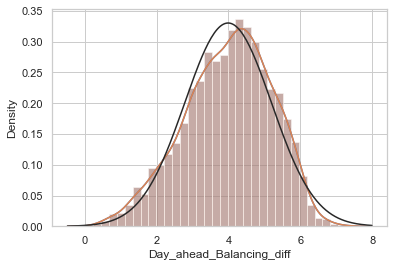

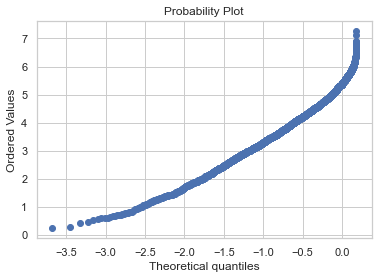

In [227]:
from scipy.stats import norm
from scipy import stats
sns.distplot(pow(y,1/3));
sns.distplot(pow(y,1/3), fit=norm)
fig = plt.figure()
res = stats.probplot(pow(y,1/3), plot=plt)



In [203]:
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score


train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.25)

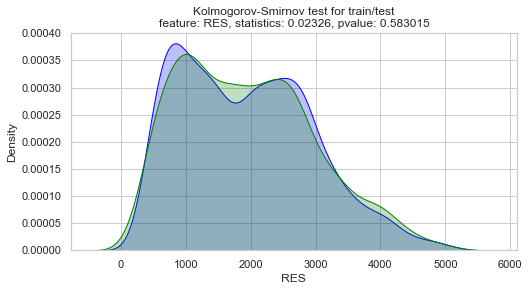

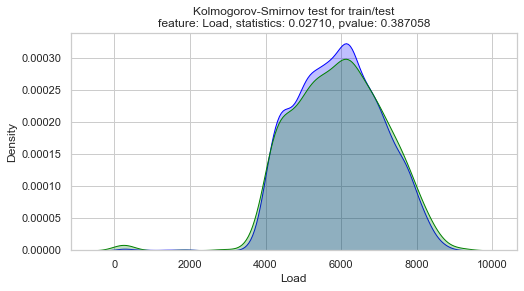

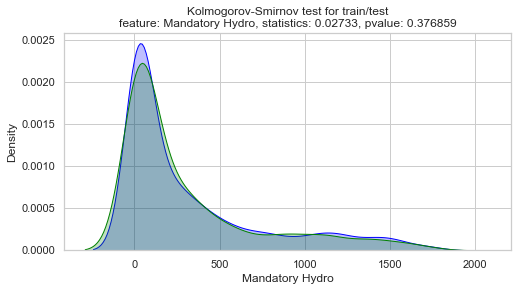

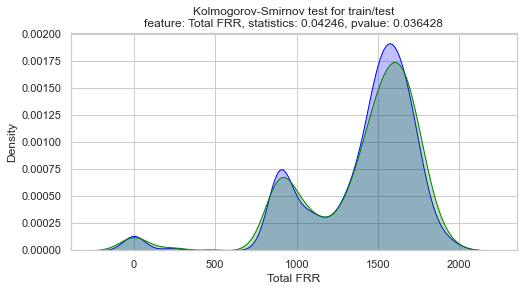

In [204]:
from scipy.stats import ks_2samp
hypothesisnotrejected = []
hypothesisrejected = []

for col in train_X.columns:
    statistic, pvalue = ks_2samp(train_X[col], test_X[col])
    if pvalue>=statistic:
        hypothesisnotrejected.append(col)
    if pvalue<statistic:
        hypothesisrejected.append(col)
        
    plt.figure(figsize=(8,4))
    plt.title("Kolmogorov-Smirnov test for train/test\n"
              "feature: {}, statistics: {:.5f}, pvalue: {:5f}".format(col, statistic, pvalue))
    sns.kdeplot(train_X[col], color='blue', shade=True, label='Train')
    sns.kdeplot(test_X[col], color='green', shade=True, label='Test')

    plt.show()

$\textbf{I want to test the distribution between Test and Train Dataset after the Split}$

In [205]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

num_columns = train_X.columns

ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

train_X = ct.fit_transform(train_X)
test_X = ct.transform(test_X)

$\textbf{CatBoost Regression}$

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

RMS:  105.71239125021192


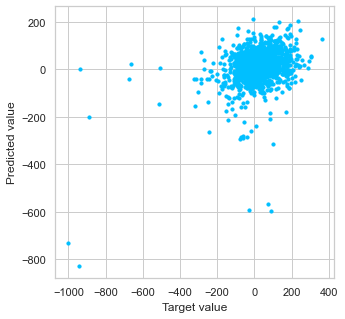

In [206]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error

train_pool = Pool(train_X, 
                  train_y)
test_pool = Pool(test_X) 


####{'colsample_bylevel': 4, 'learning_rate': 5, 'max_depth': 4}, 

#### Grid Search 
# {'depth': 10, 'iterations': 100, 'learning_rate': 0.1}
modelCB = CatBoostRegressor(iterations=8000,
                           depth=4,
                           learning_rate=0.08,
                           loss_function='RMSE',
                           silent=True)

modelCB.fit(train_pool,plot=True)

preds1 = modelCB.predict(test_pool)

preds_train=modelCB.predict(train_pool)
# evaluate predictions
rms1 = mean_squared_error(test_y, preds1, squared=False) #np.sqrt(np.mean((preds1 - test_y) ** 2))
print("RMS: ", rms1)
#print(preds1)



plt.figure(figsize=(5,5))
plt.scatter(test_y, preds1, s=10, color="deepskyblue")
plt.xlabel("Target value")
plt.ylabel("Predicted value")
print(train_pool)

In [207]:
val_preds = modelCB.predict(test_X)
MAPE=np.mean(np.abs((test_y - val_preds) / test_y)) * 100
# calculate mean squared error on val sub-set preds
np.sqrt(mean_squared_error(val_preds, test_y))
print("Accuracy is : ",  100-MAPE)

Accuracy is :  -243.88408409220182


In [208]:
def residual_plot(train_labels, train_preds, test_labels=None, test_preds=None, 
                  title="Residual Plot", figsize=(9,6)):
    """ Residual plot to evaluate performance of our simple linear regressor """
    plt.figure(figsize=figsize)
    plt.scatter(train_preds, train_preds - train_labels, c='blue', alpha=0.1,
                marker='o', edgecolors='white', label='Training')
    
    if test_labels is not None:
        plt.scatter(test_preds, test_preds - test_labels, c='red', alpha=0.1,
                    marker='^', edgecolors='white', label='Test')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    
    if test_labels is not None:
        plt.legend(loc='best')
    plt.title(title)
    plt.show()
    return

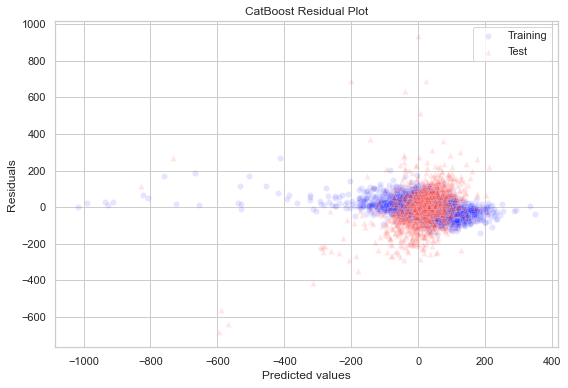

In [209]:
train_preds = modelCB.predict(train_X)

residual_plot(train_y, train_preds, 
              test_y, val_preds, 
              title="CatBoost Residual Plot")

Evaluation on test data
RMSE: 105.71
R2: 0.02
Adjusted R2: 0.02


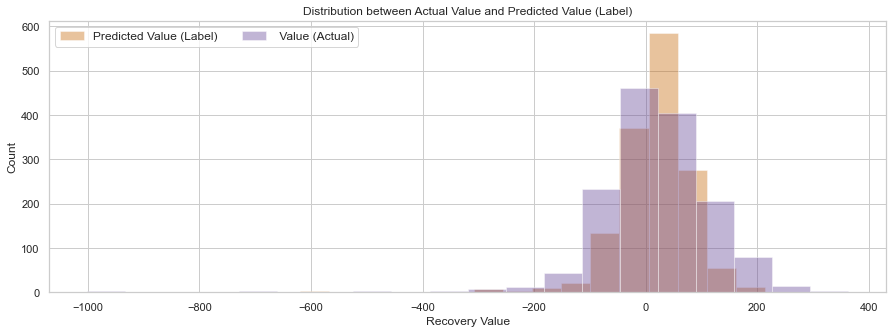

In [210]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_CATBOOST = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_CATBOOST["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_CATBOOST["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")
plt.legend(( 'Predicted Value (Label)',' Value (Actual)'), ncol=2, loc='upper left', fontsize=12)



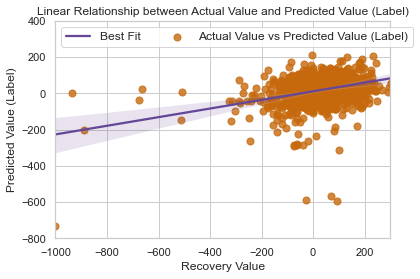

In [211]:
# We can plot the Predicted Value (Label) and Actual Value over the entire dataset. 
sns.regplot(x="Real", y="Prediction", data=output_data_CATBOOST, lowess=False, scatter_kws ={'s':50}, line_kws={"color": "#664697"}, color="#c6690c")
plt.title("Linear Relationship between Actual Value and Predicted Value (Label)")
plt.ylabel("Predicted Value (Label)")
plt.xlabel("Recovery Value")
plt.xlim([-1000, 300])
plt.ylim([-800,400])
plt.legend(('Best Fit', 'Actual Value vs Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)

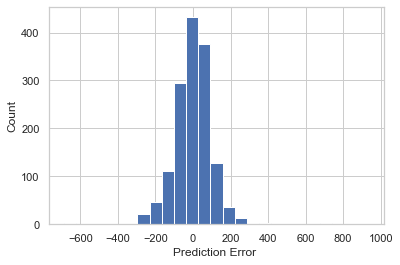

In [212]:
error = preds1 - test_y
plt.hist(error, bins=25)
plt.xlabel('Prediction Error')
_ = plt.ylabel('Count')

In [213]:
output_data_CATBOOST.head(50)
output_data_CATBOOST["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_CATBOOST["Prediction"]]
output_data_CATBOOST["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_CATBOOST["Real"]]

In [214]:
output_data_CATBOOST.head(50)
comparison_column = np.where(output_data_CATBOOST["Prediction_sign"] == output_data_CATBOOST["Real_sign"], True, False)

In [215]:
count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

We have a total of True values :  870


In [216]:
print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

Accuracy of True values compared to the total observations : 0.5894308943089431


In [134]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from catboost import cv
def cross_val(model):
    pred = cross_val_score(model, x, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square
#### Cat Boost
print('Test set evaluation:\n_____________________________________')
print_evaluate(test_y, val_preds)
print('Train set evaluation:\n_____________________________________')
print_evaluate(train_y, train_preds)


#### Light GBM 
results_bsic_Catboost = pd.DataFrame(data=[["Cat Boost", *evaluate(train_y, train_preds) ,cross_val(CatBoostRegressor())]], columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_bsic_Catboost




Test set evaluation:
_____________________________________
MAE: 74.40108948804887
MSE: 9994.296845097597
RMSE: 99.97148015858122
R2 Square 0.0253739170081968
__________________________________
Train set evaluation:
_____________________________________
MAE: 30.06860095577653
MSE: 1562.0253838966953
RMSE: 39.52246682453785
R2 Square 0.8620394536451887
__________________________________
Learning rate set to 0.052543
0:	learn: 109.1527232	total: 4.13ms	remaining: 4.13s
1:	learn: 108.7940305	total: 7.73ms	remaining: 3.86s
2:	learn: 108.4824386	total: 11.5ms	remaining: 3.82s
3:	learn: 108.1830860	total: 16.5ms	remaining: 4.11s
4:	learn: 107.8436480	total: 20.2ms	remaining: 4.03s
5:	learn: 107.5569251	total: 24ms	remaining: 3.97s
6:	learn: 107.2803531	total: 27.8ms	remaining: 3.94s
7:	learn: 107.0414717	total: 31.5ms	remaining: 3.91s
8:	learn: 106.8051689	total: 35.2ms	remaining: 3.88s
9:	learn: 106.5978191	total: 39.1ms	remaining: 3.87s
10:	learn: 106.3923501	total: 43.1ms	remaining: 3.87s


187:	learn: 92.1709690	total: 629ms	remaining: 2.71s
188:	learn: 92.1344919	total: 632ms	remaining: 2.71s
189:	learn: 92.0942286	total: 635ms	remaining: 2.71s
190:	learn: 92.0599983	total: 638ms	remaining: 2.7s
191:	learn: 92.0192982	total: 642ms	remaining: 2.7s
192:	learn: 91.9694918	total: 645ms	remaining: 2.7s
193:	learn: 91.9330744	total: 649ms	remaining: 2.7s
194:	learn: 91.8747345	total: 653ms	remaining: 2.69s
195:	learn: 91.8373000	total: 656ms	remaining: 2.69s
196:	learn: 91.7902352	total: 660ms	remaining: 2.69s
197:	learn: 91.7390738	total: 664ms	remaining: 2.69s
198:	learn: 91.6978524	total: 668ms	remaining: 2.69s
199:	learn: 91.6587905	total: 672ms	remaining: 2.69s
200:	learn: 91.6293901	total: 675ms	remaining: 2.68s
201:	learn: 91.5842125	total: 680ms	remaining: 2.69s
202:	learn: 91.5462129	total: 684ms	remaining: 2.69s
203:	learn: 91.4920475	total: 687ms	remaining: 2.68s
204:	learn: 91.4503587	total: 689ms	remaining: 2.67s
205:	learn: 91.4227544	total: 692ms	remaining: 2.6

367:	learn: 85.8145321	total: 1.28s	remaining: 2.2s
368:	learn: 85.7677150	total: 1.28s	remaining: 2.2s
369:	learn: 85.7495825	total: 1.29s	remaining: 2.19s
370:	learn: 85.6940176	total: 1.29s	remaining: 2.19s
371:	learn: 85.6835945	total: 1.29s	remaining: 2.19s
372:	learn: 85.6481712	total: 1.3s	remaining: 2.18s
373:	learn: 85.6157538	total: 1.3s	remaining: 2.18s
374:	learn: 85.6002028	total: 1.31s	remaining: 2.18s
375:	learn: 85.5673416	total: 1.31s	remaining: 2.17s
376:	learn: 85.5075483	total: 1.31s	remaining: 2.17s
377:	learn: 85.4937065	total: 1.32s	remaining: 2.17s
378:	learn: 85.4757924	total: 1.32s	remaining: 2.17s
379:	learn: 85.4497845	total: 1.33s	remaining: 2.16s
380:	learn: 85.4275064	total: 1.33s	remaining: 2.16s
381:	learn: 85.4065398	total: 1.33s	remaining: 2.16s
382:	learn: 85.3804407	total: 1.34s	remaining: 2.16s
383:	learn: 85.3400594	total: 1.34s	remaining: 2.15s
384:	learn: 85.3107889	total: 1.34s	remaining: 2.15s
385:	learn: 85.2868264	total: 1.35s	remaining: 2.1

549:	learn: 81.2049780	total: 2.11s	remaining: 1.72s
550:	learn: 81.1749566	total: 2.12s	remaining: 1.72s
551:	learn: 81.1585724	total: 2.12s	remaining: 1.72s
552:	learn: 81.1451867	total: 2.13s	remaining: 1.72s
553:	learn: 81.1299294	total: 2.13s	remaining: 1.72s
554:	learn: 81.1077501	total: 2.14s	remaining: 1.71s
555:	learn: 81.0775030	total: 2.15s	remaining: 1.71s
556:	learn: 81.0692101	total: 2.15s	remaining: 1.71s
557:	learn: 81.0567191	total: 2.16s	remaining: 1.71s
558:	learn: 81.0449346	total: 2.16s	remaining: 1.71s
559:	learn: 81.0124981	total: 2.17s	remaining: 1.71s
560:	learn: 80.9971696	total: 2.18s	remaining: 1.7s
561:	learn: 80.9666939	total: 2.19s	remaining: 1.71s
562:	learn: 80.9385645	total: 2.19s	remaining: 1.7s
563:	learn: 80.9285342	total: 2.2s	remaining: 1.7s
564:	learn: 80.9131818	total: 2.21s	remaining: 1.7s
565:	learn: 80.8864538	total: 2.21s	remaining: 1.7s
566:	learn: 80.8735043	total: 2.22s	remaining: 1.69s
567:	learn: 80.8554254	total: 2.22s	remaining: 1.69s

735:	learn: 77.5103484	total: 3.09s	remaining: 1.11s
736:	learn: 77.4978157	total: 3.09s	remaining: 1.1s
737:	learn: 77.4780788	total: 3.1s	remaining: 1.1s
738:	learn: 77.4585060	total: 3.1s	remaining: 1.09s
739:	learn: 77.4357169	total: 3.1s	remaining: 1.09s
740:	learn: 77.4210062	total: 3.11s	remaining: 1.09s
741:	learn: 77.3998729	total: 3.11s	remaining: 1.08s
742:	learn: 77.3818951	total: 3.12s	remaining: 1.08s
743:	learn: 77.3586838	total: 3.12s	remaining: 1.07s
744:	learn: 77.3372509	total: 3.13s	remaining: 1.07s
745:	learn: 77.3115531	total: 3.13s	remaining: 1.06s
746:	learn: 77.2828018	total: 3.14s	remaining: 1.06s
747:	learn: 77.2661253	total: 3.14s	remaining: 1.06s
748:	learn: 77.2476297	total: 3.15s	remaining: 1.05s
749:	learn: 77.2270591	total: 3.15s	remaining: 1.05s
750:	learn: 77.2147304	total: 3.16s	remaining: 1.05s
751:	learn: 77.1977877	total: 3.16s	remaining: 1.04s
752:	learn: 77.1846593	total: 3.17s	remaining: 1.04s
753:	learn: 77.1716814	total: 3.17s	remaining: 1.03

900:	learn: 74.7251501	total: 3.92s	remaining: 431ms
901:	learn: 74.7139493	total: 3.92s	remaining: 426ms
902:	learn: 74.6982397	total: 3.93s	remaining: 422ms
903:	learn: 74.6779406	total: 3.94s	remaining: 418ms
904:	learn: 74.6596163	total: 3.94s	remaining: 414ms
905:	learn: 74.6401899	total: 3.94s	remaining: 409ms
906:	learn: 74.6095276	total: 3.95s	remaining: 405ms
907:	learn: 74.5919099	total: 3.95s	remaining: 401ms
908:	learn: 74.5726560	total: 3.96s	remaining: 397ms
909:	learn: 74.5561107	total: 3.96s	remaining: 392ms
910:	learn: 74.5356765	total: 3.97s	remaining: 388ms
911:	learn: 74.5115381	total: 3.98s	remaining: 384ms
912:	learn: 74.5022064	total: 3.98s	remaining: 379ms
913:	learn: 74.4916074	total: 3.98s	remaining: 375ms
914:	learn: 74.4700225	total: 3.99s	remaining: 371ms
915:	learn: 74.4506781	total: 4s	remaining: 367ms
916:	learn: 74.4374654	total: 4s	remaining: 362ms
917:	learn: 74.4217128	total: 4.01s	remaining: 358ms
918:	learn: 74.4092066	total: 4.01s	remaining: 354ms

63:	learn: 99.7973006	total: 317ms	remaining: 4.64s
64:	learn: 99.6916409	total: 321ms	remaining: 4.61s
65:	learn: 99.5705013	total: 329ms	remaining: 4.66s
66:	learn: 99.5112528	total: 333ms	remaining: 4.64s
67:	learn: 99.4507802	total: 338ms	remaining: 4.63s
68:	learn: 99.3734672	total: 344ms	remaining: 4.64s
69:	learn: 99.3135184	total: 348ms	remaining: 4.62s
70:	learn: 99.2077354	total: 351ms	remaining: 4.59s
71:	learn: 99.1560301	total: 359ms	remaining: 4.63s
72:	learn: 99.0376867	total: 362ms	remaining: 4.6s
73:	learn: 98.9732549	total: 366ms	remaining: 4.58s
74:	learn: 98.8929930	total: 373ms	remaining: 4.6s
75:	learn: 98.8368401	total: 446ms	remaining: 5.42s
76:	learn: 98.7749761	total: 457ms	remaining: 5.47s
77:	learn: 98.7168660	total: 460ms	remaining: 5.43s
78:	learn: 98.5443255	total: 464ms	remaining: 5.41s
79:	learn: 98.4496715	total: 471ms	remaining: 5.42s
80:	learn: 98.3737515	total: 474ms	remaining: 5.38s
81:	learn: 98.3207318	total: 478ms	remaining: 5.35s
82:	learn: 98.

220:	learn: 91.3164750	total: 1.15s	remaining: 4.06s
221:	learn: 91.2837033	total: 1.16s	remaining: 4.07s
222:	learn: 91.2284843	total: 1.16s	remaining: 4.06s
223:	learn: 91.2048177	total: 1.17s	remaining: 4.05s
224:	learn: 91.1699174	total: 1.18s	remaining: 4.05s
225:	learn: 91.1412809	total: 1.18s	remaining: 4.04s
226:	learn: 91.1090812	total: 1.18s	remaining: 4.03s
227:	learn: 91.0622049	total: 1.19s	remaining: 4.03s
228:	learn: 90.9938524	total: 1.19s	remaining: 4.02s
229:	learn: 90.9669847	total: 1.2s	remaining: 4.01s
230:	learn: 90.9253945	total: 1.2s	remaining: 4.01s
231:	learn: 90.8622061	total: 1.21s	remaining: 4s
232:	learn: 90.8104991	total: 1.21s	remaining: 3.99s
233:	learn: 90.7751858	total: 1.22s	remaining: 4s
234:	learn: 90.7092105	total: 1.22s	remaining: 3.99s
235:	learn: 90.6808390	total: 1.23s	remaining: 3.98s
236:	learn: 90.6565582	total: 1.24s	remaining: 3.99s
237:	learn: 90.6294834	total: 1.24s	remaining: 3.98s
238:	learn: 90.5994963	total: 1.25s	remaining: 3.97s
2

405:	learn: 85.1149192	total: 1.81s	remaining: 2.65s
406:	learn: 85.1068513	total: 1.82s	remaining: 2.65s
407:	learn: 85.0647761	total: 1.82s	remaining: 2.64s
408:	learn: 85.0473037	total: 1.82s	remaining: 2.63s
409:	learn: 85.0161623	total: 1.82s	remaining: 2.62s
410:	learn: 85.0005955	total: 1.83s	remaining: 2.62s
411:	learn: 84.9731297	total: 1.83s	remaining: 2.61s
412:	learn: 84.9522697	total: 1.83s	remaining: 2.61s
413:	learn: 84.9229851	total: 1.84s	remaining: 2.6s
414:	learn: 84.9017822	total: 1.84s	remaining: 2.6s
415:	learn: 84.8757260	total: 1.85s	remaining: 2.59s
416:	learn: 84.8468744	total: 1.85s	remaining: 2.59s
417:	learn: 84.8337307	total: 1.85s	remaining: 2.58s
418:	learn: 84.8226475	total: 1.86s	remaining: 2.58s
419:	learn: 84.8074164	total: 1.86s	remaining: 2.57s
420:	learn: 84.7741236	total: 1.87s	remaining: 2.57s
421:	learn: 84.7428594	total: 1.87s	remaining: 2.56s
422:	learn: 84.7191250	total: 1.88s	remaining: 2.56s
423:	learn: 84.7044286	total: 1.88s	remaining: 2

565:	learn: 81.1721373	total: 2.47s	remaining: 1.9s
566:	learn: 81.1270499	total: 2.48s	remaining: 1.9s
567:	learn: 81.1022385	total: 2.49s	remaining: 1.89s
568:	learn: 81.0670529	total: 2.49s	remaining: 1.89s
569:	learn: 81.0474944	total: 2.5s	remaining: 1.88s
570:	learn: 81.0121871	total: 2.5s	remaining: 1.88s
571:	learn: 80.9922308	total: 2.5s	remaining: 1.87s
572:	learn: 80.9675466	total: 2.51s	remaining: 1.87s
573:	learn: 80.9470363	total: 2.52s	remaining: 1.87s
574:	learn: 80.9360805	total: 2.52s	remaining: 1.86s
575:	learn: 80.9005770	total: 2.53s	remaining: 1.86s
576:	learn: 80.8855620	total: 2.53s	remaining: 1.86s
577:	learn: 80.8636064	total: 2.54s	remaining: 1.85s
578:	learn: 80.8317284	total: 2.54s	remaining: 1.85s
579:	learn: 80.8106030	total: 2.55s	remaining: 1.84s
580:	learn: 80.7946110	total: 2.55s	remaining: 1.84s
581:	learn: 80.7671643	total: 2.56s	remaining: 1.84s
582:	learn: 80.7489326	total: 2.56s	remaining: 1.83s
583:	learn: 80.6959646	total: 2.56s	remaining: 1.83

735:	learn: 77.7311540	total: 3.14s	remaining: 1.13s
736:	learn: 77.7125623	total: 3.15s	remaining: 1.12s
737:	learn: 77.6987843	total: 3.15s	remaining: 1.12s
738:	learn: 77.6773171	total: 3.15s	remaining: 1.11s
739:	learn: 77.6442183	total: 3.16s	remaining: 1.11s
740:	learn: 77.6325753	total: 3.16s	remaining: 1.1s
741:	learn: 77.6128010	total: 3.17s	remaining: 1.1s
742:	learn: 77.6006816	total: 3.17s	remaining: 1.1s
743:	learn: 77.5798560	total: 3.17s	remaining: 1.09s
744:	learn: 77.5652356	total: 3.17s	remaining: 1.09s
745:	learn: 77.5510320	total: 3.18s	remaining: 1.08s
746:	learn: 77.5188772	total: 3.18s	remaining: 1.08s
747:	learn: 77.4963971	total: 3.19s	remaining: 1.07s
748:	learn: 77.4849131	total: 3.19s	remaining: 1.07s
749:	learn: 77.4637451	total: 3.19s	remaining: 1.06s
750:	learn: 77.4448109	total: 3.19s	remaining: 1.06s
751:	learn: 77.4307279	total: 3.2s	remaining: 1.05s
752:	learn: 77.4068145	total: 3.2s	remaining: 1.05s
753:	learn: 77.3940960	total: 3.2s	remaining: 1.04s

913:	learn: 74.7270663	total: 3.8s	remaining: 358ms
914:	learn: 74.7106018	total: 3.81s	remaining: 354ms
915:	learn: 74.6984890	total: 3.81s	remaining: 349ms
916:	learn: 74.6817187	total: 3.81s	remaining: 345ms
917:	learn: 74.6748784	total: 3.82s	remaining: 341ms
918:	learn: 74.6583862	total: 3.83s	remaining: 337ms
919:	learn: 74.6530744	total: 3.83s	remaining: 333ms
920:	learn: 74.6321332	total: 3.84s	remaining: 329ms
921:	learn: 74.6153171	total: 3.84s	remaining: 325ms
922:	learn: 74.5935867	total: 3.84s	remaining: 321ms
923:	learn: 74.5636108	total: 3.85s	remaining: 317ms
924:	learn: 74.5411494	total: 3.85s	remaining: 313ms
925:	learn: 74.5287614	total: 3.86s	remaining: 308ms
926:	learn: 74.5168860	total: 3.87s	remaining: 304ms
927:	learn: 74.4926897	total: 3.87s	remaining: 300ms
928:	learn: 74.4842503	total: 3.88s	remaining: 296ms
929:	learn: 74.4646421	total: 3.88s	remaining: 292ms
930:	learn: 74.4495584	total: 3.88s	remaining: 288ms
931:	learn: 74.4321866	total: 3.89s	remaining: 

95:	learn: 93.2202546	total: 494ms	remaining: 4.65s
96:	learn: 93.1717616	total: 497ms	remaining: 4.63s
97:	learn: 93.1104247	total: 504ms	remaining: 4.64s
98:	learn: 93.0558472	total: 508ms	remaining: 4.62s
99:	learn: 93.0061268	total: 512ms	remaining: 4.61s
100:	learn: 92.9451742	total: 519ms	remaining: 4.62s
101:	learn: 92.8845454	total: 523ms	remaining: 4.6s
102:	learn: 92.8222167	total: 527ms	remaining: 4.59s
103:	learn: 92.7647796	total: 535ms	remaining: 4.61s
104:	learn: 92.7170689	total: 538ms	remaining: 4.59s
105:	learn: 92.6230479	total: 542ms	remaining: 4.57s
106:	learn: 92.5787123	total: 551ms	remaining: 4.6s
107:	learn: 92.5356345	total: 554ms	remaining: 4.58s
108:	learn: 92.4778490	total: 558ms	remaining: 4.56s
109:	learn: 92.4218826	total: 566ms	remaining: 4.58s
110:	learn: 92.3719313	total: 569ms	remaining: 4.56s
111:	learn: 92.3189227	total: 574ms	remaining: 4.55s
112:	learn: 92.2483843	total: 580ms	remaining: 4.55s
113:	learn: 92.1858999	total: 583ms	remaining: 4.53s


281:	learn: 84.8975685	total: 1.47s	remaining: 3.74s
282:	learn: 84.8623330	total: 1.48s	remaining: 3.74s
283:	learn: 84.8292363	total: 1.48s	remaining: 3.73s
284:	learn: 84.8044114	total: 1.48s	remaining: 3.72s
285:	learn: 84.7831154	total: 1.49s	remaining: 3.72s
286:	learn: 84.7544484	total: 1.5s	remaining: 3.71s
287:	learn: 84.7195602	total: 1.5s	remaining: 3.71s
288:	learn: 84.6896214	total: 1.51s	remaining: 3.71s
289:	learn: 84.6178785	total: 1.51s	remaining: 3.7s
290:	learn: 84.5893523	total: 1.51s	remaining: 3.69s
291:	learn: 84.5777545	total: 1.52s	remaining: 3.68s
292:	learn: 84.5524161	total: 1.52s	remaining: 3.67s
293:	learn: 84.4831731	total: 1.53s	remaining: 3.68s
294:	learn: 84.4564624	total: 1.53s	remaining: 3.67s
295:	learn: 84.4214695	total: 1.54s	remaining: 3.66s
296:	learn: 84.3984063	total: 1.55s	remaining: 3.66s
297:	learn: 84.3579384	total: 1.55s	remaining: 3.65s
298:	learn: 84.3327050	total: 1.56s	remaining: 3.65s
299:	learn: 84.3096437	total: 1.56s	remaining: 3.

451:	learn: 80.0029265	total: 2.29s	remaining: 2.77s
452:	learn: 79.9779493	total: 2.29s	remaining: 2.77s
453:	learn: 79.9648967	total: 2.29s	remaining: 2.76s
454:	learn: 79.9445651	total: 2.3s	remaining: 2.75s
455:	learn: 79.9363231	total: 2.31s	remaining: 2.75s
456:	learn: 79.9093581	total: 2.31s	remaining: 2.74s
457:	learn: 79.8832260	total: 2.31s	remaining: 2.74s
458:	learn: 79.8473900	total: 2.32s	remaining: 2.73s
459:	learn: 79.8186011	total: 2.32s	remaining: 2.73s
460:	learn: 79.7902244	total: 2.33s	remaining: 2.72s
461:	learn: 79.7675979	total: 2.33s	remaining: 2.72s
462:	learn: 79.7218579	total: 2.34s	remaining: 2.71s
463:	learn: 79.6972234	total: 2.34s	remaining: 2.71s
464:	learn: 79.6667804	total: 2.35s	remaining: 2.71s
465:	learn: 79.6463289	total: 2.35s	remaining: 2.7s
466:	learn: 79.6170214	total: 2.36s	remaining: 2.69s
467:	learn: 79.5836802	total: 2.36s	remaining: 2.69s
468:	learn: 79.5566238	total: 2.37s	remaining: 2.68s
469:	learn: 79.5340036	total: 2.37s	remaining: 2

640:	learn: 75.7467157	total: 3.11s	remaining: 1.74s
641:	learn: 75.7230608	total: 3.11s	remaining: 1.74s
642:	learn: 75.7131626	total: 3.12s	remaining: 1.73s
643:	learn: 75.6988212	total: 3.12s	remaining: 1.73s
644:	learn: 75.6871783	total: 3.13s	remaining: 1.72s
645:	learn: 75.6661510	total: 3.13s	remaining: 1.71s
646:	learn: 75.6440870	total: 3.13s	remaining: 1.71s
647:	learn: 75.6264506	total: 3.14s	remaining: 1.71s
648:	learn: 75.6045095	total: 3.14s	remaining: 1.7s
649:	learn: 75.5843857	total: 3.15s	remaining: 1.69s
650:	learn: 75.5663524	total: 3.15s	remaining: 1.69s
651:	learn: 75.5450072	total: 3.16s	remaining: 1.69s
652:	learn: 75.5297209	total: 3.16s	remaining: 1.68s
653:	learn: 75.5081000	total: 3.17s	remaining: 1.68s
654:	learn: 75.4924629	total: 3.17s	remaining: 1.67s
655:	learn: 75.4722379	total: 3.18s	remaining: 1.67s
656:	learn: 75.4639482	total: 3.19s	remaining: 1.66s
657:	learn: 75.4475000	total: 3.19s	remaining: 1.66s
658:	learn: 75.4392605	total: 3.19s	remaining: 

828:	learn: 72.4548321	total: 3.93s	remaining: 811ms
829:	learn: 72.4384483	total: 3.94s	remaining: 806ms
830:	learn: 72.4221865	total: 3.94s	remaining: 801ms
831:	learn: 72.3926757	total: 3.94s	remaining: 797ms
832:	learn: 72.3852566	total: 3.95s	remaining: 792ms
833:	learn: 72.3641495	total: 3.95s	remaining: 787ms
834:	learn: 72.3538293	total: 3.96s	remaining: 783ms
835:	learn: 72.3325253	total: 3.96s	remaining: 778ms
836:	learn: 72.3215872	total: 3.97s	remaining: 773ms
837:	learn: 72.3087525	total: 3.97s	remaining: 768ms
838:	learn: 72.2885501	total: 3.98s	remaining: 763ms
839:	learn: 72.2742967	total: 3.98s	remaining: 758ms
840:	learn: 72.2514979	total: 3.99s	remaining: 754ms
841:	learn: 72.2439393	total: 3.99s	remaining: 749ms
842:	learn: 72.2228077	total: 4s	remaining: 744ms
843:	learn: 72.2142002	total: 4s	remaining: 740ms
844:	learn: 72.1983348	total: 4.01s	remaining: 735ms
845:	learn: 72.1721437	total: 4.01s	remaining: 730ms
846:	learn: 72.1560917	total: 4.01s	remaining: 725ms

3:	learn: 105.9728221	total: 16.7ms	remaining: 4.17s
4:	learn: 105.6909117	total: 20.1ms	remaining: 4s
5:	learn: 105.4179138	total: 24.2ms	remaining: 4.01s
6:	learn: 105.1403954	total: 27.8ms	remaining: 3.94s
7:	learn: 104.8728526	total: 31.9ms	remaining: 3.96s
8:	learn: 104.6193049	total: 38.8ms	remaining: 4.27s
9:	learn: 104.3682949	total: 42.6ms	remaining: 4.22s
10:	learn: 104.1253077	total: 46.4ms	remaining: 4.17s
11:	learn: 103.8864041	total: 53.6ms	remaining: 4.41s
12:	learn: 103.6235928	total: 57.1ms	remaining: 4.33s
13:	learn: 103.4702681	total: 60.6ms	remaining: 4.27s
14:	learn: 103.2939591	total: 67.9ms	remaining: 4.46s
15:	learn: 103.1322307	total: 74.7ms	remaining: 4.59s
16:	learn: 102.9046859	total: 78.6ms	remaining: 4.55s
17:	learn: 102.7763801	total: 85.7ms	remaining: 4.67s
18:	learn: 102.6025289	total: 89.2ms	remaining: 4.6s
19:	learn: 102.3880529	total: 92.4ms	remaining: 4.53s
20:	learn: 102.2457006	total: 99.5ms	remaining: 4.64s
21:	learn: 102.0726776	total: 103ms	rem

196:	learn: 89.9697535	total: 844ms	remaining: 3.44s
197:	learn: 89.9154141	total: 848ms	remaining: 3.44s
198:	learn: 89.8896537	total: 856ms	remaining: 3.44s
199:	learn: 89.8538830	total: 860ms	remaining: 3.44s
200:	learn: 89.8261948	total: 864ms	remaining: 3.43s
201:	learn: 89.7899341	total: 872ms	remaining: 3.44s
202:	learn: 89.7474385	total: 877ms	remaining: 3.44s
203:	learn: 89.7208295	total: 880ms	remaining: 3.43s
204:	learn: 89.6243809	total: 889ms	remaining: 3.45s
205:	learn: 89.5894912	total: 893ms	remaining: 3.44s
206:	learn: 89.5647626	total: 901ms	remaining: 3.45s
207:	learn: 89.5139284	total: 906ms	remaining: 3.45s
208:	learn: 89.4691153	total: 915ms	remaining: 3.46s
209:	learn: 89.4415470	total: 923ms	remaining: 3.47s
210:	learn: 89.3889363	total: 930ms	remaining: 3.48s
211:	learn: 89.3475705	total: 936ms	remaining: 3.48s
212:	learn: 89.3248113	total: 940ms	remaining: 3.47s
213:	learn: 89.2984097	total: 949ms	remaining: 3.48s
214:	learn: 89.2538192	total: 953ms	remaining:

373:	learn: 83.7256756	total: 1.67s	remaining: 2.79s
374:	learn: 83.6953641	total: 1.67s	remaining: 2.78s
375:	learn: 83.6769939	total: 1.68s	remaining: 2.78s
376:	learn: 83.6525689	total: 1.68s	remaining: 2.78s
377:	learn: 83.6285819	total: 1.68s	remaining: 2.77s
378:	learn: 83.6046080	total: 1.69s	remaining: 2.77s
379:	learn: 83.5820076	total: 1.69s	remaining: 2.76s
380:	learn: 83.5508604	total: 1.7s	remaining: 2.76s
381:	learn: 83.5062225	total: 1.7s	remaining: 2.75s
382:	learn: 83.4793587	total: 1.71s	remaining: 2.75s
383:	learn: 83.4373838	total: 1.71s	remaining: 2.75s
384:	learn: 83.4064652	total: 1.71s	remaining: 2.74s
385:	learn: 83.3837165	total: 1.72s	remaining: 2.74s
386:	learn: 83.3537796	total: 1.73s	remaining: 2.74s
387:	learn: 83.3363850	total: 1.73s	remaining: 2.73s
388:	learn: 83.2950539	total: 1.74s	remaining: 2.73s
389:	learn: 83.2753087	total: 1.74s	remaining: 2.73s
390:	learn: 83.2449417	total: 1.75s	remaining: 2.72s
391:	learn: 83.2251949	total: 1.75s	remaining: 2

561:	learn: 79.2979890	total: 2.49s	remaining: 1.94s
562:	learn: 79.2761699	total: 2.49s	remaining: 1.93s
563:	learn: 79.2526507	total: 2.5s	remaining: 1.93s
564:	learn: 79.2303435	total: 2.5s	remaining: 1.93s
565:	learn: 79.2039312	total: 2.5s	remaining: 1.92s
566:	learn: 79.1994282	total: 2.51s	remaining: 1.92s
567:	learn: 79.1676965	total: 2.52s	remaining: 1.91s
568:	learn: 79.1311196	total: 2.52s	remaining: 1.91s
569:	learn: 79.1225620	total: 2.53s	remaining: 1.91s
570:	learn: 79.0960313	total: 2.53s	remaining: 1.9s
571:	learn: 79.0727502	total: 2.53s	remaining: 1.9s
572:	learn: 79.0498610	total: 2.54s	remaining: 1.89s
573:	learn: 79.0283475	total: 2.54s	remaining: 1.89s
574:	learn: 79.0041394	total: 2.55s	remaining: 1.88s
575:	learn: 78.9863464	total: 2.56s	remaining: 1.88s
576:	learn: 78.9645586	total: 2.56s	remaining: 1.88s
577:	learn: 78.9444685	total: 2.56s	remaining: 1.87s
578:	learn: 78.9330466	total: 2.57s	remaining: 1.87s
579:	learn: 78.9099278	total: 2.57s	remaining: 1.86

751:	learn: 75.7256888	total: 3.31s	remaining: 1.09s
752:	learn: 75.7000323	total: 3.31s	remaining: 1.09s
753:	learn: 75.6890183	total: 3.32s	remaining: 1.08s
754:	learn: 75.6797888	total: 3.32s	remaining: 1.08s
755:	learn: 75.6655816	total: 3.33s	remaining: 1.07s
756:	learn: 75.6567433	total: 3.33s	remaining: 1.07s
757:	learn: 75.6353805	total: 3.33s	remaining: 1.06s
758:	learn: 75.6153511	total: 3.34s	remaining: 1.06s
759:	learn: 75.6086271	total: 3.35s	remaining: 1.06s
760:	learn: 75.5968873	total: 3.35s	remaining: 1.05s
761:	learn: 75.5859440	total: 3.36s	remaining: 1.05s
762:	learn: 75.5796812	total: 3.36s	remaining: 1.04s
763:	learn: 75.5632121	total: 3.37s	remaining: 1.04s
764:	learn: 75.5561364	total: 3.37s	remaining: 1.03s
765:	learn: 75.5388237	total: 3.37s	remaining: 1.03s
766:	learn: 75.5108508	total: 3.38s	remaining: 1.03s
767:	learn: 75.4949383	total: 3.38s	remaining: 1.02s
768:	learn: 75.4846679	total: 3.39s	remaining: 1.02s
769:	learn: 75.4644245	total: 3.39s	remaining:

938:	learn: 72.6128957	total: 4.13s	remaining: 269ms
939:	learn: 72.5975861	total: 4.14s	remaining: 264ms
940:	learn: 72.5845462	total: 4.14s	remaining: 260ms
941:	learn: 72.5591407	total: 4.15s	remaining: 255ms
942:	learn: 72.5246372	total: 4.15s	remaining: 251ms
943:	learn: 72.5112534	total: 4.15s	remaining: 246ms
944:	learn: 72.5033303	total: 4.16s	remaining: 242ms
945:	learn: 72.4776358	total: 4.16s	remaining: 238ms
946:	learn: 72.4592497	total: 4.17s	remaining: 233ms
947:	learn: 72.4532329	total: 4.17s	remaining: 229ms
948:	learn: 72.4430633	total: 4.18s	remaining: 225ms
949:	learn: 72.4342063	total: 4.18s	remaining: 220ms
950:	learn: 72.4206941	total: 4.18s	remaining: 216ms
951:	learn: 72.4092095	total: 4.19s	remaining: 211ms
952:	learn: 72.3923287	total: 4.2s	remaining: 207ms
953:	learn: 72.3665717	total: 4.2s	remaining: 203ms
954:	learn: 72.3451743	total: 4.21s	remaining: 198ms
955:	learn: 72.3352522	total: 4.21s	remaining: 194ms
956:	learn: 72.3168477	total: 4.21s	remaining: 1

136:	learn: 87.9306030	total: 492ms	remaining: 3.1s
137:	learn: 87.8874924	total: 496ms	remaining: 3.1s
138:	learn: 87.8461168	total: 499ms	remaining: 3.09s
139:	learn: 87.8021974	total: 503ms	remaining: 3.09s
140:	learn: 87.7598473	total: 508ms	remaining: 3.09s
141:	learn: 87.7281584	total: 511ms	remaining: 3.09s
142:	learn: 87.6819490	total: 515ms	remaining: 3.08s
143:	learn: 87.6469680	total: 518ms	remaining: 3.08s
144:	learn: 87.6126663	total: 522ms	remaining: 3.08s
145:	learn: 87.5580115	total: 525ms	remaining: 3.07s
146:	learn: 87.5334488	total: 529ms	remaining: 3.07s
147:	learn: 87.4791499	total: 533ms	remaining: 3.07s
148:	learn: 87.4078780	total: 537ms	remaining: 3.07s
149:	learn: 87.3777256	total: 543ms	remaining: 3.08s
150:	learn: 87.3399431	total: 545ms	remaining: 3.07s
151:	learn: 87.2586774	total: 548ms	remaining: 3.06s
152:	learn: 87.2181357	total: 551ms	remaining: 3.05s
153:	learn: 87.1827414	total: 554ms	remaining: 3.04s
154:	learn: 87.1462592	total: 557ms	remaining: 3

341:	learn: 80.7974415	total: 1.16s	remaining: 2.23s
342:	learn: 80.7635614	total: 1.16s	remaining: 2.22s
343:	learn: 80.7413407	total: 1.16s	remaining: 2.22s
344:	learn: 80.7072079	total: 1.17s	remaining: 2.22s
345:	learn: 80.6776155	total: 1.17s	remaining: 2.21s
346:	learn: 80.6526916	total: 1.18s	remaining: 2.21s
347:	learn: 80.6272960	total: 1.18s	remaining: 2.21s
348:	learn: 80.5978688	total: 1.18s	remaining: 2.2s
349:	learn: 80.5672877	total: 1.19s	remaining: 2.2s
350:	learn: 80.5461183	total: 1.19s	remaining: 2.2s
351:	learn: 80.5233492	total: 1.19s	remaining: 2.19s
352:	learn: 80.5042239	total: 1.2s	remaining: 2.19s
353:	learn: 80.4775398	total: 1.2s	remaining: 2.19s
354:	learn: 80.4557323	total: 1.21s	remaining: 2.19s
355:	learn: 80.4130111	total: 1.21s	remaining: 2.19s
356:	learn: 80.3603910	total: 1.22s	remaining: 2.19s
357:	learn: 80.3255541	total: 1.22s	remaining: 2.19s
358:	learn: 80.3037902	total: 1.22s	remaining: 2.19s
359:	learn: 80.2779319	total: 1.23s	remaining: 2.19

511:	learn: 76.7478008	total: 1.82s	remaining: 1.73s
512:	learn: 76.7159698	total: 1.82s	remaining: 1.73s
513:	learn: 76.6940924	total: 1.82s	remaining: 1.72s
514:	learn: 76.6704754	total: 1.83s	remaining: 1.72s
515:	learn: 76.6352117	total: 1.83s	remaining: 1.72s
516:	learn: 76.6129101	total: 1.83s	remaining: 1.71s
517:	learn: 76.5971373	total: 1.84s	remaining: 1.71s
518:	learn: 76.5775676	total: 1.84s	remaining: 1.71s
519:	learn: 76.5598058	total: 1.84s	remaining: 1.7s
520:	learn: 76.5374932	total: 1.85s	remaining: 1.7s
521:	learn: 76.4949590	total: 1.85s	remaining: 1.7s
522:	learn: 76.4665004	total: 1.86s	remaining: 1.69s
523:	learn: 76.4518117	total: 1.86s	remaining: 1.69s
524:	learn: 76.4266048	total: 1.86s	remaining: 1.68s
525:	learn: 76.4021258	total: 1.86s	remaining: 1.68s
526:	learn: 76.3818057	total: 1.87s	remaining: 1.68s
527:	learn: 76.3623600	total: 1.87s	remaining: 1.67s
528:	learn: 76.3484572	total: 1.87s	remaining: 1.67s
529:	learn: 76.3204871	total: 1.88s	remaining: 1.

685:	learn: 73.3597076	total: 2.3s	remaining: 1.05s
686:	learn: 73.3404486	total: 2.3s	remaining: 1.05s
687:	learn: 73.3265979	total: 2.31s	remaining: 1.04s
688:	learn: 73.3016472	total: 2.31s	remaining: 1.04s
689:	learn: 73.2782182	total: 2.31s	remaining: 1.04s
690:	learn: 73.2672892	total: 2.32s	remaining: 1.04s
691:	learn: 73.2546195	total: 2.32s	remaining: 1.03s
692:	learn: 73.2472860	total: 2.32s	remaining: 1.03s
693:	learn: 73.2285945	total: 2.33s	remaining: 1.03s
694:	learn: 73.2108544	total: 2.33s	remaining: 1.02s
695:	learn: 73.1964063	total: 2.33s	remaining: 1.02s
696:	learn: 73.1733280	total: 2.34s	remaining: 1.02s
697:	learn: 73.1603278	total: 2.34s	remaining: 1.01s
698:	learn: 73.1381704	total: 2.35s	remaining: 1.01s
699:	learn: 73.1177709	total: 2.35s	remaining: 1.01s
700:	learn: 73.0994898	total: 2.36s	remaining: 1s
701:	learn: 73.0806446	total: 2.36s	remaining: 1s
702:	learn: 73.0667929	total: 2.36s	remaining: 998ms
703:	learn: 73.0458536	total: 2.37s	remaining: 995ms
7

841:	learn: 70.8086874	total: 2.79s	remaining: 523ms
842:	learn: 70.7809902	total: 2.79s	remaining: 520ms
843:	learn: 70.7620011	total: 2.79s	remaining: 516ms
844:	learn: 70.7379476	total: 2.8s	remaining: 513ms
845:	learn: 70.7233043	total: 2.8s	remaining: 510ms
846:	learn: 70.6985976	total: 2.8s	remaining: 506ms
847:	learn: 70.6860465	total: 2.81s	remaining: 503ms
848:	learn: 70.6682537	total: 2.81s	remaining: 500ms
849:	learn: 70.6564865	total: 2.81s	remaining: 497ms
850:	learn: 70.6330567	total: 2.82s	remaining: 493ms
851:	learn: 70.6228328	total: 2.82s	remaining: 490ms
852:	learn: 70.6067316	total: 2.82s	remaining: 487ms
853:	learn: 70.5918304	total: 2.83s	remaining: 484ms
854:	learn: 70.5763475	total: 2.83s	remaining: 480ms
855:	learn: 70.5703586	total: 2.83s	remaining: 477ms
856:	learn: 70.5573777	total: 2.84s	remaining: 473ms
857:	learn: 70.5335632	total: 2.84s	remaining: 470ms
858:	learn: 70.5216249	total: 2.84s	remaining: 467ms
859:	learn: 70.5027092	total: 2.85s	remaining: 46

2:	learn: 103.5882691	total: 13ms	remaining: 4.33s
3:	learn: 103.3590331	total: 16.6ms	remaining: 4.13s
4:	learn: 103.1046043	total: 23.7ms	remaining: 4.71s
5:	learn: 102.7706200	total: 27.6ms	remaining: 4.58s
6:	learn: 102.4979606	total: 31.5ms	remaining: 4.47s
7:	learn: 102.1864099	total: 38.2ms	remaining: 4.73s
8:	learn: 101.8983488	total: 41.9ms	remaining: 4.61s
9:	learn: 101.6317151	total: 45.8ms	remaining: 4.54s
10:	learn: 101.3307841	total: 53.2ms	remaining: 4.78s
11:	learn: 101.1028527	total: 56.9ms	remaining: 4.68s
12:	learn: 100.7996246	total: 61.6ms	remaining: 4.67s
13:	learn: 100.5957406	total: 67ms	remaining: 4.72s
14:	learn: 100.3653022	total: 71.7ms	remaining: 4.71s
15:	learn: 100.1155185	total: 75.7ms	remaining: 4.65s
16:	learn: 99.8829873	total: 84ms	remaining: 4.86s
17:	learn: 99.7686566	total: 87.8ms	remaining: 4.79s
18:	learn: 99.5856846	total: 92.1ms	remaining: 4.75s
19:	learn: 99.4085883	total: 97.1ms	remaining: 4.75s
20:	learn: 99.2827375	total: 101ms	remaining: 

164:	learn: 88.5252627	total: 671ms	remaining: 3.4s
165:	learn: 88.5067498	total: 675ms	remaining: 3.39s
166:	learn: 88.4672495	total: 678ms	remaining: 3.38s
167:	learn: 88.4273279	total: 682ms	remaining: 3.38s
168:	learn: 88.4036732	total: 686ms	remaining: 3.37s
169:	learn: 88.3504982	total: 689ms	remaining: 3.36s
170:	learn: 88.2598559	total: 692ms	remaining: 3.36s
171:	learn: 88.2216981	total: 696ms	remaining: 3.35s
172:	learn: 88.1813439	total: 700ms	remaining: 3.35s
173:	learn: 88.1426797	total: 703ms	remaining: 3.34s
174:	learn: 88.1022526	total: 709ms	remaining: 3.34s
175:	learn: 88.0586947	total: 712ms	remaining: 3.33s
176:	learn: 88.0218415	total: 714ms	remaining: 3.32s
177:	learn: 87.9738434	total: 717ms	remaining: 3.31s
178:	learn: 87.9351654	total: 720ms	remaining: 3.3s
179:	learn: 87.9049671	total: 725ms	remaining: 3.3s
180:	learn: 87.8661646	total: 728ms	remaining: 3.29s
181:	learn: 87.8122075	total: 730ms	remaining: 3.28s
182:	learn: 87.7652947	total: 732ms	remaining: 3.

341:	learn: 82.3642006	total: 1.16s	remaining: 2.24s
342:	learn: 82.3295414	total: 1.17s	remaining: 2.24s
343:	learn: 82.2951475	total: 1.17s	remaining: 2.23s
344:	learn: 82.2745647	total: 1.17s	remaining: 2.23s
345:	learn: 82.2321397	total: 1.18s	remaining: 2.23s
346:	learn: 82.2053725	total: 1.18s	remaining: 2.22s
347:	learn: 82.1743663	total: 1.19s	remaining: 2.22s
348:	learn: 82.1311329	total: 1.19s	remaining: 2.22s
349:	learn: 82.1052217	total: 1.19s	remaining: 2.21s
350:	learn: 82.0633272	total: 1.2s	remaining: 2.21s
351:	learn: 82.0395060	total: 1.2s	remaining: 2.21s
352:	learn: 82.0131513	total: 1.2s	remaining: 2.21s
353:	learn: 81.9797113	total: 1.21s	remaining: 2.2s
354:	learn: 81.9644275	total: 1.21s	remaining: 2.2s
355:	learn: 81.9402586	total: 1.21s	remaining: 2.19s
356:	learn: 81.9155865	total: 1.21s	remaining: 2.19s
357:	learn: 81.8974547	total: 1.22s	remaining: 2.18s
358:	learn: 81.8677312	total: 1.22s	remaining: 2.18s
359:	learn: 81.8212820	total: 1.22s	remaining: 2.17

544:	learn: 77.2293702	total: 1.82s	remaining: 1.52s
545:	learn: 77.2087205	total: 1.83s	remaining: 1.52s
546:	learn: 77.1888985	total: 1.83s	remaining: 1.51s
547:	learn: 77.1619958	total: 1.83s	remaining: 1.51s
548:	learn: 77.1472161	total: 1.84s	remaining: 1.51s
549:	learn: 77.1286373	total: 1.84s	remaining: 1.5s
550:	learn: 77.1127794	total: 1.84s	remaining: 1.5s
551:	learn: 77.0594707	total: 1.85s	remaining: 1.5s
552:	learn: 77.0442016	total: 1.85s	remaining: 1.5s
553:	learn: 77.0258292	total: 1.85s	remaining: 1.49s
554:	learn: 77.0140763	total: 1.86s	remaining: 1.49s
555:	learn: 76.9981585	total: 1.86s	remaining: 1.49s
556:	learn: 76.9726185	total: 1.87s	remaining: 1.48s
557:	learn: 76.9562131	total: 1.87s	remaining: 1.48s
558:	learn: 76.9420333	total: 1.87s	remaining: 1.48s
559:	learn: 76.9216493	total: 1.88s	remaining: 1.48s
560:	learn: 76.9044843	total: 1.88s	remaining: 1.47s
561:	learn: 76.8772747	total: 1.89s	remaining: 1.47s
562:	learn: 76.8669282	total: 1.89s	remaining: 1.4

754:	learn: 73.2952458	total: 2.49s	remaining: 808ms
755:	learn: 73.2724580	total: 2.49s	remaining: 805ms
756:	learn: 73.2529348	total: 2.5s	remaining: 801ms
757:	learn: 73.2390049	total: 2.5s	remaining: 798ms
758:	learn: 73.2190095	total: 2.5s	remaining: 795ms
759:	learn: 73.2053959	total: 2.51s	remaining: 792ms
760:	learn: 73.1850413	total: 2.51s	remaining: 789ms
761:	learn: 73.1650866	total: 2.51s	remaining: 785ms
762:	learn: 73.1425949	total: 2.52s	remaining: 782ms
763:	learn: 73.1259536	total: 2.52s	remaining: 779ms
764:	learn: 73.1028336	total: 2.52s	remaining: 776ms
765:	learn: 73.0908746	total: 2.53s	remaining: 772ms
766:	learn: 73.0746000	total: 2.53s	remaining: 770ms
767:	learn: 73.0669577	total: 2.54s	remaining: 766ms
768:	learn: 73.0537462	total: 2.54s	remaining: 763ms
769:	learn: 73.0395342	total: 2.54s	remaining: 759ms
770:	learn: 73.0254513	total: 2.54s	remaining: 756ms
771:	learn: 73.0013049	total: 2.55s	remaining: 752ms
772:	learn: 72.9848864	total: 2.55s	remaining: 74

934:	learn: 70.4499323	total: 2.98s	remaining: 208ms
935:	learn: 70.4316061	total: 2.99s	remaining: 204ms
936:	learn: 70.4230690	total: 2.99s	remaining: 201ms
937:	learn: 70.4075933	total: 2.99s	remaining: 198ms
938:	learn: 70.3948523	total: 3s	remaining: 195ms
939:	learn: 70.3842111	total: 3s	remaining: 191ms
940:	learn: 70.3748992	total: 3s	remaining: 188ms
941:	learn: 70.3686784	total: 3s	remaining: 185ms
942:	learn: 70.3554389	total: 3.01s	remaining: 182ms
943:	learn: 70.3386519	total: 3.01s	remaining: 179ms
944:	learn: 70.3254698	total: 3.02s	remaining: 176ms
945:	learn: 70.3132403	total: 3.02s	remaining: 172ms
946:	learn: 70.2994703	total: 3.02s	remaining: 169ms
947:	learn: 70.2877370	total: 3.03s	remaining: 166ms
948:	learn: 70.2768248	total: 3.03s	remaining: 163ms
949:	learn: 70.2561312	total: 3.03s	remaining: 160ms
950:	learn: 70.2415479	total: 3.04s	remaining: 156ms
951:	learn: 70.2207896	total: 3.04s	remaining: 153ms
952:	learn: 70.1962577	total: 3.04s	remaining: 150ms
953:	

151:	learn: 87.3530479	total: 421ms	remaining: 2.35s
152:	learn: 87.3201994	total: 424ms	remaining: 2.35s
153:	learn: 87.2880136	total: 428ms	remaining: 2.35s
154:	learn: 87.2690585	total: 431ms	remaining: 2.35s
155:	learn: 87.2098241	total: 434ms	remaining: 2.35s
156:	learn: 87.1627901	total: 438ms	remaining: 2.35s
157:	learn: 87.1111057	total: 441ms	remaining: 2.35s
158:	learn: 87.0309248	total: 445ms	remaining: 2.35s
159:	learn: 86.9891518	total: 448ms	remaining: 2.35s
160:	learn: 86.9550494	total: 451ms	remaining: 2.35s
161:	learn: 86.9206012	total: 455ms	remaining: 2.35s
162:	learn: 86.8858768	total: 458ms	remaining: 2.35s
163:	learn: 86.8447849	total: 462ms	remaining: 2.35s
164:	learn: 86.8143818	total: 466ms	remaining: 2.36s
165:	learn: 86.7856437	total: 470ms	remaining: 2.36s
166:	learn: 86.7302207	total: 472ms	remaining: 2.35s
167:	learn: 86.6682385	total: 474ms	remaining: 2.35s
168:	learn: 86.6509701	total: 477ms	remaining: 2.34s
169:	learn: 86.6154576	total: 480ms	remaining:

332:	learn: 81.4379624	total: 1.08s	remaining: 2.16s
333:	learn: 81.4083686	total: 1.08s	remaining: 2.16s
334:	learn: 81.3933049	total: 1.08s	remaining: 2.15s
335:	learn: 81.3634913	total: 1.09s	remaining: 2.16s
336:	learn: 81.3407985	total: 1.1s	remaining: 2.16s
337:	learn: 81.3225866	total: 1.1s	remaining: 2.15s
338:	learn: 81.3058407	total: 1.11s	remaining: 2.16s
339:	learn: 81.2547720	total: 1.11s	remaining: 2.16s
340:	learn: 81.2147498	total: 1.11s	remaining: 2.15s
341:	learn: 81.1796317	total: 1.12s	remaining: 2.15s
342:	learn: 81.1612606	total: 1.12s	remaining: 2.15s
343:	learn: 81.1372621	total: 1.13s	remaining: 2.15s
344:	learn: 81.1016593	total: 1.13s	remaining: 2.15s
345:	learn: 81.0779810	total: 1.13s	remaining: 2.14s
346:	learn: 81.0472070	total: 1.14s	remaining: 2.14s
347:	learn: 81.0151670	total: 1.14s	remaining: 2.14s
348:	learn: 80.9937028	total: 1.14s	remaining: 2.13s
349:	learn: 80.9652108	total: 1.15s	remaining: 2.13s
350:	learn: 80.9417882	total: 1.15s	remaining: 2

510:	learn: 77.1755467	total: 1.57s	remaining: 1.5s
511:	learn: 77.1660757	total: 1.57s	remaining: 1.5s
512:	learn: 77.1461513	total: 1.58s	remaining: 1.5s
513:	learn: 77.1046947	total: 1.58s	remaining: 1.5s
514:	learn: 77.0825443	total: 1.59s	remaining: 1.49s
515:	learn: 77.0627719	total: 1.59s	remaining: 1.49s
516:	learn: 77.0430454	total: 1.59s	remaining: 1.49s
517:	learn: 77.0185809	total: 1.6s	remaining: 1.49s
518:	learn: 76.9830340	total: 1.6s	remaining: 1.48s
519:	learn: 76.9680417	total: 1.6s	remaining: 1.48s
520:	learn: 76.9389592	total: 1.61s	remaining: 1.48s
521:	learn: 76.9247251	total: 1.61s	remaining: 1.47s
522:	learn: 76.8728858	total: 1.61s	remaining: 1.47s
523:	learn: 76.8483012	total: 1.61s	remaining: 1.47s
524:	learn: 76.8217231	total: 1.62s	remaining: 1.46s
525:	learn: 76.8085283	total: 1.62s	remaining: 1.46s
526:	learn: 76.7900600	total: 1.62s	remaining: 1.46s
527:	learn: 76.7755595	total: 1.63s	remaining: 1.45s
528:	learn: 76.7594818	total: 1.63s	remaining: 1.45s


692:	learn: 73.5688622	total: 2.07s	remaining: 916ms
693:	learn: 73.5514915	total: 2.07s	remaining: 914ms
694:	learn: 73.5232621	total: 2.08s	remaining: 911ms
695:	learn: 73.5129206	total: 2.08s	remaining: 908ms
696:	learn: 73.4938965	total: 2.08s	remaining: 906ms
697:	learn: 73.4747573	total: 2.09s	remaining: 903ms
698:	learn: 73.4490674	total: 2.09s	remaining: 900ms
699:	learn: 73.4377183	total: 2.09s	remaining: 898ms
700:	learn: 73.4272538	total: 2.1s	remaining: 895ms
701:	learn: 73.4112106	total: 2.1s	remaining: 892ms
702:	learn: 73.3946844	total: 2.1s	remaining: 889ms
703:	learn: 73.3784364	total: 2.11s	remaining: 886ms
704:	learn: 73.3601596	total: 2.11s	remaining: 884ms
705:	learn: 73.3476570	total: 2.11s	remaining: 881ms
706:	learn: 73.3330787	total: 2.12s	remaining: 878ms
707:	learn: 73.3097737	total: 2.12s	remaining: 874ms
708:	learn: 73.2956011	total: 2.12s	remaining: 871ms
709:	learn: 73.2737172	total: 2.12s	remaining: 868ms
710:	learn: 73.2468325	total: 2.13s	remaining: 86

876:	learn: 70.4837075	total: 2.56s	remaining: 360ms
877:	learn: 70.4699897	total: 2.57s	remaining: 357ms
878:	learn: 70.4549831	total: 2.57s	remaining: 354ms
879:	learn: 70.4385830	total: 2.58s	remaining: 351ms
880:	learn: 70.4236156	total: 2.58s	remaining: 348ms
881:	learn: 70.4040973	total: 2.58s	remaining: 346ms
882:	learn: 70.3899487	total: 2.59s	remaining: 343ms
883:	learn: 70.3715790	total: 2.59s	remaining: 340ms
884:	learn: 70.3603604	total: 2.59s	remaining: 337ms
885:	learn: 70.3474384	total: 2.6s	remaining: 334ms
886:	learn: 70.3338931	total: 2.6s	remaining: 331ms
887:	learn: 70.3216716	total: 2.6s	remaining: 328ms
888:	learn: 70.3061326	total: 2.61s	remaining: 326ms
889:	learn: 70.2967744	total: 2.61s	remaining: 323ms
890:	learn: 70.2837807	total: 2.61s	remaining: 320ms
891:	learn: 70.2620941	total: 2.62s	remaining: 317ms
892:	learn: 70.2503842	total: 2.62s	remaining: 314ms
893:	learn: 70.2330921	total: 2.62s	remaining: 311ms
894:	learn: 70.2156811	total: 2.62s	remaining: 30

55:	learn: 97.2935682	total: 256ms	remaining: 4.32s
56:	learn: 97.2477286	total: 259ms	remaining: 4.28s
57:	learn: 97.1546689	total: 262ms	remaining: 4.25s
58:	learn: 96.9689159	total: 267ms	remaining: 4.27s
59:	learn: 96.8901339	total: 271ms	remaining: 4.24s
60:	learn: 96.7767499	total: 275ms	remaining: 4.22s
61:	learn: 96.7187249	total: 283ms	remaining: 4.28s
62:	learn: 96.6111510	total: 286ms	remaining: 4.26s
63:	learn: 96.5316217	total: 290ms	remaining: 4.24s
64:	learn: 96.4240379	total: 297ms	remaining: 4.27s
65:	learn: 96.3404868	total: 301ms	remaining: 4.26s
66:	learn: 96.2772438	total: 307ms	remaining: 4.27s
67:	learn: 96.1648671	total: 310ms	remaining: 4.25s
68:	learn: 96.1040668	total: 315ms	remaining: 4.25s
69:	learn: 96.0300708	total: 321ms	remaining: 4.26s
70:	learn: 95.9471698	total: 323ms	remaining: 4.23s
71:	learn: 95.8711491	total: 326ms	remaining: 4.2s
72:	learn: 95.7523695	total: 335ms	remaining: 4.25s
73:	learn: 95.6982383	total: 337ms	remaining: 4.22s
74:	learn: 95

244:	learn: 87.4342743	total: 1.09s	remaining: 3.36s
245:	learn: 87.4054445	total: 1.09s	remaining: 3.35s
246:	learn: 87.3715025	total: 1.1s	remaining: 3.35s
247:	learn: 87.3247084	total: 1.1s	remaining: 3.34s
248:	learn: 87.2930999	total: 1.1s	remaining: 3.33s
249:	learn: 87.2703525	total: 1.11s	remaining: 3.33s
250:	learn: 87.2451374	total: 1.11s	remaining: 3.32s
251:	learn: 87.2226599	total: 1.11s	remaining: 3.31s
252:	learn: 87.1948980	total: 1.12s	remaining: 3.3s
253:	learn: 87.1618552	total: 1.12s	remaining: 3.3s
254:	learn: 87.1172894	total: 1.13s	remaining: 3.29s
255:	learn: 87.0603273	total: 1.13s	remaining: 3.28s
256:	learn: 87.0246649	total: 1.13s	remaining: 3.28s
257:	learn: 87.0070618	total: 1.14s	remaining: 3.27s
258:	learn: 86.9669882	total: 1.14s	remaining: 3.25s
259:	learn: 86.9353976	total: 1.14s	remaining: 3.25s
260:	learn: 86.8887834	total: 1.14s	remaining: 3.24s
261:	learn: 86.8568805	total: 1.15s	remaining: 3.23s
262:	learn: 86.8189704	total: 1.15s	remaining: 3.22

404:	learn: 82.4626881	total: 1.58s	remaining: 2.32s
405:	learn: 82.4463271	total: 1.58s	remaining: 2.32s
406:	learn: 82.4273978	total: 1.59s	remaining: 2.31s
407:	learn: 82.4052383	total: 1.59s	remaining: 2.31s
408:	learn: 82.3802247	total: 1.6s	remaining: 2.31s
409:	learn: 82.3574179	total: 1.6s	remaining: 2.3s
410:	learn: 82.3412415	total: 1.6s	remaining: 2.3s
411:	learn: 82.3148177	total: 1.61s	remaining: 2.29s
412:	learn: 82.2898469	total: 1.61s	remaining: 2.29s
413:	learn: 82.2663530	total: 1.61s	remaining: 2.29s
414:	learn: 82.2508890	total: 1.62s	remaining: 2.28s
415:	learn: 82.2093282	total: 1.62s	remaining: 2.28s
416:	learn: 82.1760691	total: 1.63s	remaining: 2.27s
417:	learn: 82.1538991	total: 1.63s	remaining: 2.27s
418:	learn: 82.1350941	total: 1.63s	remaining: 2.26s
419:	learn: 82.1173434	total: 1.63s	remaining: 2.25s
420:	learn: 82.0934813	total: 1.64s	remaining: 2.25s
421:	learn: 82.0399814	total: 1.64s	remaining: 2.25s
422:	learn: 81.9956192	total: 1.64s	remaining: 2.24

586:	learn: 78.1994267	total: 2.08s	remaining: 1.46s
587:	learn: 78.1766219	total: 2.08s	remaining: 1.46s
588:	learn: 78.1477956	total: 2.09s	remaining: 1.46s
589:	learn: 78.1314613	total: 2.09s	remaining: 1.45s
590:	learn: 78.1125122	total: 2.1s	remaining: 1.45s
591:	learn: 78.1009772	total: 2.1s	remaining: 1.45s
592:	learn: 78.0859804	total: 2.1s	remaining: 1.44s
593:	learn: 78.0598615	total: 2.1s	remaining: 1.44s
594:	learn: 78.0320666	total: 2.11s	remaining: 1.44s
595:	learn: 78.0119862	total: 2.11s	remaining: 1.43s
596:	learn: 77.9998392	total: 2.12s	remaining: 1.43s
597:	learn: 77.9717756	total: 2.12s	remaining: 1.43s
598:	learn: 77.9539653	total: 2.12s	remaining: 1.42s
599:	learn: 77.9309231	total: 2.13s	remaining: 1.42s
600:	learn: 77.9077806	total: 2.13s	remaining: 1.41s
601:	learn: 77.8919730	total: 2.13s	remaining: 1.41s
602:	learn: 77.8730808	total: 2.13s	remaining: 1.41s
603:	learn: 77.8390566	total: 2.14s	remaining: 1.4s
604:	learn: 77.8110505	total: 2.14s	remaining: 1.4s

759:	learn: 74.8748726	total: 2.56s	remaining: 810ms
760:	learn: 74.8531181	total: 2.57s	remaining: 806ms
761:	learn: 74.8300545	total: 2.57s	remaining: 803ms
762:	learn: 74.8135458	total: 2.58s	remaining: 800ms
763:	learn: 74.7893750	total: 2.58s	remaining: 797ms
764:	learn: 74.7647118	total: 2.58s	remaining: 793ms
765:	learn: 74.7399733	total: 2.58s	remaining: 790ms
766:	learn: 74.7209545	total: 2.59s	remaining: 787ms
767:	learn: 74.6930865	total: 2.59s	remaining: 783ms
768:	learn: 74.6845942	total: 2.6s	remaining: 780ms
769:	learn: 74.6678645	total: 2.6s	remaining: 777ms
770:	learn: 74.6471333	total: 2.6s	remaining: 774ms
771:	learn: 74.6317292	total: 2.61s	remaining: 770ms
772:	learn: 74.6023553	total: 2.61s	remaining: 767ms
773:	learn: 74.5978522	total: 2.61s	remaining: 763ms
774:	learn: 74.5853209	total: 2.62s	remaining: 759ms
775:	learn: 74.5729660	total: 2.62s	remaining: 756ms
776:	learn: 74.5419204	total: 2.62s	remaining: 752ms
777:	learn: 74.5255672	total: 2.62s	remaining: 74

939:	learn: 71.7451266	total: 3.06s	remaining: 195ms
940:	learn: 71.7263283	total: 3.06s	remaining: 192ms
941:	learn: 71.7175274	total: 3.07s	remaining: 189ms
942:	learn: 71.6948389	total: 3.07s	remaining: 186ms
943:	learn: 71.6749903	total: 3.07s	remaining: 182ms
944:	learn: 71.6564183	total: 3.08s	remaining: 179ms
945:	learn: 71.6405468	total: 3.08s	remaining: 176ms
946:	learn: 71.6345688	total: 3.08s	remaining: 173ms
947:	learn: 71.6281300	total: 3.09s	remaining: 169ms
948:	learn: 71.6107224	total: 3.09s	remaining: 166ms
949:	learn: 71.5825373	total: 3.09s	remaining: 163ms
950:	learn: 71.5664961	total: 3.1s	remaining: 160ms
951:	learn: 71.5536343	total: 3.1s	remaining: 156ms
952:	learn: 71.5302362	total: 3.1s	remaining: 153ms
953:	learn: 71.5145724	total: 3.11s	remaining: 150ms
954:	learn: 71.5030578	total: 3.11s	remaining: 147ms
955:	learn: 71.4705448	total: 3.11s	remaining: 143ms
956:	learn: 71.4487445	total: 3.11s	remaining: 140ms
957:	learn: 71.4300845	total: 3.12s	remaining: 13

97:	learn: 90.2568250	total: 272ms	remaining: 2.5s
98:	learn: 90.2253643	total: 275ms	remaining: 2.5s
99:	learn: 90.1914112	total: 278ms	remaining: 2.5s
100:	learn: 90.1495698	total: 282ms	remaining: 2.51s
101:	learn: 90.0972121	total: 286ms	remaining: 2.52s
102:	learn: 90.0416587	total: 289ms	remaining: 2.52s
103:	learn: 89.9882972	total: 293ms	remaining: 2.53s
104:	learn: 89.9424531	total: 297ms	remaining: 2.53s
105:	learn: 89.8817094	total: 301ms	remaining: 2.54s
106:	learn: 89.8407171	total: 305ms	remaining: 2.54s
107:	learn: 89.7584313	total: 309ms	remaining: 2.55s
108:	learn: 89.7276245	total: 312ms	remaining: 2.55s
109:	learn: 89.6847776	total: 316ms	remaining: 2.56s
110:	learn: 89.6282717	total: 322ms	remaining: 2.58s
111:	learn: 89.6022265	total: 326ms	remaining: 2.59s
112:	learn: 89.5525398	total: 330ms	remaining: 2.59s
113:	learn: 89.5179011	total: 336ms	remaining: 2.61s
114:	learn: 89.4699348	total: 341ms	remaining: 2.63s
115:	learn: 89.4370212	total: 345ms	remaining: 2.63s

278:	learn: 83.1523595	total: 1.1s	remaining: 2.85s
279:	learn: 83.1212693	total: 1.11s	remaining: 2.85s
280:	learn: 83.0954666	total: 1.11s	remaining: 2.84s
281:	learn: 83.0654649	total: 1.11s	remaining: 2.83s
282:	learn: 83.0445850	total: 1.11s	remaining: 2.83s
283:	learn: 82.9756575	total: 1.12s	remaining: 2.82s
284:	learn: 82.9318960	total: 1.12s	remaining: 2.82s
285:	learn: 82.9079785	total: 1.13s	remaining: 2.81s
286:	learn: 82.8796088	total: 1.13s	remaining: 2.81s
287:	learn: 82.8573119	total: 1.13s	remaining: 2.8s
288:	learn: 82.8307957	total: 1.14s	remaining: 2.8s
289:	learn: 82.8121485	total: 1.14s	remaining: 2.79s
290:	learn: 82.7571123	total: 1.15s	remaining: 2.79s
291:	learn: 82.7334987	total: 1.15s	remaining: 2.79s
292:	learn: 82.6987173	total: 1.15s	remaining: 2.78s
293:	learn: 82.6548354	total: 1.16s	remaining: 2.78s
294:	learn: 82.6262582	total: 1.16s	remaining: 2.77s
295:	learn: 82.5920668	total: 1.16s	remaining: 2.77s
296:	learn: 82.5573394	total: 1.17s	remaining: 2.

454:	learn: 78.3319799	total: 1.6s	remaining: 1.91s
455:	learn: 78.3110524	total: 1.6s	remaining: 1.91s
456:	learn: 78.2798460	total: 1.6s	remaining: 1.91s
457:	learn: 78.2344149	total: 1.61s	remaining: 1.9s
458:	learn: 78.2183959	total: 1.61s	remaining: 1.9s
459:	learn: 78.2008982	total: 1.61s	remaining: 1.89s
460:	learn: 78.1792850	total: 1.62s	remaining: 1.89s
461:	learn: 78.1578931	total: 1.62s	remaining: 1.89s
462:	learn: 78.1197741	total: 1.62s	remaining: 1.88s
463:	learn: 78.0943615	total: 1.63s	remaining: 1.88s
464:	learn: 78.0631143	total: 1.63s	remaining: 1.88s
465:	learn: 78.0498037	total: 1.64s	remaining: 1.88s
466:	learn: 78.0190940	total: 1.64s	remaining: 1.87s
467:	learn: 77.9976120	total: 1.65s	remaining: 1.87s
468:	learn: 77.9801116	total: 1.65s	remaining: 1.87s
469:	learn: 77.9359660	total: 1.65s	remaining: 1.86s
470:	learn: 77.9162402	total: 1.66s	remaining: 1.86s
471:	learn: 77.8786649	total: 1.66s	remaining: 1.86s
472:	learn: 77.8626258	total: 1.66s	remaining: 1.85

622:	learn: 74.6364626	total: 2.26s	remaining: 1.37s
623:	learn: 74.6236738	total: 2.26s	remaining: 1.36s
624:	learn: 74.5995840	total: 2.27s	remaining: 1.36s
625:	learn: 74.5919241	total: 2.27s	remaining: 1.35s
626:	learn: 74.5760292	total: 2.27s	remaining: 1.35s
627:	learn: 74.5591750	total: 2.28s	remaining: 1.35s
628:	learn: 74.5430729	total: 2.28s	remaining: 1.34s
629:	learn: 74.5221531	total: 2.28s	remaining: 1.34s
630:	learn: 74.5155901	total: 2.29s	remaining: 1.34s
631:	learn: 74.4995163	total: 2.29s	remaining: 1.33s
632:	learn: 74.4932291	total: 2.29s	remaining: 1.33s
633:	learn: 74.4803101	total: 2.3s	remaining: 1.33s
634:	learn: 74.4681681	total: 2.3s	remaining: 1.32s
635:	learn: 74.4508965	total: 2.31s	remaining: 1.32s
636:	learn: 74.4313436	total: 2.31s	remaining: 1.31s
637:	learn: 74.4100614	total: 2.31s	remaining: 1.31s
638:	learn: 74.3949577	total: 2.31s	remaining: 1.31s
639:	learn: 74.3889105	total: 2.32s	remaining: 1.3s
640:	learn: 74.3710746	total: 2.32s	remaining: 1.

789:	learn: 71.6778874	total: 2.75s	remaining: 732ms
790:	learn: 71.6677536	total: 2.76s	remaining: 729ms
791:	learn: 71.6508675	total: 2.76s	remaining: 725ms
792:	learn: 71.6260019	total: 2.76s	remaining: 722ms
793:	learn: 71.6198501	total: 2.77s	remaining: 718ms
794:	learn: 71.6011400	total: 2.77s	remaining: 715ms
795:	learn: 71.5780161	total: 2.78s	remaining: 711ms
796:	learn: 71.5668546	total: 2.78s	remaining: 708ms
797:	learn: 71.5546099	total: 2.78s	remaining: 705ms
798:	learn: 71.5433801	total: 2.79s	remaining: 701ms
799:	learn: 71.5252844	total: 2.79s	remaining: 698ms
800:	learn: 71.5134157	total: 2.79s	remaining: 694ms
801:	learn: 71.4879095	total: 2.8s	remaining: 691ms
802:	learn: 71.4671624	total: 2.8s	remaining: 688ms
803:	learn: 71.4535204	total: 2.81s	remaining: 684ms
804:	learn: 71.4320118	total: 2.81s	remaining: 681ms
805:	learn: 71.4170606	total: 2.81s	remaining: 677ms
806:	learn: 71.4012874	total: 2.81s	remaining: 673ms
807:	learn: 71.3924670	total: 2.82s	remaining: 6

949:	learn: 69.1995461	total: 3.25s	remaining: 171ms
950:	learn: 69.1887565	total: 3.25s	remaining: 168ms
951:	learn: 69.1697620	total: 3.26s	remaining: 164ms
952:	learn: 69.1522807	total: 3.26s	remaining: 161ms
953:	learn: 69.1340854	total: 3.27s	remaining: 157ms
954:	learn: 69.1162017	total: 3.27s	remaining: 154ms
955:	learn: 69.1083746	total: 3.27s	remaining: 151ms
956:	learn: 69.0978764	total: 3.28s	remaining: 147ms
957:	learn: 69.0876758	total: 3.28s	remaining: 144ms
958:	learn: 69.0811520	total: 3.29s	remaining: 141ms
959:	learn: 69.0742917	total: 3.29s	remaining: 137ms
960:	learn: 69.0529805	total: 3.3s	remaining: 134ms
961:	learn: 69.0370796	total: 3.3s	remaining: 130ms
962:	learn: 69.0261284	total: 3.31s	remaining: 127ms
963:	learn: 69.0085627	total: 3.31s	remaining: 124ms
964:	learn: 69.0006683	total: 3.31s	remaining: 120ms
965:	learn: 68.9857674	total: 3.32s	remaining: 117ms
966:	learn: 68.9689298	total: 3.32s	remaining: 113ms
967:	learn: 68.9505523	total: 3.33s	remaining: 1

130:	learn: 89.7296862	total: 399ms	remaining: 2.65s
131:	learn: 89.6872328	total: 402ms	remaining: 2.65s
132:	learn: 89.6618776	total: 405ms	remaining: 2.64s
133:	learn: 89.6001975	total: 407ms	remaining: 2.63s
134:	learn: 89.5420481	total: 411ms	remaining: 2.63s
135:	learn: 89.5026936	total: 414ms	remaining: 2.63s
136:	learn: 89.4321263	total: 418ms	remaining: 2.63s
137:	learn: 89.3713625	total: 421ms	remaining: 2.63s
138:	learn: 89.3154058	total: 425ms	remaining: 2.63s
139:	learn: 89.2767797	total: 429ms	remaining: 2.63s
140:	learn: 89.2421906	total: 433ms	remaining: 2.64s
141:	learn: 89.1951933	total: 436ms	remaining: 2.64s
142:	learn: 89.1262138	total: 440ms	remaining: 2.63s
143:	learn: 89.0230570	total: 443ms	remaining: 2.63s
144:	learn: 88.9979578	total: 447ms	remaining: 2.63s
145:	learn: 88.9504378	total: 454ms	remaining: 2.65s
146:	learn: 88.8955881	total: 458ms	remaining: 2.66s
147:	learn: 88.8623580	total: 462ms	remaining: 2.66s
148:	learn: 88.8084375	total: 465ms	remaining:

308:	learn: 82.2597028	total: 1.23s	remaining: 2.76s
309:	learn: 82.2291523	total: 1.24s	remaining: 2.75s
310:	learn: 82.2100705	total: 1.24s	remaining: 2.76s
311:	learn: 82.1674494	total: 1.25s	remaining: 2.75s
312:	learn: 82.1345934	total: 1.25s	remaining: 2.75s
313:	learn: 82.1164854	total: 1.26s	remaining: 2.75s
314:	learn: 82.0844758	total: 1.26s	remaining: 2.75s
315:	learn: 82.0517414	total: 1.27s	remaining: 2.74s
316:	learn: 82.0253493	total: 1.27s	remaining: 2.74s
317:	learn: 81.9936990	total: 1.28s	remaining: 2.74s
318:	learn: 81.9771091	total: 1.28s	remaining: 2.73s
319:	learn: 81.9587246	total: 1.29s	remaining: 2.74s
320:	learn: 81.9141128	total: 1.29s	remaining: 2.73s
321:	learn: 81.8789710	total: 1.29s	remaining: 2.73s
322:	learn: 81.8500001	total: 1.3s	remaining: 2.73s
323:	learn: 81.8308866	total: 1.31s	remaining: 2.73s
324:	learn: 81.7999288	total: 1.31s	remaining: 2.72s
325:	learn: 81.7768298	total: 1.32s	remaining: 2.72s
326:	learn: 81.7362185	total: 1.32s	remaining: 

487:	learn: 77.4609840	total: 2.06s	remaining: 2.16s
488:	learn: 77.4468971	total: 2.07s	remaining: 2.16s
489:	learn: 77.4232878	total: 2.07s	remaining: 2.15s
490:	learn: 77.4068766	total: 2.07s	remaining: 2.15s
491:	learn: 77.3878863	total: 2.08s	remaining: 2.15s
492:	learn: 77.3580175	total: 2.08s	remaining: 2.14s
493:	learn: 77.3405295	total: 2.09s	remaining: 2.14s
494:	learn: 77.3222870	total: 2.09s	remaining: 2.13s
495:	learn: 77.2960134	total: 2.1s	remaining: 2.13s
496:	learn: 77.2670988	total: 2.1s	remaining: 2.12s
497:	learn: 77.2375566	total: 2.1s	remaining: 2.12s
498:	learn: 77.2198678	total: 2.11s	remaining: 2.12s
499:	learn: 77.2090102	total: 2.11s	remaining: 2.11s
500:	learn: 77.1826698	total: 2.12s	remaining: 2.11s
501:	learn: 77.1578434	total: 2.12s	remaining: 2.11s
502:	learn: 77.1090957	total: 2.13s	remaining: 2.1s
503:	learn: 77.0880416	total: 2.13s	remaining: 2.1s
504:	learn: 77.0601228	total: 2.14s	remaining: 2.1s
505:	learn: 77.0112106	total: 2.14s	remaining: 2.09s

655:	learn: 73.8569710	total: 2.73s	remaining: 1.43s
656:	learn: 73.8347412	total: 2.73s	remaining: 1.43s
657:	learn: 73.8100573	total: 2.74s	remaining: 1.42s
658:	learn: 73.7805720	total: 2.74s	remaining: 1.42s
659:	learn: 73.7731874	total: 2.74s	remaining: 1.41s
660:	learn: 73.7597482	total: 2.75s	remaining: 1.41s
661:	learn: 73.7464891	total: 2.75s	remaining: 1.4s
662:	learn: 73.7290570	total: 2.75s	remaining: 1.4s
663:	learn: 73.6989534	total: 2.76s	remaining: 1.4s
664:	learn: 73.6861546	total: 2.76s	remaining: 1.39s
665:	learn: 73.6609600	total: 2.77s	remaining: 1.39s
666:	learn: 73.6501655	total: 2.77s	remaining: 1.38s
667:	learn: 73.6314085	total: 2.77s	remaining: 1.38s
668:	learn: 73.6093604	total: 2.78s	remaining: 1.37s
669:	learn: 73.5946101	total: 2.78s	remaining: 1.37s
670:	learn: 73.5815479	total: 2.78s	remaining: 1.36s
671:	learn: 73.5671909	total: 2.79s	remaining: 1.36s
672:	learn: 73.5525170	total: 2.79s	remaining: 1.35s
673:	learn: 73.5337265	total: 2.79s	remaining: 1.

839:	learn: 70.6743279	total: 3.24s	remaining: 617ms
840:	learn: 70.6533183	total: 3.24s	remaining: 613ms
841:	learn: 70.6409186	total: 3.25s	remaining: 609ms
842:	learn: 70.6257438	total: 3.25s	remaining: 605ms
843:	learn: 70.6047570	total: 3.25s	remaining: 601ms
844:	learn: 70.5949131	total: 3.26s	remaining: 597ms
845:	learn: 70.5818208	total: 3.26s	remaining: 593ms
846:	learn: 70.5746336	total: 3.26s	remaining: 589ms
847:	learn: 70.5550991	total: 3.27s	remaining: 586ms
848:	learn: 70.5321391	total: 3.27s	remaining: 582ms
849:	learn: 70.5126786	total: 3.27s	remaining: 578ms
850:	learn: 70.4855955	total: 3.28s	remaining: 574ms
851:	learn: 70.4691506	total: 3.28s	remaining: 570ms
852:	learn: 70.4140458	total: 3.29s	remaining: 566ms
853:	learn: 70.4030563	total: 3.29s	remaining: 562ms
854:	learn: 70.3870984	total: 3.29s	remaining: 558ms
855:	learn: 70.3743303	total: 3.29s	remaining: 554ms
856:	learn: 70.3490702	total: 3.29s	remaining: 550ms
857:	learn: 70.3294759	total: 3.3s	remaining: 

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Cat Boost,30.068601,1562.025384,39.522467,0.862039,-0.244954


In [139]:
#feat_importances = modelCB.get_feature_importance(prettified=True)
#feat_importances
#plt.figure(figsize=(12, 10))
#sns.barplot(x="Importances", y="Feature Id", data=feat_importances.loc[:, :])
#plt.title('CatBoost features importance:')
#feat_importances.tail(100)
#feat_importances.loc[:, :]

$\textbf{Random Forest Regression}$

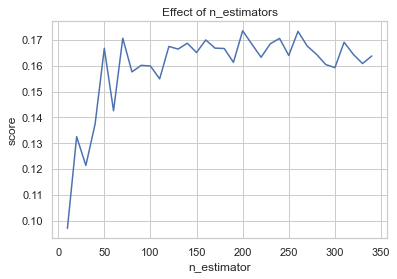

In [218]:
# Scale the data to be between -1 and 1
rf = RandomForestRegressor(n_jobs=-1)

# Try different numbers of n_estimators - this will take a minute or so
estimators = np.arange(10, 343, 10)
scores = []
for n in estimators:
    rf.set_params(n_estimators=n)
    rf.fit(train_X, train_y)
    scores.append(rf.score(test_X, test_y))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [219]:
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
rf_score = cross_val_score(rf, x, y, cv=kfolds, scoring='neg_mean_squared_error')
rf_rmse =  np.sqrt(-rf_score.mean())
# Printing out Ridge Score and STD
print("Random Forest Model RMSE: ", rf_rmse)
print("Random Forest Model STD: ", rf_score.std())

Random Forest Model RMSE:  98.55023330113362
Random Forest Model STD:  541.7745293525619


In [220]:
preds_train=rf.predict(train_X)
preds1 = rf.predict(test_X)

Evaluation on test data
RMSE: 97.55
R2: 0.16
Adjusted R2: 0.16


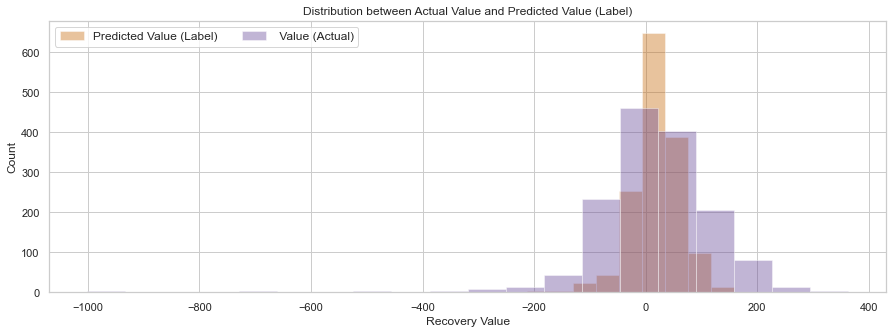

In [221]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_random_forest = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_random_forest["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_random_forest["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("")

plt.legend(( 'Predicted Value (Label)',' Value (Actual)'), ncol=2, loc='upper left', fontsize=12)



In [222]:
output_data_random_forest.head(50)

output_data_random_forest["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_random_forest["Prediction"]]
output_data_random_forest["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_random_forest["Real"]]

In [223]:
output_data_random_forest.head(50)
comparison_column = np.where(output_data_random_forest["Prediction_sign"] == output_data_random_forest["Real_sign"], True, False)

In [224]:
count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

We have a total of True values :  917


In [225]:
print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

Accuracy of True values compared to the total observations : 0.6212737127371274


$\textbf{Light GBM}$

In [43]:

lightgbm = make_pipeline(RobustScaler(),
                        LGBMRegressor(objective='regression',num_leaves=5,
                                      learning_rate=0.05, n_estimators=720,
                                      max_bin = 55, bagging_fraction = 0.8,
                                      bagging_freq = 5, feature_fraction = 0.2319,
                                      feature_fraction_seed=9, bagging_seed=9,
                                      min_data_in_leaf =6, 
                                      min_sum_hessian_in_leaf = 11))

# Printing out LightGBM Score and STD
lightgbm_score = cross_val_score(lightgbm, x, y, cv=kfolds, scoring='neg_mean_squared_error')
lightgbm_rmse = np.sqrt(-lightgbm_score.mean())
print("LIGHTGBM RMSE: ", lightgbm_rmse)
print("LIGHTGBM STD: ", lightgbm_score.std())

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11

In [44]:
# Training Model for later
lightgbm.fit(train_X, train_y)

[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


Pipeline(steps=[('robustscaler', RobustScaler()),
                ('lgbmregressor',
                 LGBMRegressor(bagging_fraction=0.8, bagging_freq=5,
                               bagging_seed=9, feature_fraction=0.2319,
                               feature_fraction_seed=9, learning_rate=0.05,
                               max_bin=55, min_data_in_leaf=6,
                               min_sum_hessian_in_leaf=11, n_estimators=720,
                               num_leaves=5, objective='regression'))])

In [45]:
preds_train=lightgbm.predict(train_X)
preds1 = lightgbm.predict(test_X)

Evaluation on test data
RMSE: 97.58
R2: 0.05
Adjusted R2: 0.05


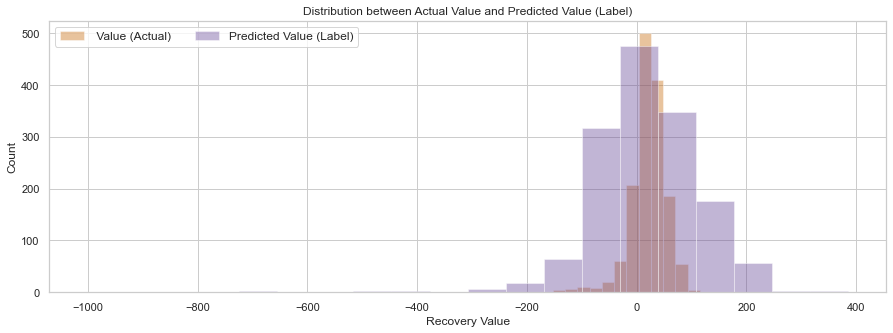

In [46]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_lightgbm = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_lightgbm["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_lightgbm["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend(('Predicted Value (Label)',' Value (Actual)'), ncol=2, loc='upper left', fontsize=12)



In [47]:
output_data_lightgbm.head(50)

output_data_lightgbm["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_lightgbm["Prediction"]]
output_data_lightgbm["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_lightgbm["Real"]]

In [48]:
output_data_lightgbm.head(50)
comparison_column = np.where(output_data_lightgbm["Prediction_sign"] == output_data_lightgbm["Real_sign"], True, False)

In [49]:
count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

We have a total of True values :  863


In [50]:
print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

Accuracy of True values compared to the total observations : 0.5846883468834688


$\textbf{Ridge Regression}$

In [71]:
# Parameters for models
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [0.00005, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]


ridge = make_pipeline(RobustScaler(), RidgeCV(alphas = alphas_alt, cv=kfolds))
ridge_score = cross_val_score(ridge, x, y, cv=kfolds, scoring='neg_mean_squared_error')
ridge_rmse =  np.sqrt(-ridge_score.mean())
# Printing out Ridge Score and STD
print("RIDGE RMSE: ", ridge_rmse)
print("RIDGE STD: ", ridge_score.std())

RIDGE RMSE:  104.53530588916666
RIDGE STD:  675.133800964236


In [72]:
ridge.fit(train_X,train_y)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('ridgecv',
                 RidgeCV(alphas=array([14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2, 15.3, 15.4, 15.5]),
                         cv=KFold(n_splits=5, random_state=42, shuffle=True)))])

In [73]:
preds_train=lightgbm.predict(train_X)
preds1 = lightgbm.predict(test_X)

Evaluation on test data
RMSE: 97.58
R2: 0.05
Adjusted R2: 0.05


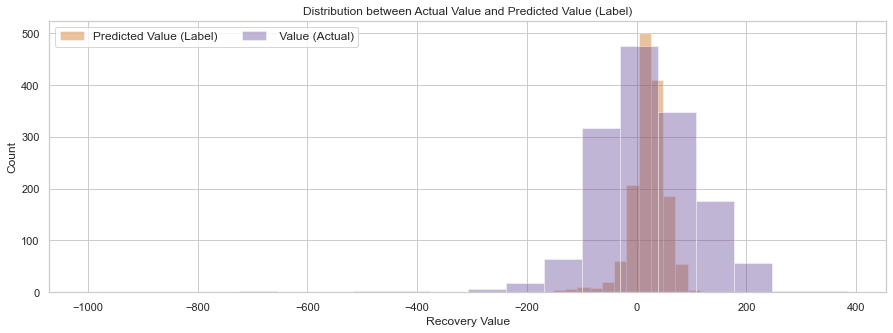

In [74]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_ridge_regression = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_ridge_regression["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_ridge_regression["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend(( 'Predicted Value (Label)',' Value (Actual)'), ncol=2, loc='upper left', fontsize=12)



In [55]:
output_data_ridge_regression["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_ridge_regression["Prediction"]]
output_data_ridge_regression["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_ridge_regression["Real"]]

In [56]:
comparison_column = np.where(output_data_ridge_regression["Prediction_sign"] == output_data_ridge_regression["Real_sign"], True, False)

In [57]:
count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

We have a total of True values :  863


In [58]:
print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

Accuracy of True values compared to the total observations : 0.5846883468834688


$\textbf{Lasso Regression}$

In [59]:
# Lasso Model
lasso = make_pipeline(RobustScaler(), LassoCV(max_iter=1e7, alphas = alphas2, random_state = 42, cv=kfolds))

# Printing Lasso Score with Cross-Validation
lasso_score = cross_val_score(lasso, x, y, cv=kfolds, scoring='neg_mean_squared_error')
lasso_rmse = np.sqrt(-lasso_score.mean())
print("LASSO RMSE: ", lasso_rmse)
print("LASSO STD: ", lasso_score.std())

LASSO RMSE:  104.53584888852194
LASSO STD:  675.0394228991846


In [60]:
#train_X, test_X, train_y, y_test
lasso.fit(train_X,train_y)

Pipeline(steps=[('robustscaler', RobustScaler()),
                ('lassocv',
                 LassoCV(alphas=[5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                 0.0006, 0.0007, 0.0008],
                         cv=KFold(n_splits=5, random_state=42, shuffle=True),
                         max_iter=10000000.0, random_state=42))])

In [61]:
preds_train=lasso.predict(train_X)
preds1 = lasso.predict(test_X)

Evaluation on test data
RMSE: 99.63
R2: 0.01
Adjusted R2: 0.01


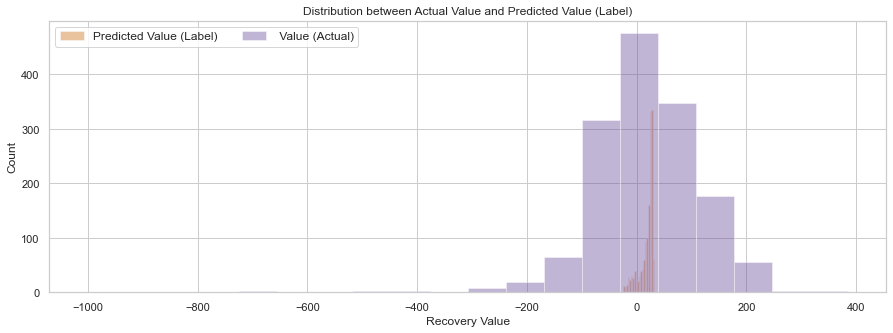

In [69]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_lasso_regression = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_lasso_regression["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_lasso_regression["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend(('Predicted Value (Label)',' Value (Actual)'), ncol=2, loc='upper left', fontsize=12)



In [63]:
output_data_lasso_regression["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_lasso_regression["Prediction"]]
output_data_lasso_regression["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_lasso_regression["Real"]]

In [64]:
comparison_column = np.where(output_data_lasso_regression["Prediction_sign"] == output_data_lasso_regression["Real_sign"], True, False)

In [65]:
count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

We have a total of True values :  843


In [66]:
print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

Accuracy of True values compared to the total observations : 0.5711382113821138


$\textbf{Stacked Models}$

In [140]:
stack_gen = StackingCVRegressor(regressors=(modelCB,rf,ridge), 
                               meta_regressor=rf,
                               use_features_in_secondary=True)

stack_score = cross_val_score(stack_gen, x, y, cv=kfolds, scoring='neg_mean_squared_error')
stack_rmse = np.sqrt(-stack_score.mean())
print("STACK RMSE: ", stack_rmse)
print("STACK STD: ", stack_score.std())

STACK RMSE:  100.82210497453534
STACK STD:  593.97568704308


In [143]:
#Training Model for later
stack_gen.fit(train_X,train_y)

StackingCVRegressor(meta_regressor=RandomForestRegressor(n_estimators=340,
                                                         n_jobs=-1),
                    regressors=(<catboost.core.CatBoostRegressor object at 0x0000023E433F99A0>,
                                RandomForestRegressor(n_estimators=340,
                                                      n_jobs=-1),
                                Pipeline(steps=[('robustscaler',
                                                 RobustScaler()),
                                                ('ridgecv',
                                                 RidgeCV(alphas=array([14.5, 14.6, 14.7, 14.8, 14.9, 15. , 15.1, 15.2, 15.3, 15.4, 15.5]),
                                                         cv=KFold(n_splits=5, random_state=42, shuffle=True)))])),
                    use_features_in_secondary=True)

In [144]:
preds_train=stack_gen.predict(train_X)
preds1 = stack_gen.predict(test_X)

Evaluation on test data
RMSE: 101.99
R2: -0.06
Adjusted R2: -0.06


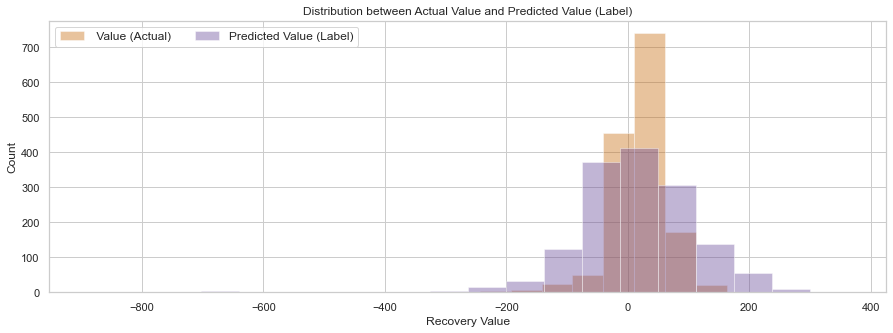

In [145]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_stacked_model = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_stacked_model["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_stacked_model["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend((' Value (Actual)', 'Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)



In [146]:
output_data_stacked_model["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_stacked_model["Prediction"]]
output_data_stacked_model["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_stacked_model["Real"]]

In [147]:
comparison_column = np.where(output_data_stacked_model["Prediction_sign"] == output_data_stacked_model["Real_sign"], True, False)

In [148]:
count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

We have a total of True values :  889


In [149]:
print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

Accuracy of True values compared to the total observations : 0.6023035230352304


$\textbf{Now we are going to add the Uplift feature i=1,2,3}$

* Random Forest Regression 
* CatBoost Regression

In [140]:
##### Add Uplift 1 
x = all_data.drop([columns_data[1],columns_data[2],columns_data[3],columns_data[4],columns_data[5],columns_data[6],columns_data[8],columns_data[9],columns_data[14],columns_data[15],columns_data[16],columns_data[17]], axis=1)
x.head()

,Uplift Account 1 (€/MWh),RES,Load,Mandatory Hydro,Total FRR
2021-08-15 00:00:00,2.738548,1820.0,5515.5,50.0,914.0
2021-08-15 01:00:00,2.375837,1930.0,5299.0,50.0,939.0
2021-08-15 02:00:00,2.143069,2000.0,5127.5,50.0,949.0
2021-08-15 03:00:00,2.043232,2035.0,5038.0,63.0,939.0
2021-08-15 04:00:00,2.227400,2055.0,4951.5,76.0,1079.0


In [141]:
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score

train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.25)

In [142]:
train_X.head()

,Uplift Account 1 (€/MWh),RES,Load,Mandatory Hydro,Total FRR
2022-03-19 06:00:00,7.144501,3225.0,6205.5,118.0,1646.0
2021-12-07 04:00:00,4.849200,2070.0,4669.5,89.0,1084.0
2021-11-10 16:00:00,9.120419,2890.0,6050.0,178.5,1904.0
2021-10-24 20:00:00,6.664084,2465.0,5394.0,202.5,1754.0
2021-12-17 09:00:00,10.225226,2445.0,7520.0,1601.5,1369.0


In [143]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

num_columns = train_X.columns

ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

train_X = ct.fit_transform(train_X)
test_X = ct.transform(test_X)

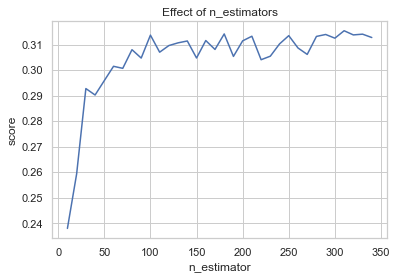

In [79]:
# Scale the data to be between -1 and 1
rf = RandomForestRegressor(n_jobs=-1)

# Try different numbers of n_estimators - this will take a minute or so
estimators = np.arange(10, 343, 10)
scores = []
for n in estimators:
    rf.set_params(n_estimators=n)
    rf.fit(train_X, train_y)
    scores.append(rf.score(test_X, test_y))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [80]:
rf_score = cross_val_score(rf, x, y, cv=kfolds, scoring='neg_mean_squared_error')
rf_rmse =  np.sqrt(-rf_score.mean())
# Printing out Ridge Score and STD
print("Random Forest Model RMSE: ", rf_rmse)
print("Random Forest Model STD: ", rf_score.std())

Random Forest Model RMSE:  88.768742202417
Random Forest Model STD:  525.4172149726762


In [81]:
preds_train=rf.predict(train_X)
preds1 = rf.predict(test_X)

Evaluation on test data
RMSE: 82.16
R2: 0.31
Adjusted R2: 0.31


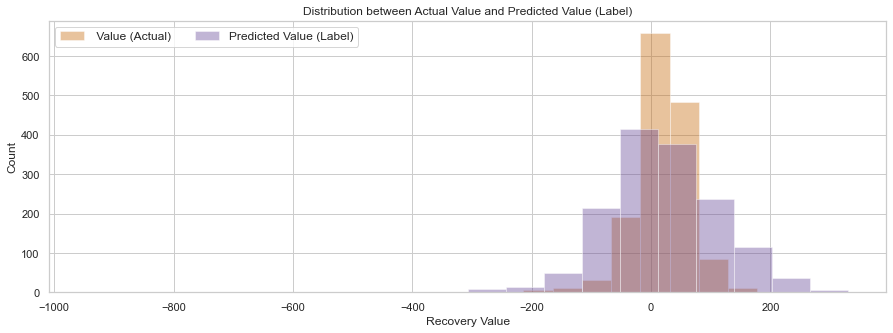

In [82]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_random_forest = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_random_forest["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_random_forest["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend((' Value (Actual)', 'Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)



In [83]:
output_data_random_forest.head(50)

output_data_random_forest["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_random_forest["Prediction"]]
output_data_random_forest["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_random_forest["Real"]]

In [84]:
output_data_random_forest.head(50)
comparison_column = np.where(output_data_random_forest["Prediction_sign"] == output_data_random_forest["Real_sign"], True, False)

In [85]:
count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

We have a total of True values :  983


In [86]:
print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

Accuracy of True values compared to the total observations : 0.6659891598915989


In [ ]:
##### Add Uplift 1 
x = all_data.drop([columns_data[1],columns_data[2],columns_data[3],columns_data[4],columns_data[5],columns_data[6],columns_data[8],columns_data[9],columns_data[14],columns_data[15],columns_data[16],columns_data[17]], axis=1)
x.head()



In [ ]:
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score


train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.25)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

num_columns = train_X.columns

ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

train_X = ct.fit_transform(train_X)
test_X = ct.transform(test_X)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

RMS:  92.81727547479277


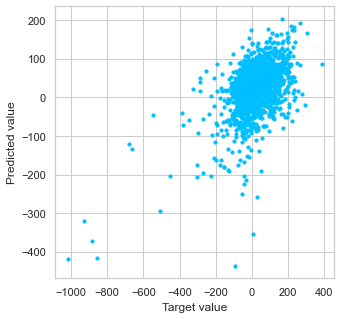

In [144]:
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error

train_pool = Pool(train_X, 
                  train_y)
test_pool = Pool(test_X) 


####{'colsample_bylevel': 4, 'learning_rate': 5, 'max_depth': 4}, 

#### Grid Search 
# {'depth': 10, 'iterations': 100, 'learning_rate': 0.1}
modelCB = CatBoostRegressor(iterations=8000,
                           depth=4,
                           learning_rate=0.08,
                           loss_function='RMSE',
                           silent=True)

modelCB.fit(train_pool,plot=True)

preds1 = modelCB.predict(test_pool)

preds_train=modelCB.predict(train_pool)
# evaluate predictions
rms1 = mean_squared_error(test_y, preds1, squared=False) #np.sqrt(np.mean((preds1 - test_y) ** 2))
print("RMS: ", rms1)
#print(preds1)



plt.figure(figsize=(5,5))
plt.scatter(test_y, preds1, s=10, color="deepskyblue")
plt.xlabel("Target value")
plt.ylabel("Predicted value")
print(train_pool)

Accuracy is :  -228.47828248269127


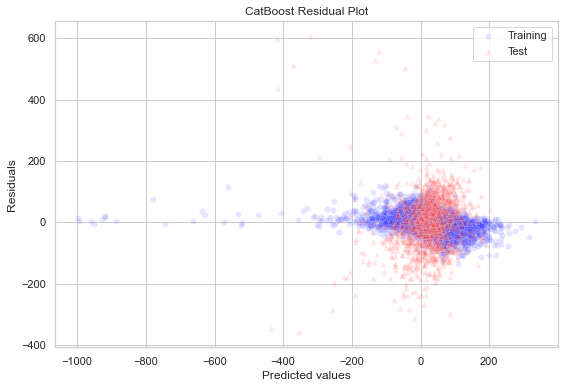

Evaluation on test data
RMSE: 92.82
R2: 0.27
Adjusted R2: 0.27
We have a total of True values :  959
Accuracy of True values compared to the total observations : 0.6497289972899729
Test set evaluation:
_____________________________________
MAE: 67.61510119889901
MSE: 8615.046626563566
RMSE: 92.81727547479277
R2 Square 0.27040744737736266
__________________________________
Train set evaluation:
_____________________________________
MAE: 21.994375583174044
MSE: 871.6180704239673
RMSE: 29.523178528470936
R2 Square 0.9193351119902758
__________________________________
Learning rate set to 0.052543
0:	learn: 108.7124798	total: 4.32ms	remaining: 4.31s
1:	learn: 107.9898725	total: 9.84ms	remaining: 4.91s
2:	learn: 107.2643800	total: 16ms	remaining: 5.31s
3:	learn: 106.5586714	total: 20.5ms	remaining: 5.11s
4:	learn: 105.9531509	total: 23.9ms	remaining: 4.77s
5:	learn: 105.2960848	total: 27.5ms	remaining: 4.56s
6:	learn: 104.7005104	total: 31ms	remaining: 4.39s
7:	learn: 104.1613499	total: 34.

148:	learn: 85.2966894	total: 639ms	remaining: 3.65s
149:	learn: 85.2320613	total: 645ms	remaining: 3.65s
150:	learn: 85.1958107	total: 650ms	remaining: 3.65s
151:	learn: 85.1505766	total: 661ms	remaining: 3.69s
152:	learn: 85.1050790	total: 666ms	remaining: 3.69s
153:	learn: 85.0189656	total: 671ms	remaining: 3.69s
154:	learn: 84.9628616	total: 676ms	remaining: 3.69s
155:	learn: 84.9179014	total: 682ms	remaining: 3.69s
156:	learn: 84.8635635	total: 689ms	remaining: 3.7s
157:	learn: 84.8044530	total: 694ms	remaining: 3.7s
158:	learn: 84.7493944	total: 702ms	remaining: 3.71s
159:	learn: 84.7056579	total: 706ms	remaining: 3.71s
160:	learn: 84.6431816	total: 714ms	remaining: 3.72s
161:	learn: 84.5963683	total: 720ms	remaining: 3.72s
162:	learn: 84.5513770	total: 724ms	remaining: 3.72s
163:	learn: 84.4999563	total: 732ms	remaining: 3.73s
164:	learn: 84.4535389	total: 736ms	remaining: 3.73s
165:	learn: 84.4170632	total: 743ms	remaining: 3.73s
166:	learn: 84.3447328	total: 748ms	remaining: 3

315:	learn: 77.7381082	total: 1.64s	remaining: 3.55s
316:	learn: 77.7172673	total: 1.65s	remaining: 3.55s
317:	learn: 77.6919485	total: 1.65s	remaining: 3.54s
318:	learn: 77.6505702	total: 1.66s	remaining: 3.54s
319:	learn: 77.5979263	total: 1.67s	remaining: 3.54s
320:	learn: 77.5429533	total: 1.67s	remaining: 3.53s
321:	learn: 77.5022188	total: 1.68s	remaining: 3.54s
322:	learn: 77.4630976	total: 1.69s	remaining: 3.53s
323:	learn: 77.4288700	total: 1.69s	remaining: 3.53s
324:	learn: 77.3943809	total: 1.7s	remaining: 3.52s
325:	learn: 77.3736197	total: 1.7s	remaining: 3.52s
326:	learn: 77.3298084	total: 1.71s	remaining: 3.53s
327:	learn: 77.2931936	total: 1.72s	remaining: 3.52s
328:	learn: 77.2680908	total: 1.73s	remaining: 3.52s
329:	learn: 77.2450800	total: 1.73s	remaining: 3.51s
330:	learn: 77.2068037	total: 1.73s	remaining: 3.5s
331:	learn: 77.1575023	total: 1.74s	remaining: 3.49s
332:	learn: 77.1228202	total: 1.74s	remaining: 3.48s
333:	learn: 77.0741145	total: 1.74s	remaining: 3.

486:	learn: 72.6002313	total: 2.46s	remaining: 2.6s
487:	learn: 72.5802995	total: 2.47s	remaining: 2.59s
488:	learn: 72.5554003	total: 2.47s	remaining: 2.58s
489:	learn: 72.5344159	total: 2.48s	remaining: 2.58s
490:	learn: 72.5090244	total: 2.48s	remaining: 2.57s
491:	learn: 72.4938758	total: 2.49s	remaining: 2.57s
492:	learn: 72.4662984	total: 2.49s	remaining: 2.56s
493:	learn: 72.4548100	total: 2.5s	remaining: 2.56s
494:	learn: 72.4324004	total: 2.51s	remaining: 2.56s
495:	learn: 72.4110705	total: 2.52s	remaining: 2.56s
496:	learn: 72.3818956	total: 2.52s	remaining: 2.55s
497:	learn: 72.3493424	total: 2.53s	remaining: 2.55s
498:	learn: 72.3310466	total: 2.55s	remaining: 2.56s
499:	learn: 72.3170493	total: 2.55s	remaining: 2.55s
500:	learn: 72.2881435	total: 2.56s	remaining: 2.55s
501:	learn: 72.2601390	total: 2.57s	remaining: 2.55s
502:	learn: 72.2330657	total: 2.57s	remaining: 2.54s
503:	learn: 72.2114069	total: 2.58s	remaining: 2.54s
504:	learn: 72.1974284	total: 2.58s	remaining: 2

642:	learn: 68.9566285	total: 3.49s	remaining: 1.94s
643:	learn: 68.9463189	total: 3.49s	remaining: 1.93s
644:	learn: 68.9364408	total: 3.5s	remaining: 1.93s
645:	learn: 68.9151124	total: 3.51s	remaining: 1.92s
646:	learn: 68.8916616	total: 3.51s	remaining: 1.92s
647:	learn: 68.8652633	total: 3.52s	remaining: 1.91s
648:	learn: 68.8520957	total: 3.52s	remaining: 1.91s
649:	learn: 68.8228049	total: 3.53s	remaining: 1.9s
650:	learn: 68.8007525	total: 3.54s	remaining: 1.9s
651:	learn: 68.7784816	total: 3.54s	remaining: 1.89s
652:	learn: 68.7733242	total: 3.55s	remaining: 1.89s
653:	learn: 68.7547209	total: 3.56s	remaining: 1.88s
654:	learn: 68.7296718	total: 3.56s	remaining: 1.88s
655:	learn: 68.7105044	total: 3.57s	remaining: 1.87s
656:	learn: 68.6894319	total: 3.58s	remaining: 1.87s
657:	learn: 68.6754667	total: 3.58s	remaining: 1.86s
658:	learn: 68.6549002	total: 3.59s	remaining: 1.85s
659:	learn: 68.6328663	total: 3.59s	remaining: 1.85s
660:	learn: 68.6148043	total: 3.6s	remaining: 1.8

812:	learn: 65.6681019	total: 4.68s	remaining: 1.07s
813:	learn: 65.6528031	total: 4.68s	remaining: 1.07s
814:	learn: 65.6286663	total: 4.69s	remaining: 1.06s
815:	learn: 65.6162377	total: 4.7s	remaining: 1.06s
816:	learn: 65.5970308	total: 4.71s	remaining: 1.05s
817:	learn: 65.5802579	total: 4.72s	remaining: 1.05s
818:	learn: 65.5607962	total: 4.72s	remaining: 1.04s
819:	learn: 65.5481782	total: 4.73s	remaining: 1.04s
820:	learn: 65.5282427	total: 4.74s	remaining: 1.03s
821:	learn: 65.5038096	total: 4.74s	remaining: 1.03s
822:	learn: 65.4827941	total: 4.75s	remaining: 1.02s
823:	learn: 65.4732158	total: 4.75s	remaining: 1.01s
824:	learn: 65.4594782	total: 4.76s	remaining: 1.01s
825:	learn: 65.4403488	total: 4.77s	remaining: 1s
826:	learn: 65.4187676	total: 4.78s	remaining: 1000ms
827:	learn: 65.4149451	total: 4.78s	remaining: 994ms
828:	learn: 65.3817131	total: 4.79s	remaining: 989ms
829:	learn: 65.3659061	total: 4.8s	remaining: 983ms
830:	learn: 65.3628210	total: 4.8s	remaining: 977m

971:	learn: 63.0225777	total: 5.67s	remaining: 163ms
972:	learn: 63.0004863	total: 5.68s	remaining: 158ms
973:	learn: 62.9840651	total: 5.68s	remaining: 152ms
974:	learn: 62.9689369	total: 5.69s	remaining: 146ms
975:	learn: 62.9554827	total: 5.7s	remaining: 140ms
976:	learn: 62.9426226	total: 5.7s	remaining: 134ms
977:	learn: 62.9198214	total: 5.71s	remaining: 128ms
978:	learn: 62.8985052	total: 5.72s	remaining: 123ms
979:	learn: 62.8814274	total: 5.72s	remaining: 117ms
980:	learn: 62.8665705	total: 5.73s	remaining: 111ms
981:	learn: 62.8523457	total: 5.74s	remaining: 105ms
982:	learn: 62.8288765	total: 5.75s	remaining: 99.4ms
983:	learn: 62.8175518	total: 5.76s	remaining: 93.7ms
984:	learn: 62.8016319	total: 5.76s	remaining: 87.8ms
985:	learn: 62.7956009	total: 5.77s	remaining: 82ms
986:	learn: 62.7892011	total: 5.78s	remaining: 76.1ms
987:	learn: 62.7738851	total: 5.78s	remaining: 70.2ms
988:	learn: 62.7566312	total: 5.79s	remaining: 64.4ms
989:	learn: 62.7439792	total: 5.79s	remaini

161:	learn: 85.0374815	total: 607ms	remaining: 3.14s
162:	learn: 84.9613972	total: 611ms	remaining: 3.13s
163:	learn: 84.9136377	total: 614ms	remaining: 3.13s
164:	learn: 84.8726981	total: 618ms	remaining: 3.13s
165:	learn: 84.8360122	total: 622ms	remaining: 3.12s
166:	learn: 84.7903774	total: 626ms	remaining: 3.12s
167:	learn: 84.7474666	total: 630ms	remaining: 3.12s
168:	learn: 84.6978068	total: 634ms	remaining: 3.12s
169:	learn: 84.6428913	total: 637ms	remaining: 3.11s
170:	learn: 84.5921227	total: 641ms	remaining: 3.1s
171:	learn: 84.5314506	total: 645ms	remaining: 3.1s
172:	learn: 84.4625016	total: 648ms	remaining: 3.1s
173:	learn: 84.4227589	total: 652ms	remaining: 3.1s
174:	learn: 84.3701231	total: 657ms	remaining: 3.1s
175:	learn: 84.2805396	total: 661ms	remaining: 3.1s
176:	learn: 84.2223134	total: 665ms	remaining: 3.09s
177:	learn: 84.1783043	total: 669ms	remaining: 3.09s
178:	learn: 84.1198215	total: 673ms	remaining: 3.09s
179:	learn: 84.0609020	total: 679ms	remaining: 3.09s

346:	learn: 76.6932544	total: 1.28s	remaining: 2.41s
347:	learn: 76.6611926	total: 1.28s	remaining: 2.41s
348:	learn: 76.6148648	total: 1.29s	remaining: 2.4s
349:	learn: 76.5866283	total: 1.29s	remaining: 2.4s
350:	learn: 76.5362679	total: 1.3s	remaining: 2.4s
351:	learn: 76.5019722	total: 1.3s	remaining: 2.39s
352:	learn: 76.4692833	total: 1.3s	remaining: 2.39s
353:	learn: 76.4481327	total: 1.31s	remaining: 2.38s
354:	learn: 76.4285249	total: 1.31s	remaining: 2.38s
355:	learn: 76.4049312	total: 1.31s	remaining: 2.38s
356:	learn: 76.3720925	total: 1.32s	remaining: 2.37s
357:	learn: 76.3503664	total: 1.32s	remaining: 2.37s
358:	learn: 76.3284523	total: 1.33s	remaining: 2.37s
359:	learn: 76.2975102	total: 1.33s	remaining: 2.36s
360:	learn: 76.2786179	total: 1.33s	remaining: 2.36s
361:	learn: 76.2559098	total: 1.34s	remaining: 2.36s
362:	learn: 76.2240422	total: 1.34s	remaining: 2.35s
363:	learn: 76.1883359	total: 1.34s	remaining: 2.35s
364:	learn: 76.1630547	total: 1.35s	remaining: 2.35s

534:	learn: 71.1884198	total: 2.11s	remaining: 1.84s
535:	learn: 71.1691192	total: 2.12s	remaining: 1.83s
536:	learn: 71.1553709	total: 2.13s	remaining: 1.83s
537:	learn: 71.1302246	total: 2.13s	remaining: 1.83s
538:	learn: 71.1088336	total: 2.13s	remaining: 1.82s
539:	learn: 71.0887041	total: 2.14s	remaining: 1.82s
540:	learn: 71.0686419	total: 2.14s	remaining: 1.82s
541:	learn: 71.0390136	total: 2.15s	remaining: 1.81s
542:	learn: 71.0155326	total: 2.15s	remaining: 1.81s
543:	learn: 70.9789295	total: 2.15s	remaining: 1.81s
544:	learn: 70.9501397	total: 2.16s	remaining: 1.8s
545:	learn: 70.9312103	total: 2.16s	remaining: 1.8s
546:	learn: 70.9046962	total: 2.17s	remaining: 1.79s
547:	learn: 70.8780113	total: 2.17s	remaining: 1.79s
548:	learn: 70.8518176	total: 2.17s	remaining: 1.79s
549:	learn: 70.8308135	total: 2.18s	remaining: 1.78s
550:	learn: 70.8006967	total: 2.18s	remaining: 1.78s
551:	learn: 70.7800050	total: 2.19s	remaining: 1.77s
552:	learn: 70.7546865	total: 2.19s	remaining: 1

720:	learn: 67.0640752	total: 2.94s	remaining: 1.14s
721:	learn: 67.0393986	total: 2.94s	remaining: 1.13s
722:	learn: 67.0207370	total: 2.95s	remaining: 1.13s
723:	learn: 67.0021268	total: 2.95s	remaining: 1.13s
724:	learn: 66.9801349	total: 2.96s	remaining: 1.12s
725:	learn: 66.9664668	total: 2.96s	remaining: 1.12s
726:	learn: 66.9531333	total: 2.97s	remaining: 1.11s
727:	learn: 66.9313211	total: 2.97s	remaining: 1.11s
728:	learn: 66.9213618	total: 2.98s	remaining: 1.11s
729:	learn: 66.9096228	total: 2.98s	remaining: 1.1s
730:	learn: 66.8948056	total: 2.98s	remaining: 1.1s
731:	learn: 66.8748456	total: 2.99s	remaining: 1.09s
732:	learn: 66.8602920	total: 2.99s	remaining: 1.09s
733:	learn: 66.8434142	total: 3s	remaining: 1.09s
734:	learn: 66.8246708	total: 3s	remaining: 1.08s
735:	learn: 66.8181805	total: 3.01s	remaining: 1.08s
736:	learn: 66.7893953	total: 3.01s	remaining: 1.07s
737:	learn: 66.7626079	total: 3.02s	remaining: 1.07s
738:	learn: 66.7455269	total: 3.02s	remaining: 1.07s
7

897:	learn: 64.0898877	total: 3.61s	remaining: 410ms
898:	learn: 64.0598218	total: 3.61s	remaining: 406ms
899:	learn: 64.0417774	total: 3.62s	remaining: 402ms
900:	learn: 64.0069499	total: 3.62s	remaining: 398ms
901:	learn: 63.9935786	total: 3.62s	remaining: 394ms
902:	learn: 63.9812309	total: 3.63s	remaining: 390ms
903:	learn: 63.9644550	total: 3.63s	remaining: 386ms
904:	learn: 63.9520464	total: 3.63s	remaining: 382ms
905:	learn: 63.9440824	total: 3.64s	remaining: 378ms
906:	learn: 63.9322163	total: 3.64s	remaining: 374ms
907:	learn: 63.9112456	total: 3.65s	remaining: 370ms
908:	learn: 63.9002636	total: 3.65s	remaining: 366ms
909:	learn: 63.8872303	total: 3.66s	remaining: 362ms
910:	learn: 63.8810876	total: 3.66s	remaining: 358ms
911:	learn: 63.8621274	total: 3.66s	remaining: 353ms
912:	learn: 63.8468231	total: 3.67s	remaining: 349ms
913:	learn: 63.8329545	total: 3.67s	remaining: 345ms
914:	learn: 63.8182284	total: 3.67s	remaining: 341ms
915:	learn: 63.8082489	total: 3.68s	remaining:

52:	learn: 90.0739432	total: 185ms	remaining: 3.3s
53:	learn: 89.9547333	total: 188ms	remaining: 3.3s
54:	learn: 89.8165369	total: 192ms	remaining: 3.29s
55:	learn: 89.6738870	total: 196ms	remaining: 3.3s
56:	learn: 89.5195499	total: 200ms	remaining: 3.3s
57:	learn: 89.3830630	total: 203ms	remaining: 3.3s
58:	learn: 89.2641728	total: 207ms	remaining: 3.29s
59:	learn: 89.1799551	total: 211ms	remaining: 3.31s
60:	learn: 89.0948415	total: 215ms	remaining: 3.3s
61:	learn: 88.9742785	total: 218ms	remaining: 3.3s
62:	learn: 88.8266833	total: 222ms	remaining: 3.29s
63:	learn: 88.7088628	total: 225ms	remaining: 3.29s
64:	learn: 88.5581116	total: 229ms	remaining: 3.3s
65:	learn: 88.4650362	total: 233ms	remaining: 3.3s
66:	learn: 88.3629777	total: 236ms	remaining: 3.29s
67:	learn: 88.2618933	total: 240ms	remaining: 3.28s
68:	learn: 88.1535989	total: 243ms	remaining: 3.28s
69:	learn: 88.0873432	total: 246ms	remaining: 3.27s
70:	learn: 87.9782374	total: 250ms	remaining: 3.27s
71:	learn: 87.8842432

215:	learn: 79.2757358	total: 865ms	remaining: 3.14s
216:	learn: 79.2486094	total: 870ms	remaining: 3.14s
217:	learn: 79.2167624	total: 876ms	remaining: 3.14s
218:	learn: 79.2040410	total: 881ms	remaining: 3.14s
219:	learn: 79.1468787	total: 893ms	remaining: 3.16s
220:	learn: 79.1004071	total: 898ms	remaining: 3.16s
221:	learn: 79.0450500	total: 903ms	remaining: 3.16s
222:	learn: 78.9980623	total: 910ms	remaining: 3.17s
223:	learn: 78.9518173	total: 914ms	remaining: 3.17s
224:	learn: 78.9055106	total: 923ms	remaining: 3.18s
225:	learn: 78.8413552	total: 928ms	remaining: 3.18s
226:	learn: 78.7918244	total: 934ms	remaining: 3.18s
227:	learn: 78.7093043	total: 941ms	remaining: 3.19s
228:	learn: 78.6624038	total: 947ms	remaining: 3.19s
229:	learn: 78.6400970	total: 955ms	remaining: 3.2s
230:	learn: 78.5677568	total: 960ms	remaining: 3.19s
231:	learn: 78.5146995	total: 970ms	remaining: 3.21s
232:	learn: 78.4790132	total: 975ms	remaining: 3.21s
233:	learn: 78.4390949	total: 984ms	remaining: 

399:	learn: 72.3312600	total: 1.7s	remaining: 2.55s
400:	learn: 72.2949613	total: 1.71s	remaining: 2.55s
401:	learn: 72.2607301	total: 1.71s	remaining: 2.54s
402:	learn: 72.2332016	total: 1.71s	remaining: 2.54s
403:	learn: 72.2064493	total: 1.72s	remaining: 2.53s
404:	learn: 72.1806633	total: 1.72s	remaining: 2.53s
405:	learn: 72.1483355	total: 1.72s	remaining: 2.52s
406:	learn: 72.1106492	total: 1.73s	remaining: 2.52s
407:	learn: 72.0873346	total: 1.73s	remaining: 2.51s
408:	learn: 72.0567975	total: 1.74s	remaining: 2.51s
409:	learn: 72.0241520	total: 1.74s	remaining: 2.5s
410:	learn: 72.0004797	total: 1.74s	remaining: 2.5s
411:	learn: 71.9618502	total: 1.75s	remaining: 2.49s
412:	learn: 71.9328452	total: 1.75s	remaining: 2.49s
413:	learn: 71.8990669	total: 1.75s	remaining: 2.48s
414:	learn: 71.8769260	total: 1.76s	remaining: 2.48s
415:	learn: 71.8485480	total: 1.76s	remaining: 2.47s
416:	learn: 71.8108170	total: 1.76s	remaining: 2.47s
417:	learn: 71.7897895	total: 1.77s	remaining: 2.

591:	learn: 67.3827685	total: 2.39s	remaining: 1.64s
592:	learn: 67.3516257	total: 2.39s	remaining: 1.64s
593:	learn: 67.3290049	total: 2.39s	remaining: 1.64s
594:	learn: 67.3011461	total: 2.4s	remaining: 1.63s
595:	learn: 67.2905332	total: 2.4s	remaining: 1.63s
596:	learn: 67.2655202	total: 2.4s	remaining: 1.62s
597:	learn: 67.2540342	total: 2.41s	remaining: 1.62s
598:	learn: 67.2307430	total: 2.41s	remaining: 1.61s
599:	learn: 67.2121457	total: 2.42s	remaining: 1.61s
600:	learn: 67.1897835	total: 2.42s	remaining: 1.61s
601:	learn: 67.1573433	total: 2.42s	remaining: 1.6s
602:	learn: 67.1324695	total: 2.43s	remaining: 1.6s
603:	learn: 67.1128097	total: 2.43s	remaining: 1.59s
604:	learn: 67.0910816	total: 2.44s	remaining: 1.59s
605:	learn: 67.0696270	total: 2.44s	remaining: 1.59s
606:	learn: 67.0491545	total: 2.44s	remaining: 1.58s
607:	learn: 67.0366086	total: 2.45s	remaining: 1.58s
608:	learn: 67.0164509	total: 2.45s	remaining: 1.57s
609:	learn: 66.9953549	total: 2.46s	remaining: 1.57

767:	learn: 63.7450879	total: 3.21s	remaining: 970ms
768:	learn: 63.7275113	total: 3.22s	remaining: 966ms
769:	learn: 63.7127751	total: 3.22s	remaining: 963ms
770:	learn: 63.6927582	total: 3.23s	remaining: 958ms
771:	learn: 63.6740849	total: 3.23s	remaining: 955ms
772:	learn: 63.6582456	total: 3.24s	remaining: 950ms
773:	learn: 63.6367191	total: 3.24s	remaining: 946ms
774:	learn: 63.6282137	total: 3.25s	remaining: 943ms
775:	learn: 63.6101339	total: 3.25s	remaining: 938ms
776:	learn: 63.5957054	total: 3.25s	remaining: 934ms
777:	learn: 63.5657845	total: 3.26s	remaining: 930ms
778:	learn: 63.5548883	total: 3.26s	remaining: 926ms
779:	learn: 63.5390648	total: 3.3s	remaining: 931ms
780:	learn: 63.5232010	total: 3.31s	remaining: 928ms
781:	learn: 63.5123593	total: 3.32s	remaining: 925ms
782:	learn: 63.5014238	total: 3.33s	remaining: 922ms
783:	learn: 63.4869154	total: 3.34s	remaining: 921ms
784:	learn: 63.4786326	total: 3.35s	remaining: 917ms
785:	learn: 63.4648743	total: 3.36s	remaining: 

929:	learn: 60.8659663	total: 3.89s	remaining: 293ms
930:	learn: 60.8477367	total: 3.89s	remaining: 288ms
931:	learn: 60.8142976	total: 3.9s	remaining: 284ms
932:	learn: 60.7978824	total: 3.9s	remaining: 280ms
933:	learn: 60.7825669	total: 3.9s	remaining: 276ms
934:	learn: 60.7636110	total: 3.91s	remaining: 272ms
935:	learn: 60.7512470	total: 3.91s	remaining: 267ms
936:	learn: 60.7355379	total: 3.91s	remaining: 263ms
937:	learn: 60.7150617	total: 3.92s	remaining: 259ms
938:	learn: 60.6890573	total: 3.92s	remaining: 255ms
939:	learn: 60.6677353	total: 3.92s	remaining: 251ms
940:	learn: 60.6368416	total: 3.93s	remaining: 246ms
941:	learn: 60.6216082	total: 3.93s	remaining: 242ms
942:	learn: 60.6020550	total: 3.94s	remaining: 238ms
943:	learn: 60.5928853	total: 3.94s	remaining: 234ms
944:	learn: 60.5796903	total: 3.94s	remaining: 229ms
945:	learn: 60.5656674	total: 3.95s	remaining: 225ms
946:	learn: 60.5563116	total: 3.95s	remaining: 221ms
947:	learn: 60.5342442	total: 3.95s	remaining: 21

124:	learn: 84.9058626	total: 490ms	remaining: 3.43s
125:	learn: 84.8219239	total: 494ms	remaining: 3.42s
126:	learn: 84.7640630	total: 497ms	remaining: 3.42s
127:	learn: 84.7140324	total: 501ms	remaining: 3.41s
128:	learn: 84.6871985	total: 505ms	remaining: 3.41s
129:	learn: 84.6046613	total: 508ms	remaining: 3.4s
130:	learn: 84.5321795	total: 512ms	remaining: 3.39s
131:	learn: 84.4862218	total: 516ms	remaining: 3.39s
132:	learn: 84.4035525	total: 520ms	remaining: 3.39s
133:	learn: 84.2704744	total: 523ms	remaining: 3.38s
134:	learn: 84.2282731	total: 526ms	remaining: 3.37s
135:	learn: 84.1613398	total: 530ms	remaining: 3.37s
136:	learn: 84.1082907	total: 535ms	remaining: 3.37s
137:	learn: 84.0403209	total: 538ms	remaining: 3.36s
138:	learn: 83.9966341	total: 541ms	remaining: 3.35s
139:	learn: 83.9559826	total: 545ms	remaining: 3.35s
140:	learn: 83.9212325	total: 548ms	remaining: 3.34s
141:	learn: 83.8711917	total: 552ms	remaining: 3.34s
142:	learn: 83.7943506	total: 556ms	remaining: 

309:	learn: 76.1022868	total: 1.16s	remaining: 2.58s
310:	learn: 76.0557995	total: 1.17s	remaining: 2.58s
311:	learn: 76.0371334	total: 1.17s	remaining: 2.58s
312:	learn: 76.0081724	total: 1.17s	remaining: 2.58s
313:	learn: 75.9776243	total: 1.18s	remaining: 2.58s
314:	learn: 75.9463449	total: 1.19s	remaining: 2.58s
315:	learn: 75.9176190	total: 1.19s	remaining: 2.57s
316:	learn: 75.8656130	total: 1.19s	remaining: 2.57s
317:	learn: 75.8397694	total: 1.2s	remaining: 2.57s
318:	learn: 75.7962903	total: 1.2s	remaining: 2.56s
319:	learn: 75.7728801	total: 1.2s	remaining: 2.56s
320:	learn: 75.7220492	total: 1.21s	remaining: 2.56s
321:	learn: 75.6900371	total: 1.22s	remaining: 2.56s
322:	learn: 75.6607376	total: 1.22s	remaining: 2.56s
323:	learn: 75.6411494	total: 1.23s	remaining: 2.56s
324:	learn: 75.6068628	total: 1.23s	remaining: 2.55s
325:	learn: 75.5696795	total: 1.23s	remaining: 2.55s
326:	learn: 75.5337457	total: 1.24s	remaining: 2.55s
327:	learn: 75.5040642	total: 1.24s	remaining: 2.

482:	learn: 70.7372549	total: 1.83s	remaining: 1.96s
483:	learn: 70.7046527	total: 1.84s	remaining: 1.96s
484:	learn: 70.6885956	total: 1.84s	remaining: 1.96s
485:	learn: 70.6681236	total: 1.85s	remaining: 1.96s
486:	learn: 70.6541451	total: 1.85s	remaining: 1.95s
487:	learn: 70.6393114	total: 1.86s	remaining: 1.95s
488:	learn: 70.6202484	total: 1.86s	remaining: 1.95s
489:	learn: 70.5964618	total: 1.87s	remaining: 1.94s
490:	learn: 70.5613644	total: 1.87s	remaining: 1.94s
491:	learn: 70.5410521	total: 1.88s	remaining: 1.94s
492:	learn: 70.5197460	total: 1.88s	remaining: 1.94s
493:	learn: 70.4835262	total: 1.89s	remaining: 1.94s
494:	learn: 70.4338615	total: 1.89s	remaining: 1.93s
495:	learn: 70.4021076	total: 1.9s	remaining: 1.93s
496:	learn: 70.3885702	total: 1.91s	remaining: 1.93s
497:	learn: 70.3619046	total: 1.91s	remaining: 1.92s
498:	learn: 70.3454278	total: 1.91s	remaining: 1.92s
499:	learn: 70.3252677	total: 1.92s	remaining: 1.92s
500:	learn: 70.3068077	total: 1.92s	remaining: 

657:	learn: 66.8571276	total: 2.51s	remaining: 1.3s
658:	learn: 66.8226642	total: 2.51s	remaining: 1.3s
659:	learn: 66.8072756	total: 2.52s	remaining: 1.29s
660:	learn: 66.7904236	total: 2.52s	remaining: 1.29s
661:	learn: 66.7769959	total: 2.52s	remaining: 1.29s
662:	learn: 66.7623197	total: 2.52s	remaining: 1.28s
663:	learn: 66.7587098	total: 2.53s	remaining: 1.28s
664:	learn: 66.7279923	total: 2.53s	remaining: 1.28s
665:	learn: 66.7109137	total: 2.54s	remaining: 1.27s
666:	learn: 66.6812735	total: 2.54s	remaining: 1.27s
667:	learn: 66.6697044	total: 2.54s	remaining: 1.26s
668:	learn: 66.6520212	total: 2.55s	remaining: 1.26s
669:	learn: 66.6198727	total: 2.55s	remaining: 1.26s
670:	learn: 66.6027889	total: 2.56s	remaining: 1.25s
671:	learn: 66.5884788	total: 2.56s	remaining: 1.25s
672:	learn: 66.5660793	total: 2.56s	remaining: 1.25s
673:	learn: 66.5373495	total: 2.57s	remaining: 1.24s
674:	learn: 66.5165544	total: 2.57s	remaining: 1.24s
675:	learn: 66.4982795	total: 2.58s	remaining: 1

839:	learn: 63.4728333	total: 3.18s	remaining: 606ms
840:	learn: 63.4607618	total: 3.18s	remaining: 602ms
841:	learn: 63.4441937	total: 3.19s	remaining: 598ms
842:	learn: 63.4251607	total: 3.19s	remaining: 594ms
843:	learn: 63.4107388	total: 3.19s	remaining: 591ms
844:	learn: 63.3996188	total: 3.2s	remaining: 587ms
845:	learn: 63.3823539	total: 3.2s	remaining: 583ms
846:	learn: 63.3684447	total: 3.21s	remaining: 579ms
847:	learn: 63.3460172	total: 3.21s	remaining: 575ms
848:	learn: 63.3289792	total: 3.21s	remaining: 572ms
849:	learn: 63.3193914	total: 3.22s	remaining: 568ms
850:	learn: 63.3051803	total: 3.22s	remaining: 564ms
851:	learn: 63.2830260	total: 3.23s	remaining: 560ms
852:	learn: 63.2580738	total: 3.23s	remaining: 557ms
853:	learn: 63.2409633	total: 3.23s	remaining: 553ms
854:	learn: 63.2274999	total: 3.24s	remaining: 549ms
855:	learn: 63.2132862	total: 3.24s	remaining: 545ms
856:	learn: 63.1994002	total: 3.25s	remaining: 541ms
857:	learn: 63.1852399	total: 3.25s	remaining: 5

8:	learn: 96.6354254	total: 41.1ms	remaining: 4.53s
9:	learn: 96.2546219	total: 45.2ms	remaining: 4.47s
10:	learn: 95.7595969	total: 66.1ms	remaining: 5.94s
11:	learn: 95.3669013	total: 73.9ms	remaining: 6.08s
12:	learn: 95.0765437	total: 81.1ms	remaining: 6.16s
13:	learn: 94.7945328	total: 88ms	remaining: 6.2s
14:	learn: 94.4485136	total: 94.9ms	remaining: 6.23s
15:	learn: 94.1555226	total: 117ms	remaining: 7.17s
16:	learn: 93.8317460	total: 125ms	remaining: 7.21s
17:	learn: 93.5383019	total: 129ms	remaining: 7.04s
18:	learn: 93.3174669	total: 133ms	remaining: 6.85s
19:	learn: 93.1155706	total: 137ms	remaining: 6.7s
20:	learn: 92.8257421	total: 140ms	remaining: 6.55s
21:	learn: 92.5879953	total: 144ms	remaining: 6.4s
22:	learn: 92.3810313	total: 148ms	remaining: 6.27s
23:	learn: 92.1379869	total: 152ms	remaining: 6.16s
24:	learn: 91.9649782	total: 155ms	remaining: 6.05s
25:	learn: 91.7544329	total: 160ms	remaining: 6s
26:	learn: 91.5639262	total: 164ms	remaining: 5.92s
27:	learn: 91.3

171:	learn: 79.5255833	total: 724ms	remaining: 3.48s
172:	learn: 79.4809182	total: 727ms	remaining: 3.48s
173:	learn: 79.4414400	total: 731ms	remaining: 3.47s
174:	learn: 79.4097396	total: 734ms	remaining: 3.46s
175:	learn: 79.3464529	total: 738ms	remaining: 3.46s
176:	learn: 79.3072864	total: 742ms	remaining: 3.45s
177:	learn: 79.2521506	total: 745ms	remaining: 3.44s
178:	learn: 79.1948511	total: 752ms	remaining: 3.45s
179:	learn: 79.1525249	total: 755ms	remaining: 3.44s
180:	learn: 79.1001350	total: 759ms	remaining: 3.43s
181:	learn: 79.0503474	total: 763ms	remaining: 3.43s
182:	learn: 78.9904882	total: 766ms	remaining: 3.42s
183:	learn: 78.9363988	total: 770ms	remaining: 3.41s
184:	learn: 78.8847902	total: 773ms	remaining: 3.4s
185:	learn: 78.8293357	total: 777ms	remaining: 3.4s
186:	learn: 78.7884001	total: 780ms	remaining: 3.39s
187:	learn: 78.7566028	total: 783ms	remaining: 3.38s
188:	learn: 78.7032664	total: 787ms	remaining: 3.38s
189:	learn: 78.6445573	total: 790ms	remaining: 3

345:	learn: 72.8715010	total: 1.39s	remaining: 2.63s
346:	learn: 72.8470409	total: 1.4s	remaining: 2.63s
347:	learn: 72.8308159	total: 1.4s	remaining: 2.63s
348:	learn: 72.8109123	total: 1.4s	remaining: 2.62s
349:	learn: 72.7639043	total: 1.41s	remaining: 2.62s
350:	learn: 72.7181389	total: 1.41s	remaining: 2.61s
351:	learn: 72.6874478	total: 1.42s	remaining: 2.61s
352:	learn: 72.6623432	total: 1.42s	remaining: 2.6s
353:	learn: 72.6232378	total: 1.42s	remaining: 2.6s
354:	learn: 72.6024840	total: 1.43s	remaining: 2.59s
355:	learn: 72.5715922	total: 1.43s	remaining: 2.59s
356:	learn: 72.5318651	total: 1.44s	remaining: 2.58s
357:	learn: 72.5100850	total: 1.44s	remaining: 2.58s
358:	learn: 72.4795051	total: 1.45s	remaining: 2.58s
359:	learn: 72.4572311	total: 1.45s	remaining: 2.58s
360:	learn: 72.4455821	total: 1.45s	remaining: 2.57s
361:	learn: 72.4262615	total: 1.46s	remaining: 2.57s
362:	learn: 72.3917201	total: 1.46s	remaining: 2.56s
363:	learn: 72.3585649	total: 1.47s	remaining: 2.56

509:	learn: 68.3468846	total: 2.24s	remaining: 2.15s
510:	learn: 68.3011735	total: 2.24s	remaining: 2.15s
511:	learn: 68.2522409	total: 2.25s	remaining: 2.15s
512:	learn: 68.2334618	total: 2.26s	remaining: 2.14s
513:	learn: 68.2195209	total: 2.26s	remaining: 2.14s
514:	learn: 68.1999041	total: 2.27s	remaining: 2.14s
515:	learn: 68.1735884	total: 2.27s	remaining: 2.13s
516:	learn: 68.1650510	total: 2.28s	remaining: 2.13s
517:	learn: 68.1403378	total: 2.28s	remaining: 2.13s
518:	learn: 68.1195964	total: 2.29s	remaining: 2.12s
519:	learn: 68.1021890	total: 2.29s	remaining: 2.12s
520:	learn: 68.0789187	total: 2.3s	remaining: 2.11s
521:	learn: 68.0609471	total: 2.3s	remaining: 2.11s
522:	learn: 68.0371882	total: 2.31s	remaining: 2.1s
523:	learn: 68.0117080	total: 2.31s	remaining: 2.1s
524:	learn: 67.9931978	total: 2.32s	remaining: 2.1s
525:	learn: 67.9704896	total: 2.33s	remaining: 2.1s
526:	learn: 67.9549409	total: 2.33s	remaining: 2.09s
527:	learn: 67.9380467	total: 2.34s	remaining: 2.09s

670:	learn: 64.9416140	total: 2.9s	remaining: 1.42s
671:	learn: 64.9223721	total: 2.91s	remaining: 1.42s
672:	learn: 64.9063787	total: 2.91s	remaining: 1.41s
673:	learn: 64.8854319	total: 2.91s	remaining: 1.41s
674:	learn: 64.8592062	total: 2.92s	remaining: 1.41s
675:	learn: 64.8343606	total: 2.92s	remaining: 1.4s
676:	learn: 64.8157813	total: 2.93s	remaining: 1.4s
677:	learn: 64.7727956	total: 2.93s	remaining: 1.39s
678:	learn: 64.7544654	total: 2.93s	remaining: 1.39s
679:	learn: 64.7294442	total: 2.94s	remaining: 1.38s
680:	learn: 64.7074319	total: 2.94s	remaining: 1.38s
681:	learn: 64.6911949	total: 2.95s	remaining: 1.37s
682:	learn: 64.6800111	total: 2.95s	remaining: 1.37s
683:	learn: 64.6638411	total: 2.96s	remaining: 1.36s
684:	learn: 64.6441344	total: 2.96s	remaining: 1.36s
685:	learn: 64.6346748	total: 2.96s	remaining: 1.36s
686:	learn: 64.6191273	total: 2.97s	remaining: 1.35s
687:	learn: 64.6045320	total: 2.97s	remaining: 1.35s
688:	learn: 64.5877199	total: 2.97s	remaining: 1.

841:	learn: 61.8615523	total: 3.58s	remaining: 671ms
842:	learn: 61.8445185	total: 3.58s	remaining: 667ms
843:	learn: 61.8210904	total: 3.58s	remaining: 663ms
844:	learn: 61.8083506	total: 3.59s	remaining: 658ms
845:	learn: 61.7936854	total: 3.59s	remaining: 654ms
846:	learn: 61.7703959	total: 3.6s	remaining: 650ms
847:	learn: 61.7507323	total: 3.6s	remaining: 645ms
848:	learn: 61.7365366	total: 3.6s	remaining: 641ms
849:	learn: 61.7296111	total: 3.61s	remaining: 637ms
850:	learn: 61.7087670	total: 3.61s	remaining: 632ms
851:	learn: 61.6967180	total: 3.62s	remaining: 628ms
852:	learn: 61.6707408	total: 3.62s	remaining: 624ms
853:	learn: 61.6561937	total: 3.63s	remaining: 620ms
854:	learn: 61.6435711	total: 3.63s	remaining: 616ms
855:	learn: 61.6300978	total: 3.63s	remaining: 612ms
856:	learn: 61.6216505	total: 3.64s	remaining: 607ms
857:	learn: 61.5996262	total: 3.64s	remaining: 603ms
858:	learn: 61.5917048	total: 3.65s	remaining: 599ms
859:	learn: 61.5820230	total: 3.66s	remaining: 59

10:	learn: 97.3597971	total: 56.4ms	remaining: 5.08s
11:	learn: 96.8321655	total: 64.7ms	remaining: 5.33s
12:	learn: 96.3943635	total: 68.6ms	remaining: 5.21s
13:	learn: 95.9956256	total: 72.1ms	remaining: 5.08s
14:	learn: 95.6004093	total: 81.1ms	remaining: 5.33s
15:	learn: 95.3099380	total: 85.1ms	remaining: 5.24s
16:	learn: 94.9498885	total: 89.1ms	remaining: 5.15s
17:	learn: 94.5951395	total: 94.1ms	remaining: 5.13s
18:	learn: 94.2415790	total: 97.6ms	remaining: 5.04s
19:	learn: 93.9266373	total: 101ms	remaining: 4.97s
20:	learn: 93.6666310	total: 106ms	remaining: 4.94s
21:	learn: 93.3551906	total: 113ms	remaining: 5s
22:	learn: 93.0687265	total: 116ms	remaining: 4.93s
23:	learn: 92.7956158	total: 120ms	remaining: 4.89s
24:	learn: 92.5603682	total: 124ms	remaining: 4.85s
25:	learn: 92.2970523	total: 128ms	remaining: 4.8s
26:	learn: 92.0421893	total: 132ms	remaining: 4.75s
27:	learn: 91.8050941	total: 136ms	remaining: 4.73s
28:	learn: 91.6220486	total: 140ms	remaining: 4.69s
29:	lea

169:	learn: 79.8957977	total: 736ms	remaining: 3.59s
170:	learn: 79.8556017	total: 739ms	remaining: 3.58s
171:	learn: 79.7990449	total: 742ms	remaining: 3.57s
172:	learn: 79.7494276	total: 746ms	remaining: 3.56s
173:	learn: 79.7022762	total: 749ms	remaining: 3.56s
174:	learn: 79.6348330	total: 753ms	remaining: 3.55s
175:	learn: 79.5798816	total: 757ms	remaining: 3.54s
176:	learn: 79.5529974	total: 761ms	remaining: 3.54s
177:	learn: 79.5207272	total: 765ms	remaining: 3.53s
178:	learn: 79.4686025	total: 769ms	remaining: 3.52s
179:	learn: 79.4188416	total: 772ms	remaining: 3.52s
180:	learn: 79.3722314	total: 776ms	remaining: 3.51s
181:	learn: 79.3173292	total: 782ms	remaining: 3.52s
182:	learn: 79.2810127	total: 786ms	remaining: 3.51s
183:	learn: 79.2469384	total: 791ms	remaining: 3.51s
184:	learn: 79.2021304	total: 794ms	remaining: 3.5s
185:	learn: 79.1505797	total: 798ms	remaining: 3.49s
186:	learn: 79.1056336	total: 801ms	remaining: 3.48s
187:	learn: 79.0602378	total: 806ms	remaining: 

341:	learn: 73.3859314	total: 1.56s	remaining: 3.01s
342:	learn: 73.3564698	total: 1.57s	remaining: 3s
343:	learn: 73.3333910	total: 1.57s	remaining: 3s
344:	learn: 73.3045485	total: 1.58s	remaining: 2.99s
345:	learn: 73.2828224	total: 1.58s	remaining: 2.99s
346:	learn: 73.2752105	total: 1.59s	remaining: 2.98s
347:	learn: 73.2596176	total: 1.59s	remaining: 2.98s
348:	learn: 73.2434226	total: 1.59s	remaining: 2.97s
349:	learn: 73.1996413	total: 1.6s	remaining: 2.97s
350:	learn: 73.1779637	total: 1.6s	remaining: 2.96s
351:	learn: 73.1533971	total: 1.61s	remaining: 2.96s
352:	learn: 73.1303312	total: 1.61s	remaining: 2.95s
353:	learn: 73.1082433	total: 1.62s	remaining: 2.95s
354:	learn: 73.0713072	total: 1.62s	remaining: 2.94s
355:	learn: 73.0498138	total: 1.62s	remaining: 2.94s
356:	learn: 73.0285814	total: 1.63s	remaining: 2.94s
357:	learn: 73.0115701	total: 1.64s	remaining: 2.93s
358:	learn: 72.9926659	total: 1.64s	remaining: 2.93s
359:	learn: 72.9617961	total: 1.64s	remaining: 2.92s
3

499:	learn: 69.0672493	total: 2.24s	remaining: 2.24s
500:	learn: 69.0552928	total: 2.24s	remaining: 2.23s
501:	learn: 69.0293949	total: 2.25s	remaining: 2.23s
502:	learn: 69.0031273	total: 2.25s	remaining: 2.22s
503:	learn: 68.9909142	total: 2.25s	remaining: 2.22s
504:	learn: 68.9783524	total: 2.26s	remaining: 2.21s
505:	learn: 68.9444554	total: 2.26s	remaining: 2.21s
506:	learn: 68.9178863	total: 2.26s	remaining: 2.2s
507:	learn: 68.8727858	total: 2.27s	remaining: 2.2s
508:	learn: 68.8527713	total: 2.27s	remaining: 2.19s
509:	learn: 68.8392417	total: 2.28s	remaining: 2.19s
510:	learn: 68.8191073	total: 2.28s	remaining: 2.18s
511:	learn: 68.7818753	total: 2.29s	remaining: 2.18s
512:	learn: 68.7480637	total: 2.29s	remaining: 2.17s
513:	learn: 68.7345597	total: 2.29s	remaining: 2.17s
514:	learn: 68.7055790	total: 2.3s	remaining: 2.16s
515:	learn: 68.6993963	total: 2.3s	remaining: 2.16s
516:	learn: 68.6790662	total: 2.3s	remaining: 2.15s
517:	learn: 68.6499090	total: 2.31s	remaining: 2.15

658:	learn: 65.5792477	total: 2.91s	remaining: 1.5s
659:	learn: 65.5709443	total: 2.91s	remaining: 1.5s
660:	learn: 65.5662571	total: 2.92s	remaining: 1.5s
661:	learn: 65.5574637	total: 2.92s	remaining: 1.49s
662:	learn: 65.5183959	total: 2.92s	remaining: 1.49s
663:	learn: 65.4955808	total: 2.93s	remaining: 1.48s
664:	learn: 65.4808670	total: 2.93s	remaining: 1.48s
665:	learn: 65.4500638	total: 2.94s	remaining: 1.47s
666:	learn: 65.4327617	total: 2.94s	remaining: 1.47s
667:	learn: 65.4167244	total: 2.95s	remaining: 1.46s
668:	learn: 65.3968053	total: 2.95s	remaining: 1.46s
669:	learn: 65.3774841	total: 2.96s	remaining: 1.46s
670:	learn: 65.3653225	total: 2.96s	remaining: 1.45s
671:	learn: 65.3552079	total: 2.97s	remaining: 1.45s
672:	learn: 65.3488512	total: 2.97s	remaining: 1.45s
673:	learn: 65.3406602	total: 2.98s	remaining: 1.44s
674:	learn: 65.3194286	total: 2.98s	remaining: 1.44s
675:	learn: 65.2954161	total: 2.99s	remaining: 1.43s
676:	learn: 65.2793806	total: 2.99s	remaining: 1.

816:	learn: 62.7627207	total: 3.57s	remaining: 800ms
817:	learn: 62.7462643	total: 3.58s	remaining: 796ms
818:	learn: 62.7312314	total: 3.58s	remaining: 791ms
819:	learn: 62.7085765	total: 3.58s	remaining: 787ms
820:	learn: 62.7051139	total: 3.59s	remaining: 782ms
821:	learn: 62.6888827	total: 3.59s	remaining: 778ms
822:	learn: 62.6718462	total: 3.6s	remaining: 774ms
823:	learn: 62.6644829	total: 3.6s	remaining: 769ms
824:	learn: 62.6504322	total: 3.61s	remaining: 765ms
825:	learn: 62.6387408	total: 3.61s	remaining: 760ms
826:	learn: 62.6191886	total: 3.61s	remaining: 756ms
827:	learn: 62.6125471	total: 3.62s	remaining: 751ms
828:	learn: 62.5849863	total: 3.62s	remaining: 747ms
829:	learn: 62.5642798	total: 3.63s	remaining: 743ms
830:	learn: 62.5496106	total: 3.63s	remaining: 738ms
831:	learn: 62.5407787	total: 3.63s	remaining: 734ms
832:	learn: 62.5281144	total: 3.64s	remaining: 729ms
833:	learn: 62.5154490	total: 3.64s	remaining: 725ms
834:	learn: 62.5040849	total: 3.64s	remaining: 7

996:	learn: 59.9611421	total: 4.25s	remaining: 12.8ms
997:	learn: 59.9492838	total: 4.25s	remaining: 8.52ms
998:	learn: 59.9202255	total: 4.25s	remaining: 4.26ms
999:	learn: 59.9015061	total: 4.26s	remaining: 0us
Learning rate set to 0.052544
0:	learn: 100.8611154	total: 4.19ms	remaining: 4.19s
1:	learn: 100.3147415	total: 7.61ms	remaining: 3.79s
2:	learn: 99.8320695	total: 11.1ms	remaining: 3.69s
3:	learn: 99.3399021	total: 14.7ms	remaining: 3.67s
4:	learn: 98.8538923	total: 18.4ms	remaining: 3.66s
5:	learn: 98.4543963	total: 22.1ms	remaining: 3.67s
6:	learn: 97.9741020	total: 25.5ms	remaining: 3.62s
7:	learn: 97.5564481	total: 28.8ms	remaining: 3.57s
8:	learn: 97.2156520	total: 32.7ms	remaining: 3.6s
9:	learn: 96.8026111	total: 36.2ms	remaining: 3.58s
10:	learn: 96.5071524	total: 39.9ms	remaining: 3.59s
11:	learn: 96.2133430	total: 43.4ms	remaining: 3.57s
12:	learn: 95.8938665	total: 47.6ms	remaining: 3.61s
13:	learn: 95.6093203	total: 52.9ms	remaining: 3.73s
14:	learn: 95.2545494	to

190:	learn: 79.6942352	total: 779ms	remaining: 3.3s
191:	learn: 79.6633310	total: 783ms	remaining: 3.29s
192:	learn: 79.6121456	total: 787ms	remaining: 3.29s
193:	learn: 79.5481982	total: 793ms	remaining: 3.29s
194:	learn: 79.4992563	total: 796ms	remaining: 3.29s
195:	learn: 79.4627095	total: 800ms	remaining: 3.28s
196:	learn: 79.4120063	total: 806ms	remaining: 3.29s
197:	learn: 79.3483813	total: 810ms	remaining: 3.28s
198:	learn: 79.3111794	total: 814ms	remaining: 3.27s
199:	learn: 79.2626750	total: 817ms	remaining: 3.27s
200:	learn: 79.2362456	total: 823ms	remaining: 3.27s
201:	learn: 79.2042525	total: 826ms	remaining: 3.26s
202:	learn: 79.1473077	total: 830ms	remaining: 3.26s
203:	learn: 79.1255884	total: 837ms	remaining: 3.26s
204:	learn: 79.0604709	total: 843ms	remaining: 3.27s
205:	learn: 79.0163611	total: 848ms	remaining: 3.27s
206:	learn: 78.9890906	total: 855ms	remaining: 3.27s
207:	learn: 78.9421192	total: 859ms	remaining: 3.27s
208:	learn: 78.9039279	total: 869ms	remaining: 

375:	learn: 72.9597303	total: 1.61s	remaining: 2.67s
376:	learn: 72.9186749	total: 1.61s	remaining: 2.66s
377:	learn: 72.8860190	total: 1.61s	remaining: 2.66s
378:	learn: 72.8408427	total: 1.62s	remaining: 2.65s
379:	learn: 72.8158776	total: 1.62s	remaining: 2.65s
380:	learn: 72.7764576	total: 1.63s	remaining: 2.64s
381:	learn: 72.7376063	total: 1.63s	remaining: 2.63s
382:	learn: 72.7156730	total: 1.63s	remaining: 2.63s
383:	learn: 72.6919510	total: 1.64s	remaining: 2.63s
384:	learn: 72.6679103	total: 1.64s	remaining: 2.62s
385:	learn: 72.6367131	total: 1.64s	remaining: 2.61s
386:	learn: 72.6080889	total: 1.65s	remaining: 2.61s
387:	learn: 72.5905573	total: 1.65s	remaining: 2.6s
388:	learn: 72.5485040	total: 1.65s	remaining: 2.6s
389:	learn: 72.5229132	total: 1.66s	remaining: 2.59s
390:	learn: 72.5010191	total: 1.66s	remaining: 2.59s
391:	learn: 72.4813470	total: 1.67s	remaining: 2.58s
392:	learn: 72.4470389	total: 1.67s	remaining: 2.58s
393:	learn: 72.4346180	total: 1.67s	remaining: 2

567:	learn: 68.0840621	total: 2.29s	remaining: 1.74s
568:	learn: 68.0483474	total: 2.29s	remaining: 1.74s
569:	learn: 68.0336653	total: 2.29s	remaining: 1.73s
570:	learn: 68.0096776	total: 2.3s	remaining: 1.73s
571:	learn: 67.9828950	total: 2.3s	remaining: 1.72s
572:	learn: 67.9459561	total: 2.31s	remaining: 1.72s
573:	learn: 67.9169990	total: 2.31s	remaining: 1.72s
574:	learn: 67.8844705	total: 2.31s	remaining: 1.71s
575:	learn: 67.8677709	total: 2.32s	remaining: 1.71s
576:	learn: 67.8548492	total: 2.32s	remaining: 1.7s
577:	learn: 67.8308524	total: 2.33s	remaining: 1.7s
578:	learn: 67.7921789	total: 2.33s	remaining: 1.69s
579:	learn: 67.7682815	total: 2.33s	remaining: 1.69s
580:	learn: 67.7602221	total: 2.34s	remaining: 1.69s
581:	learn: 67.7350991	total: 2.34s	remaining: 1.68s
582:	learn: 67.6976071	total: 2.35s	remaining: 1.68s
583:	learn: 67.6817528	total: 2.35s	remaining: 1.67s
584:	learn: 67.6710897	total: 2.35s	remaining: 1.67s
585:	learn: 67.6543888	total: 2.35s	remaining: 1.6

747:	learn: 64.4124825	total: 3.12s	remaining: 1.05s
748:	learn: 64.3883333	total: 3.12s	remaining: 1.05s
749:	learn: 64.3752751	total: 3.13s	remaining: 1.04s
750:	learn: 64.3535248	total: 3.13s	remaining: 1.04s
751:	learn: 64.3398192	total: 3.13s	remaining: 1.03s
752:	learn: 64.3237732	total: 3.14s	remaining: 1.03s
753:	learn: 64.3069014	total: 3.14s	remaining: 1.02s
754:	learn: 64.2828752	total: 3.15s	remaining: 1.02s
755:	learn: 64.2642160	total: 3.15s	remaining: 1.02s
756:	learn: 64.2511482	total: 3.16s	remaining: 1.01s
757:	learn: 64.2313454	total: 3.16s	remaining: 1.01s
758:	learn: 64.2133404	total: 3.16s	remaining: 1s
759:	learn: 64.2000607	total: 3.17s	remaining: 1s
760:	learn: 64.1814068	total: 3.17s	remaining: 997ms
761:	learn: 64.1621429	total: 3.18s	remaining: 993ms
762:	learn: 64.1467687	total: 3.18s	remaining: 988ms
763:	learn: 64.1291887	total: 3.19s	remaining: 985ms
764:	learn: 64.1049042	total: 3.19s	remaining: 980ms
765:	learn: 64.0893255	total: 3.19s	remaining: 976ms

935:	learn: 61.0759325	total: 3.79s	remaining: 259ms
936:	learn: 61.0546669	total: 3.8s	remaining: 255ms
937:	learn: 61.0369466	total: 3.8s	remaining: 251ms
938:	learn: 61.0232215	total: 3.8s	remaining: 247ms
939:	learn: 61.0057586	total: 3.81s	remaining: 243ms
940:	learn: 60.9925098	total: 3.81s	remaining: 239ms
941:	learn: 60.9833513	total: 3.81s	remaining: 235ms
942:	learn: 60.9647992	total: 3.82s	remaining: 231ms
943:	learn: 60.9471389	total: 3.82s	remaining: 227ms
944:	learn: 60.9308815	total: 3.83s	remaining: 223ms
945:	learn: 60.9127611	total: 3.83s	remaining: 219ms
946:	learn: 60.9000792	total: 3.83s	remaining: 214ms
947:	learn: 60.8913829	total: 3.84s	remaining: 211ms
948:	learn: 60.8760774	total: 3.84s	remaining: 207ms
949:	learn: 60.8581029	total: 3.85s	remaining: 202ms
950:	learn: 60.8551376	total: 3.85s	remaining: 198ms
951:	learn: 60.8405087	total: 3.85s	remaining: 194ms
952:	learn: 60.8239732	total: 3.86s	remaining: 190ms
953:	learn: 60.8134777	total: 3.86s	remaining: 18

94:	learn: 86.6465381	total: 385ms	remaining: 3.66s
95:	learn: 86.5376910	total: 389ms	remaining: 3.66s
96:	learn: 86.4705317	total: 394ms	remaining: 3.67s
97:	learn: 86.4017689	total: 398ms	remaining: 3.66s
98:	learn: 86.3202993	total: 403ms	remaining: 3.67s
99:	learn: 86.2737450	total: 410ms	remaining: 3.69s
100:	learn: 86.1964907	total: 414ms	remaining: 3.69s
101:	learn: 86.1154882	total: 418ms	remaining: 3.68s
102:	learn: 86.0489891	total: 425ms	remaining: 3.7s
103:	learn: 85.9356255	total: 431ms	remaining: 3.71s
104:	learn: 85.8715255	total: 434ms	remaining: 3.7s
105:	learn: 85.8257114	total: 440ms	remaining: 3.71s
106:	learn: 85.7850102	total: 443ms	remaining: 3.7s
107:	learn: 85.7394695	total: 447ms	remaining: 3.69s
108:	learn: 85.6516651	total: 450ms	remaining: 3.68s
109:	learn: 85.5825976	total: 455ms	remaining: 3.68s
110:	learn: 85.5348433	total: 458ms	remaining: 3.67s
111:	learn: 85.4551537	total: 462ms	remaining: 3.66s
112:	learn: 85.3888766	total: 465ms	remaining: 3.65s
11

261:	learn: 77.7491631	total: 1.05s	remaining: 2.96s
262:	learn: 77.7120776	total: 1.05s	remaining: 2.96s
263:	learn: 77.6874751	total: 1.06s	remaining: 2.96s
264:	learn: 77.6631962	total: 1.07s	remaining: 2.96s
265:	learn: 77.6310697	total: 1.07s	remaining: 2.95s
266:	learn: 77.5999061	total: 1.07s	remaining: 2.95s
267:	learn: 77.5634410	total: 1.08s	remaining: 2.95s
268:	learn: 77.5344087	total: 1.08s	remaining: 2.94s
269:	learn: 77.4862491	total: 1.09s	remaining: 2.95s
270:	learn: 77.4565384	total: 1.09s	remaining: 2.94s
271:	learn: 77.3879347	total: 1.1s	remaining: 2.94s
272:	learn: 77.3590434	total: 1.1s	remaining: 2.93s
273:	learn: 77.3264847	total: 1.11s	remaining: 2.94s
274:	learn: 77.2838804	total: 1.11s	remaining: 2.93s
275:	learn: 77.2519319	total: 1.12s	remaining: 2.93s
276:	learn: 77.2127581	total: 1.12s	remaining: 2.93s
277:	learn: 77.1779605	total: 1.13s	remaining: 2.92s
278:	learn: 77.1600530	total: 1.13s	remaining: 2.92s
279:	learn: 77.1345604	total: 1.13s	remaining: 2

418:	learn: 72.5048251	total: 1.73s	remaining: 2.4s
419:	learn: 72.4713428	total: 1.73s	remaining: 2.39s
420:	learn: 72.4173846	total: 1.74s	remaining: 2.39s
421:	learn: 72.3857526	total: 1.74s	remaining: 2.38s
422:	learn: 72.3633444	total: 1.75s	remaining: 2.38s
423:	learn: 72.3411409	total: 1.75s	remaining: 2.38s
424:	learn: 72.3197657	total: 1.75s	remaining: 2.37s
425:	learn: 72.3020935	total: 1.76s	remaining: 2.37s
426:	learn: 72.2770944	total: 1.76s	remaining: 2.37s
427:	learn: 72.2549722	total: 1.77s	remaining: 2.36s
428:	learn: 72.2183272	total: 1.77s	remaining: 2.36s
429:	learn: 72.1970403	total: 1.78s	remaining: 2.36s
430:	learn: 72.1766609	total: 1.78s	remaining: 2.35s
431:	learn: 72.1551753	total: 1.79s	remaining: 2.35s
432:	learn: 72.1301393	total: 1.79s	remaining: 2.35s
433:	learn: 72.1106917	total: 1.8s	remaining: 2.34s
434:	learn: 72.0919672	total: 1.8s	remaining: 2.34s
435:	learn: 72.0598940	total: 1.8s	remaining: 2.33s
436:	learn: 72.0457581	total: 1.81s	remaining: 2.3

605:	learn: 67.9477328	total: 2.39s	remaining: 1.55s
606:	learn: 67.9255136	total: 2.4s	remaining: 1.55s
607:	learn: 67.9036048	total: 2.4s	remaining: 1.55s
608:	learn: 67.8647126	total: 2.4s	remaining: 1.54s
609:	learn: 67.8294604	total: 2.41s	remaining: 1.54s
610:	learn: 67.8064636	total: 2.41s	remaining: 1.53s
611:	learn: 67.7911996	total: 2.41s	remaining: 1.53s
612:	learn: 67.7631456	total: 2.42s	remaining: 1.53s
613:	learn: 67.7314347	total: 2.42s	remaining: 1.52s
614:	learn: 67.7126808	total: 2.42s	remaining: 1.52s
615:	learn: 67.6947011	total: 2.43s	remaining: 1.51s
616:	learn: 67.6568275	total: 2.43s	remaining: 1.51s
617:	learn: 67.6351056	total: 2.44s	remaining: 1.5s
618:	learn: 67.6128295	total: 2.44s	remaining: 1.5s
619:	learn: 67.5971247	total: 2.44s	remaining: 1.5s
620:	learn: 67.5727571	total: 2.45s	remaining: 1.49s
621:	learn: 67.5397826	total: 2.45s	remaining: 1.49s
622:	learn: 67.5013540	total: 2.46s	remaining: 1.49s
623:	learn: 67.4912447	total: 2.46s	remaining: 1.48s

796:	learn: 64.0147204	total: 3.06s	remaining: 780ms
797:	learn: 63.9827915	total: 3.07s	remaining: 776ms
798:	learn: 63.9570568	total: 3.07s	remaining: 772ms
799:	learn: 63.9390194	total: 3.07s	remaining: 769ms
800:	learn: 63.9216846	total: 3.08s	remaining: 765ms
801:	learn: 63.9093289	total: 3.08s	remaining: 761ms
802:	learn: 63.8897970	total: 3.08s	remaining: 757ms
803:	learn: 63.8605663	total: 3.09s	remaining: 753ms
804:	learn: 63.8468424	total: 3.09s	remaining: 749ms
805:	learn: 63.8253438	total: 3.1s	remaining: 745ms
806:	learn: 63.7963580	total: 3.1s	remaining: 741ms
807:	learn: 63.7800640	total: 3.1s	remaining: 737ms
808:	learn: 63.7698693	total: 3.11s	remaining: 734ms
809:	learn: 63.7496212	total: 3.11s	remaining: 730ms
810:	learn: 63.7349206	total: 3.12s	remaining: 726ms
811:	learn: 63.7184358	total: 3.12s	remaining: 722ms
812:	learn: 63.6950232	total: 3.12s	remaining: 718ms
813:	learn: 63.6700673	total: 3.13s	remaining: 714ms
814:	learn: 63.6578111	total: 3.13s	remaining: 71

986:	learn: 60.7480351	total: 3.73s	remaining: 49.2ms
987:	learn: 60.7381490	total: 3.74s	remaining: 45.4ms
988:	learn: 60.7281238	total: 3.74s	remaining: 41.6ms
989:	learn: 60.7172400	total: 3.74s	remaining: 37.8ms
990:	learn: 60.6828919	total: 3.75s	remaining: 34ms
991:	learn: 60.6573207	total: 3.75s	remaining: 30.3ms
992:	learn: 60.6443962	total: 3.75s	remaining: 26.5ms
993:	learn: 60.6228501	total: 3.76s	remaining: 22.7ms
994:	learn: 60.6046959	total: 3.76s	remaining: 18.9ms
995:	learn: 60.5887399	total: 3.77s	remaining: 15.1ms
996:	learn: 60.5703095	total: 3.77s	remaining: 11.3ms
997:	learn: 60.5527065	total: 3.77s	remaining: 7.56ms
998:	learn: 60.5382535	total: 3.78s	remaining: 3.78ms
999:	learn: 60.5196687	total: 3.78s	remaining: 0us
Learning rate set to 0.052544
0:	learn: 100.7454609	total: 3.78ms	remaining: 3.78s
1:	learn: 100.2325775	total: 7.09ms	remaining: 3.54s
2:	learn: 99.5487801	total: 10.5ms	remaining: 3.49s
3:	learn: 98.9278974	total: 14ms	remaining: 3.47s
4:	learn: 9

167:	learn: 79.2547927	total: 584ms	remaining: 2.89s
168:	learn: 79.1672814	total: 588ms	remaining: 2.89s
169:	learn: 79.1222567	total: 592ms	remaining: 2.89s
170:	learn: 79.0525157	total: 595ms	remaining: 2.88s
171:	learn: 79.0164329	total: 599ms	remaining: 2.88s
172:	learn: 78.9912871	total: 603ms	remaining: 2.88s
173:	learn: 78.9494831	total: 607ms	remaining: 2.88s
174:	learn: 78.9173477	total: 611ms	remaining: 2.88s
175:	learn: 78.8892747	total: 614ms	remaining: 2.87s
176:	learn: 78.8502386	total: 618ms	remaining: 2.87s
177:	learn: 78.8100255	total: 621ms	remaining: 2.87s
178:	learn: 78.7740891	total: 624ms	remaining: 2.86s
179:	learn: 78.7460911	total: 628ms	remaining: 2.86s
180:	learn: 78.7020249	total: 633ms	remaining: 2.86s
181:	learn: 78.6568356	total: 636ms	remaining: 2.86s
182:	learn: 78.6176088	total: 639ms	remaining: 2.85s
183:	learn: 78.5844528	total: 642ms	remaining: 2.85s
184:	learn: 78.5413034	total: 647ms	remaining: 2.85s
185:	learn: 78.4977809	total: 650ms	remaining:

357:	learn: 72.1392522	total: 1.26s	remaining: 2.25s
358:	learn: 72.1189677	total: 1.26s	remaining: 2.25s
359:	learn: 72.0886779	total: 1.26s	remaining: 2.25s
360:	learn: 72.0714845	total: 1.27s	remaining: 2.25s
361:	learn: 72.0552688	total: 1.27s	remaining: 2.24s
362:	learn: 72.0361885	total: 1.27s	remaining: 2.24s
363:	learn: 72.0123605	total: 1.28s	remaining: 2.23s
364:	learn: 71.9854322	total: 1.28s	remaining: 2.23s
365:	learn: 71.9500742	total: 1.29s	remaining: 2.23s
366:	learn: 71.9073078	total: 1.29s	remaining: 2.23s
367:	learn: 71.8695555	total: 1.29s	remaining: 2.22s
368:	learn: 71.8329653	total: 1.3s	remaining: 2.22s
369:	learn: 71.8053969	total: 1.3s	remaining: 2.21s
370:	learn: 71.7850490	total: 1.31s	remaining: 2.21s
371:	learn: 71.7505886	total: 1.31s	remaining: 2.21s
372:	learn: 71.7212658	total: 1.31s	remaining: 2.21s
373:	learn: 71.6835310	total: 1.32s	remaining: 2.2s
374:	learn: 71.6642716	total: 1.32s	remaining: 2.2s
375:	learn: 71.6426181	total: 1.32s	remaining: 2.2

551:	learn: 67.1426333	total: 1.93s	remaining: 1.57s
552:	learn: 67.1238245	total: 1.94s	remaining: 1.56s
553:	learn: 67.1088691	total: 1.94s	remaining: 1.56s
554:	learn: 67.0637612	total: 1.94s	remaining: 1.56s
555:	learn: 67.0248603	total: 1.95s	remaining: 1.55s
556:	learn: 67.0004294	total: 1.95s	remaining: 1.55s
557:	learn: 66.9763466	total: 1.96s	remaining: 1.55s
558:	learn: 66.9607060	total: 1.96s	remaining: 1.54s
559:	learn: 66.9352992	total: 1.96s	remaining: 1.54s
560:	learn: 66.8997877	total: 1.97s	remaining: 1.54s
561:	learn: 66.8855097	total: 1.97s	remaining: 1.53s
562:	learn: 66.8637730	total: 1.97s	remaining: 1.53s
563:	learn: 66.8445443	total: 1.98s	remaining: 1.53s
564:	learn: 66.8305843	total: 1.98s	remaining: 1.52s
565:	learn: 66.8060879	total: 1.98s	remaining: 1.52s
566:	learn: 66.7786201	total: 1.99s	remaining: 1.52s
567:	learn: 66.7568371	total: 1.99s	remaining: 1.51s
568:	learn: 66.7424956	total: 2s	remaining: 1.51s
569:	learn: 66.7038528	total: 2s	remaining: 1.51s

746:	learn: 63.3798664	total: 2.61s	remaining: 884ms
747:	learn: 63.3611239	total: 2.61s	remaining: 880ms
748:	learn: 63.3437360	total: 2.62s	remaining: 877ms
749:	learn: 63.3301897	total: 2.62s	remaining: 873ms
750:	learn: 63.3232995	total: 2.62s	remaining: 870ms
751:	learn: 63.3163520	total: 2.63s	remaining: 866ms
752:	learn: 63.3021636	total: 2.63s	remaining: 863ms
753:	learn: 63.2768993	total: 2.63s	remaining: 859ms
754:	learn: 63.2615180	total: 2.64s	remaining: 856ms
755:	learn: 63.2543070	total: 2.64s	remaining: 852ms
756:	learn: 63.2256294	total: 2.64s	remaining: 849ms
757:	learn: 63.2152039	total: 2.65s	remaining: 846ms
758:	learn: 63.2007754	total: 2.65s	remaining: 842ms
759:	learn: 63.1861288	total: 2.66s	remaining: 839ms
760:	learn: 63.1747685	total: 2.66s	remaining: 836ms
761:	learn: 63.1493940	total: 2.66s	remaining: 832ms
762:	learn: 63.1345078	total: 2.67s	remaining: 829ms
763:	learn: 63.1215962	total: 2.67s	remaining: 825ms
764:	learn: 63.1012734	total: 2.67s	remaining:

938:	learn: 60.3571269	total: 3.28s	remaining: 213ms
939:	learn: 60.3348466	total: 3.29s	remaining: 210ms
940:	learn: 60.3136421	total: 3.29s	remaining: 206ms
941:	learn: 60.2941401	total: 3.29s	remaining: 203ms
942:	learn: 60.2821115	total: 3.3s	remaining: 199ms
943:	learn: 60.2704349	total: 3.3s	remaining: 196ms
944:	learn: 60.2632639	total: 3.31s	remaining: 192ms
945:	learn: 60.2410558	total: 3.31s	remaining: 189ms
946:	learn: 60.2243250	total: 3.31s	remaining: 185ms
947:	learn: 60.1985796	total: 3.32s	remaining: 182ms
948:	learn: 60.1687723	total: 3.32s	remaining: 178ms
949:	learn: 60.1596257	total: 3.32s	remaining: 175ms
950:	learn: 60.1486551	total: 3.33s	remaining: 171ms
951:	learn: 60.1358004	total: 3.33s	remaining: 168ms
952:	learn: 60.1217493	total: 3.33s	remaining: 165ms
953:	learn: 60.1088065	total: 3.34s	remaining: 161ms
954:	learn: 60.0966057	total: 3.34s	remaining: 158ms
955:	learn: 60.0827007	total: 3.35s	remaining: 154ms
956:	learn: 60.0759727	total: 3.35s	remaining: 1

117:	learn: 81.6664036	total: 428ms	remaining: 3.2s
118:	learn: 81.6054727	total: 432ms	remaining: 3.2s
119:	learn: 81.5275851	total: 436ms	remaining: 3.2s
120:	learn: 81.4594312	total: 441ms	remaining: 3.21s
121:	learn: 81.3697275	total: 448ms	remaining: 3.22s
122:	learn: 81.3008049	total: 453ms	remaining: 3.23s
123:	learn: 81.2145845	total: 458ms	remaining: 3.23s
124:	learn: 81.1603675	total: 463ms	remaining: 3.24s
125:	learn: 81.1271382	total: 468ms	remaining: 3.24s
126:	learn: 81.0619989	total: 473ms	remaining: 3.25s
127:	learn: 80.9952040	total: 478ms	remaining: 3.26s
128:	learn: 80.9432466	total: 483ms	remaining: 3.26s
129:	learn: 80.8912272	total: 489ms	remaining: 3.27s
130:	learn: 80.8292064	total: 493ms	remaining: 3.27s
131:	learn: 80.7962384	total: 498ms	remaining: 3.27s
132:	learn: 80.7386600	total: 502ms	remaining: 3.27s
133:	learn: 80.7003301	total: 506ms	remaining: 3.27s
134:	learn: 80.6624819	total: 511ms	remaining: 3.27s
135:	learn: 80.6172463	total: 515ms	remaining: 3.

297:	learn: 73.0223636	total: 1.1s	remaining: 2.58s
298:	learn: 72.9956103	total: 1.1s	remaining: 2.58s
299:	learn: 72.9643918	total: 1.1s	remaining: 2.58s
300:	learn: 72.9121756	total: 1.11s	remaining: 2.57s
301:	learn: 72.8661746	total: 1.11s	remaining: 2.57s
302:	learn: 72.8410864	total: 1.11s	remaining: 2.57s
303:	learn: 72.8041056	total: 1.12s	remaining: 2.56s
304:	learn: 72.7715522	total: 1.12s	remaining: 2.56s
305:	learn: 72.7421076	total: 1.13s	remaining: 2.55s
306:	learn: 72.7105046	total: 1.13s	remaining: 2.55s
307:	learn: 72.6759971	total: 1.13s	remaining: 2.54s
308:	learn: 72.6463388	total: 1.14s	remaining: 2.54s
309:	learn: 72.6188480	total: 1.14s	remaining: 2.54s
310:	learn: 72.5839625	total: 1.15s	remaining: 2.54s
311:	learn: 72.5612264	total: 1.15s	remaining: 2.53s
312:	learn: 72.5351406	total: 1.15s	remaining: 2.53s
313:	learn: 72.5090218	total: 1.16s	remaining: 2.52s
314:	learn: 72.4782225	total: 1.16s	remaining: 2.52s
315:	learn: 72.4414393	total: 1.16s	remaining: 2.

490:	learn: 67.3242849	total: 1.78s	remaining: 1.84s
491:	learn: 67.2983343	total: 1.78s	remaining: 1.84s
492:	learn: 67.2799621	total: 1.78s	remaining: 1.83s
493:	learn: 67.2565588	total: 1.79s	remaining: 1.83s
494:	learn: 67.2313837	total: 1.79s	remaining: 1.83s
495:	learn: 67.2067348	total: 1.79s	remaining: 1.82s
496:	learn: 67.1667760	total: 1.8s	remaining: 1.82s
497:	learn: 67.1445772	total: 1.8s	remaining: 1.82s
498:	learn: 67.1176535	total: 1.81s	remaining: 1.81s
499:	learn: 67.0807644	total: 1.81s	remaining: 1.81s
500:	learn: 67.0497126	total: 1.81s	remaining: 1.81s
501:	learn: 67.0313226	total: 1.82s	remaining: 1.8s
502:	learn: 67.0084105	total: 1.82s	remaining: 1.8s
503:	learn: 66.9779447	total: 1.83s	remaining: 1.8s
504:	learn: 66.9507750	total: 1.83s	remaining: 1.79s
505:	learn: 66.9133008	total: 1.83s	remaining: 1.79s
506:	learn: 66.8854909	total: 1.84s	remaining: 1.79s
507:	learn: 66.8564863	total: 1.84s	remaining: 1.78s
508:	learn: 66.8111966	total: 1.84s	remaining: 1.78

681:	learn: 63.1437791	total: 2.44s	remaining: 1.14s
682:	learn: 63.1241540	total: 2.45s	remaining: 1.14s
683:	learn: 63.0923135	total: 2.45s	remaining: 1.13s
684:	learn: 63.0773868	total: 2.45s	remaining: 1.13s
685:	learn: 63.0547950	total: 2.46s	remaining: 1.12s
686:	learn: 63.0340887	total: 2.46s	remaining: 1.12s
687:	learn: 63.0042330	total: 2.46s	remaining: 1.12s
688:	learn: 62.9987120	total: 2.47s	remaining: 1.11s
689:	learn: 62.9833218	total: 2.47s	remaining: 1.11s
690:	learn: 62.9753609	total: 2.48s	remaining: 1.11s
691:	learn: 62.9497086	total: 2.48s	remaining: 1.1s
692:	learn: 62.9352501	total: 2.48s	remaining: 1.1s
693:	learn: 62.9187910	total: 2.49s	remaining: 1.1s
694:	learn: 62.8985903	total: 2.49s	remaining: 1.09s
695:	learn: 62.8902923	total: 2.5s	remaining: 1.09s
696:	learn: 62.8736937	total: 2.5s	remaining: 1.09s
697:	learn: 62.8573938	total: 2.5s	remaining: 1.08s
698:	learn: 62.8462978	total: 2.51s	remaining: 1.08s
699:	learn: 62.8386094	total: 2.51s	remaining: 1.08s

875:	learn: 59.6468542	total: 3.12s	remaining: 441ms
876:	learn: 59.6389101	total: 3.12s	remaining: 438ms
877:	learn: 59.6209873	total: 3.12s	remaining: 434ms
878:	learn: 59.6124805	total: 3.13s	remaining: 430ms
879:	learn: 59.5914837	total: 3.13s	remaining: 427ms
880:	learn: 59.5724118	total: 3.13s	remaining: 423ms
881:	learn: 59.5582099	total: 3.14s	remaining: 420ms
882:	learn: 59.5432502	total: 3.14s	remaining: 416ms
883:	learn: 59.5284624	total: 3.14s	remaining: 413ms
884:	learn: 59.5016235	total: 3.15s	remaining: 409ms
885:	learn: 59.4841302	total: 3.15s	remaining: 406ms
886:	learn: 59.4678811	total: 3.15s	remaining: 402ms
887:	learn: 59.4437769	total: 3.16s	remaining: 398ms
888:	learn: 59.4288024	total: 3.16s	remaining: 395ms
889:	learn: 59.4182135	total: 3.17s	remaining: 391ms
890:	learn: 59.4070348	total: 3.17s	remaining: 388ms
891:	learn: 59.3905908	total: 3.17s	remaining: 384ms
892:	learn: 59.3780433	total: 3.18s	remaining: 381ms
893:	learn: 59.3626638	total: 3.18s	remaining:

,Model,MAE,MSE,RMSE,R2 Square,Cross Validation
0,Cat Boost,21.994376,871.61807,29.523179,0.919335,-0.628255


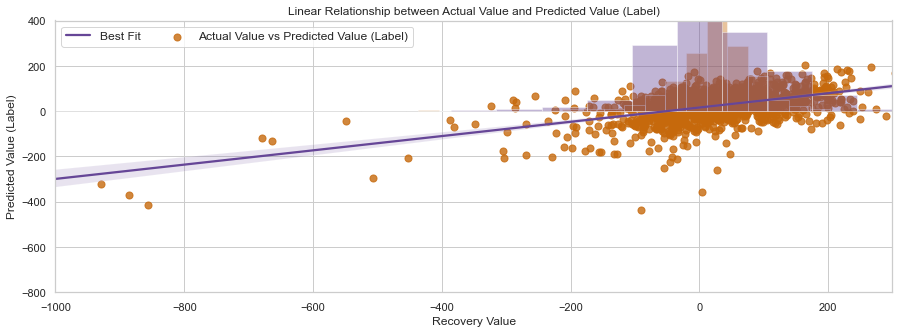

In [145]:
val_preds = modelCB.predict(test_X)
MAPE=np.mean(np.abs((test_y - val_preds) / test_y)) * 100
# calculate mean squared error on val sub-set preds
np.sqrt(mean_squared_error(val_preds, test_y))
print("Accuracy is : ",  100-MAPE)

def residual_plot(train_labels, train_preds, test_labels=None, test_preds=None, 
                  title="Residual Plot", figsize=(9,6)):
    """ Residual plot to evaluate performance of our simple linear regressor """
    plt.figure(figsize=figsize)
    plt.scatter(train_preds, train_preds - train_labels, c='blue', alpha=0.1,
                marker='o', edgecolors='white', label='Training')
    
    if test_labels is not None:
        plt.scatter(test_preds, test_preds - test_labels, c='red', alpha=0.1,
                    marker='^', edgecolors='white', label='Test')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    
    if test_labels is not None:
        plt.legend(loc='best')
    plt.title(title)
    plt.show()
    return

train_preds = modelCB.predict(train_X)

residual_plot(train_y, train_preds, 
              test_y, val_preds, 
              title="CatBoost Residual Plot")

import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_CATBOOST = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_CATBOOST["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_CATBOOST["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend(( 'Predicted Value (Label)',' Value (Actual)'), ncol=2, loc='upper left', fontsize=12)



# We can plot the Predicted Value (Label) and Actual Value over the entire dataset. 
sns.regplot(x="Real", y="Prediction", data=output_data_CATBOOST, lowess=False, scatter_kws ={'s':50}, line_kws={"color": "#664697"}, color="#c6690c")
plt.title("Linear Relationship between Actual Value and Predicted Value (Label)")
plt.ylabel("Predicted Value (Label)")
plt.xlabel("Recovery Value")
plt.xlim([-1000, 300])
plt.ylim([-800,400])
plt.legend(('Best Fit', 'Actual Value vs Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)

output_data_CATBOOST.head(50)
output_data_CATBOOST["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_CATBOOST["Prediction"]]
output_data_CATBOOST["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_CATBOOST["Real"]]

output_data_CATBOOST.head(50)
comparison_column = np.where(output_data_CATBOOST["Prediction_sign"] == output_data_CATBOOST["Real_sign"], True, False)

count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from catboost import cv
def cross_val(model):
    pred = cross_val_score(model, x, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square
#### Cat Boost
print('Test set evaluation:\n_____________________________________')
print_evaluate(test_y, val_preds)
print('Train set evaluation:\n_____________________________________')
print_evaluate(train_y, train_preds)


#### Light GBM 
results_bsic_Catboost = pd.DataFrame(data=[["Cat Boost", *evaluate(train_y, train_preds) ,cross_val(CatBoostRegressor())]], columns=['Model', 'MAE', 'MSE', 'RMSE', 'R2 Square', "Cross Validation"])
results_bsic_Catboost




#feat_importances = modelCB.get_feature_importance(prettified=True)
#feat_importances
#plt.figure(figsize=(12, 10))
#sns.barplot(x="Importances", y="Feature Id", data=feat_importances.loc[:, :])
#plt.title('CatBoost features importance:')
#feat_importances.tail(100)
#feat_importances.loc[:, :]

In [146]:
print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

Accuracy of True values compared to the total observations : 0.6497289972899729


$\textbf{We now add Uplift 2}$

* Λογαριασμός Προσαυξήσεων Ισχύος Εξισορρόπησης
* Χρησιμοποιείται για τον επιμερισμό του κόστους παροχής Ισχύος Εξισορρόπησης απο τους Παρόχους Υπηρεσιών Εξισορρόπησης
 $$Uplift = BALCAP_t \cdot \frac{MQ}{\sum MQ}$$

In [91]:
###### Add Uplift 2 to see if there is going to be any significant difference in the evaluation of our model
x = all_data.drop([columns_data[1],columns_data[2],columns_data[3],columns_data[4],columns_data[5],columns_data[6],columns_data[9],columns_data[14],columns_data[15],columns_data[16],columns_data[17]], axis=1)
x.head()

,Uplift Account 1 (€/MWh),Uplift Account 2 (€/MWh),RES,Load,Mandatory Hydro,Total FRR
2021-08-15 00:00:00,2.738548,0.662670,1820.0,5515.5,50.0,914.0
2021-08-15 01:00:00,2.375837,1.098814,1930.0,5299.0,50.0,939.0
2021-08-15 02:00:00,2.143069,1.201918,2000.0,5127.5,50.0,949.0
2021-08-15 03:00:00,2.043232,1.117085,2035.0,5038.0,63.0,939.0
2021-08-15 04:00:00,2.227400,1.156230,2055.0,4951.5,76.0,1079.0


In [92]:
from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score

train_X, test_X, train_y, test_y = train_test_split(x, y, test_size=0.25)

In [93]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split

num_columns = train_X.columns

ct = make_column_transformer(
    (MinMaxScaler(), num_columns),
    (StandardScaler(), num_columns),
    remainder='passthrough'
)

train_X = ct.fit_transform(train_X)
test_X = ct.transform(test_X)

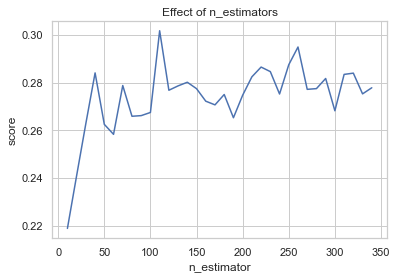

In [94]:
# Scale the data to be between -1 and 1
rf = RandomForestRegressor(n_jobs=-1)

# Try different numbers of n_estimators - this will take a minute or so
estimators = np.arange(10, 343, 10)
scores = []
for n in estimators:
    rf.set_params(n_estimators=n)
    rf.fit(train_X, train_y)
    scores.append(rf.score(test_X, test_y))
plt.title("Effect of n_estimators")
plt.xlabel("n_estimator")
plt.ylabel("score")
plt.plot(estimators, scores)

In [95]:
rf_score = cross_val_score(rf, x, y, cv=kfolds, scoring='neg_mean_squared_error')
rf_rmse =  np.sqrt(-rf_score.mean())
# Printing out Ridge Score and STD
print("Random Forest Model RMSE: ", rf_rmse)
print("Random Forest Model STD: ", rf_score.std())

Random Forest Model RMSE:  87.56460699353708
Random Forest Model STD:  541.6060295606619


In [96]:
preds_train=rf.predict(train_X)
preds1 = rf.predict(test_X)

Evaluation on test data
RMSE: 84.03
R2: 0.28
Adjusted R2: 0.28


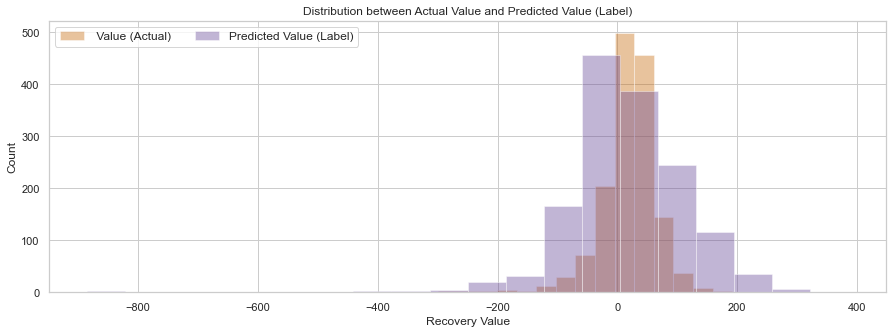

In [97]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_y,preds1))
#R2 Score
r2_test = r2_score(test_y,preds1)
# Adjusted R2 Score
n= train_X.shape[0] # total no of datapoints
p= train_X.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_data_random_forest_with_uplift2 = pd.DataFrame({
                      'Prediction': preds1,'Real': test_y})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_data_random_forest_with_uplift2["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_data_random_forest_with_uplift2["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend((' Value (Actual)', 'Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)



In [98]:
output_data_random_forest.head(50)

output_data_random_forest["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_data_random_forest["Prediction"]]
output_data_random_forest["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_data_random_forest["Real"]]

In [99]:
output_data_random_forest.head(50)
comparison_column = np.where(output_data_random_forest["Prediction_sign"] == output_data_random_forest["Real_sign"], True, False)

In [100]:
count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

We have a total of True values :  983


In [102]:
print('Accuracy', count/len(comparison_column))

Accuracy 0.6659891598915989


$\textbf{Regression with a deep neural Network (DNN) Keras}$

In [180]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.7.0


In [181]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [182]:
dataset = all_data.drop([columns_data[1],columns_data[2],columns_data[3],columns_data[4],columns_data[5],columns_data[6],columns_data[7],columns_data[8],columns_data[9],columns_data[14],columns_data[16],columns_data[17]], axis=1)
dataset.head()



train_dataset = dataset.sample(frac=0.75, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [183]:
train_dataset.head()
test_dataset.head()
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
RES,4428.0,1945.449036,1035.571408,260.00,1053.750000,1870.000000,2675.000000,5195.00000
Load,4428.0,5925.086871,1167.601717,220.00,5055.125000,5929.750000,6766.250000,9258.50000
Mandatory Hydro,4428.0,320.378952,432.948268,0.00,19.000000,106.000000,442.000000,1798.00000
Total FRR,4428.0,1396.218232,366.367226,0.00,1244.000000,1512.500000,1636.000000,2029.00000
Day_ahead_Balancing_diff,4428.0,16.768615,105.706552,-1015.24,-37.168252,15.202925,77.344871,362.62531


In [184]:
train_dataset.head()

,RES,Load,Mandatory Hydro,Total FRR,Day_ahead_Balancing_diff
2021-09-18 12:00:00,3490.0,6849.0,26.0,1574.0,-29.703505
2022-01-13 22:00:00,2435.0,6663.5,615.5,1846.0,-32.743655
2022-04-07 18:00:00,2460.0,6082.5,468.0,1746.0,-69.701767
2021-11-16 15:00:00,2140.0,6360.0,84.5,1729.0,13.535551
2021-09-03 08:00:00,3155.0,6798.5,320.0,1714.0,92.220675


In [185]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('Day_ahead_Balancing_diff')
test_labels = test_features.pop('Day_ahead_Balancing_diff')

In [186]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [187]:
normalizer.adapt(np.array(train_features))

In [188]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 4)                9         
 ion)                                                            
                                                                 
 dense_3 (Dense)             (None, 64)                320       
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,554
Trainable params: 4,545
Non-trainable params: 9
_________________________________________________________________


In [189]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

Wall time: 20.1 s


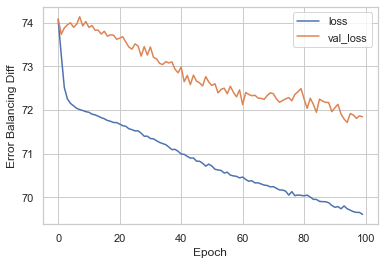

In [190]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')

  plt.xlabel('Epoch')
  plt.ylabel('Error Balancing Diff')
  plt.legend()
  plt.grid(True)

plot_loss(history)

In [191]:
test_results = {}
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

In [192]:
test_results

{'dnn_model': 72.20266723632812}

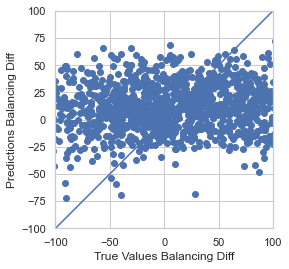

In [193]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values Balancing Diff')
plt.ylabel('Predictions Balancing Diff')
lims = [-100, 100]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

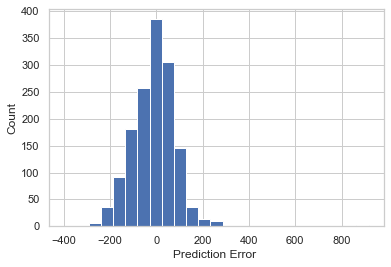

In [194]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error ')
_ = plt.ylabel('Count')

In [195]:
test_labels

2021-08-15 00:00:00     57.123433
2021-08-15 07:00:00     31.875812
2021-08-15 19:00:00     19.302691
2021-08-15 21:00:00     53.604033
2021-08-16 00:00:00     44.733231
                          ...    
2022-04-17 05:00:00    -11.875000
2022-04-17 07:00:00    105.435523
2022-04-17 08:00:00    -90.572857
2022-04-17 13:00:00   -173.203768
2022-04-17 21:00:00    -95.576083
Name: Day_ahead_Balancing_diff, Length: 1476, dtype: float64

In [196]:
test_predictions

array([ 17.798191  , -24.098473  , -10.896747  , ..., -35.622215  ,
        -3.7792625 ,  -0.48693445], dtype=float32)

Evaluation on test data
RMSE: 102.42
R2: 0.02
Adjusted R2: 0.02


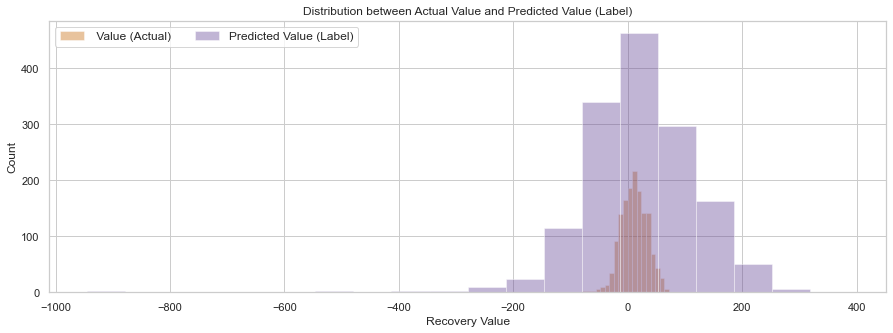

In [197]:
import math
from sklearn.metrics import mean_squared_error, r2_score
#RMSE
Rmse_test = math.sqrt(mean_squared_error(test_labels,test_predictions))
#R2 Score
r2_test = r2_score(test_labels,test_predictions)
# Adjusted R2 Score
n= train_features.shape[0] # total no of datapoints
p= train_features.shape[1] # total no of independent features
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)
#print results
print("Evaluation on test data")
print("RMSE: {:.2f}".format(Rmse_test))
print("R2: {:.2f}".format(r2_test))
print("Adjusted R2: {:.2f}".format(adj_r2_test))


output_keras = pd.DataFrame({
                      'Prediction': test_predictions,'Real': test_labels})





# An interesting view is looking at the Actual Values and Predicted Values (Label) in a histogram over the entire dataset. This shows the distribution between the values. We can see how the Predicted Values seem to peak in a more distributed manner and skew to the left. 
plt.figure(figsize=(15,5))
sns.set_style("whitegrid")
sns.distplot(output_keras["Prediction"],
                bins=20,
                kde=False,
                color="#c6690c")
sns.distplot(output_keras["Real"],
                bins=20,
                kde=False,
                color="#664697")
plt.title("Distribution between Actual Value and Predicted Value (Label)")
plt.ylabel("Count")
plt.xlabel("Recovery Value")

plt.legend((' Value (Actual)', 'Predicted Value (Label)'), ncol=2, loc='upper left', fontsize=12)



In [198]:
output_keras.head(50)
output_keras["Prediction_sign"] =  [1 if int(x) >= 0 else 0 for x in output_keras["Prediction"]]
output_keras["Real_sign"] = [1 if int(x) >= 0 else 0 for x in output_keras["Real"]]

comparison_column = np.where(output_keras["Prediction_sign"] == output_keras["Real_sign"], True, False)

count = np.count_nonzero(comparison_column)
print("We have a total of True values : " , count)

print("Accuracy of True values compared to the total observations :" ,count/len(comparison_column))

We have a total of True values :  853
Accuracy of True values compared to the total observations : 0.5779132791327913
